In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

# COLLECT AND PREPARE DATA

In [4]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [5]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [6]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [7]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [9]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2023-12-13 15:29:09.087892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [12]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [13]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

2023-12-13 15:29:16.271438: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


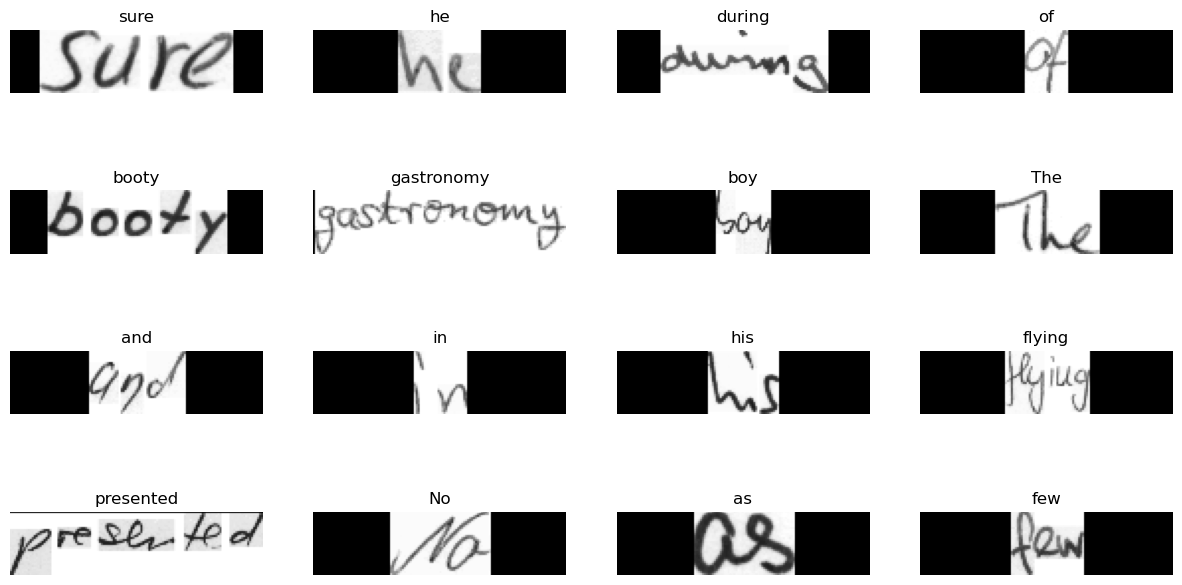

In [14]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [15]:
classes = ["the","of","and","a","to","in","is","you","that","it","he","was","for","on","are","as","with","his","they","I","at","be","this","have","from","or","one","had","by","word","but","not","what","all","were","we","when","your","can","said","there","use","an","each","which","she","do","how","their","if","will","up","other","about","out","many","then","them","these","so","some","her","would","make","like","him","into","time","has","look","two","more","write","go","see","number","no","way","could","people","my","than","first","water","been","call","who","oil","its","now","find","long","down","day","did","get","come","made","may","part"]
classes = classes[:20]
class2index = {word:ix for ix,word in enumerate(classes)}
index2class = {ix:word for ix,word in enumerate(classes)}

In [16]:
images_words = []
labels_words = []

for data in train_ds:
    images, labels = data["image"], data["label"]
    for i in range(len(images)):
        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
    
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        if label in class2index:
            images_words.append(img)
            labels_words.append(class2index[label])
    

In [17]:
new_val_num = int(np.floor(0.20*len(images_words)))
new_val = images_words[:new_val_num]
new_val_label = labels_words[:new_val_num]


new_train = images_words[new_val_num:]
new_train_label = labels_words[new_val_num:]


# MODEL


In [22]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(30, (3, 3),activation='relu', input_shape=(32,128,1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(30, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(30, (3, 3),activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(121, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(20))

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 126, 30)       300       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 63, 30)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 61, 30)        8130      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 30, 30)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 28, 30)         8130      
                                                                 
 flatten_2 (Flatten)         (None, 3360)             

In [24]:
new_train = np.asarray(new_train)
new_train_label = np.asarray(new_train_label)
new_val = np.asarray(new_val)
new_val_label = np.asarray(new_val_label)
history = model.fit(new_train, new_train_label, epochs=10, 
                    validation_data=(new_val, new_val_label))

Epoch 1/10
544/544 [==============================] - 10s 19ms/step - loss: 1.4440 - accuracy: 0.6013 - val_loss: 0.7831 - val_accuracy: 0.7713
Epoch 2/10
544/544 [==============================] - 10s 18ms/step - loss: 0.4864 - accuracy: 0.8530 - val_loss: 0.4468 - val_accuracy: 0.8701
Epoch 3/10
544/544 [==============================] - 10s 18ms/step - loss: 0.2738 - accuracy: 0.9158 - val_loss: 0.3896 - val_accuracy: 0.8901
Epoch 4/10
544/544 [==============================] - 10s 18ms/step - loss: 0.1756 - accuracy: 0.9439 - val_loss: 0.3551 - val_accuracy: 0.9023
Epoch 5/10
544/544 [==============================] - 10s 18ms/step - loss: 0.1382 - accuracy: 0.9536 - val_loss: 0.4433 - val_accuracy: 0.9019
Epoch 6/10
544/544 [==============================] - 10s 18ms/step - loss: 0.1025 - accuracy: 0.9665 - val_loss: 0.4581 - val_accuracy: 0.8998
Epoch 7/10
544/544 [==============================] - 10s 18ms/step - loss: 0.0921 - accuracy: 0.9700 - val_loss: 0.4725 - val_accuracy:

In [25]:
from tensorflow.keras.models import Model

intermediate_layer_index = 7
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[intermediate_layer_index].output)

In [36]:
to_arduino_train = new_val[:400]
to_arduino_labels_train = new_val_label[:400]

to_arduino_val = new_val[401:451]
to_arduino_labels_val = new_val_label[401:451]

to_arduino_test = new_val[452:502]
to_arduino_labels_test = new_val_label[452:502]

preds_arduino_train = intermediate_layer_model.predict(to_arduino_train)
preds_arduino_val = intermediate_layer_model.predict(to_arduino_val)
preds_arduino_test = intermediate_layer_model.predict(to_arduino_test)

2/2 [==============================] - 0s 7ms/step


In [27]:
preds_arduino_train.shape

(400, 64)

In [37]:
print(to_arduino_labels_train.tolist())

[10, 1, 2, 5, 17, 15, 1, 5, 5, 3, 1, 3, 1, 11, 4, 2, 19, 1, 4, 0, 14, 0, 2, 4, 0, 4, 19, 0, 13, 4, 0, 11, 0, 1, 1, 3, 11, 2, 0, 12, 3, 2, 12, 1, 4, 5, 3, 2, 1, 0, 4, 2, 0, 11, 3, 8, 0, 15, 1, 1, 2, 6, 3, 0, 0, 8, 10, 3, 0, 2, 6, 6, 5, 0, 15, 12, 7, 0, 0, 0, 12, 0, 0, 8, 17, 4, 0, 13, 0, 1, 14, 1, 1, 0, 4, 12, 3, 4, 0, 18, 13, 4, 5, 5, 0, 0, 5, 10, 0, 0, 4, 5, 10, 10, 11, 0, 2, 7, 0, 8, 15, 2, 12, 1, 5, 0, 12, 4, 0, 12, 4, 12, 1, 4, 0, 6, 3, 1, 0, 4, 0, 12, 3, 4, 8, 0, 0, 10, 19, 15, 0, 17, 15, 10, 1, 4, 4, 2, 2, 8, 4, 4, 9, 1, 8, 14, 9, 4, 3, 4, 3, 6, 4, 2, 11, 2, 6, 2, 3, 8, 1, 6, 4, 6, 6, 0, 11, 1, 2, 11, 1, 10, 0, 2, 1, 10, 3, 0, 15, 0, 0, 0, 0, 0, 2, 13, 0, 3, 0, 3, 3, 13, 4, 0, 3, 19, 3, 8, 4, 1, 8, 5, 3, 5, 11, 3, 4, 19, 1, 5, 0, 5, 13, 2, 2, 1, 0, 4, 8, 17, 5, 0, 3, 5, 10, 5, 4, 0, 4, 0, 10, 8, 4, 0, 13, 18, 0, 8, 5, 19, 2, 0, 3, 1, 3, 3, 1, 0, 0, 14, 5, 1, 2, 12, 8, 11, 2, 4, 19, 0, 1, 0, 0, 3, 1, 0, 13, 1, 0, 0, 2, 1, 5, 0, 0, 19, 8, 0, 2, 2, 1, 1, 0, 9, 4, 7, 0, 1, 13, 1, 4, 

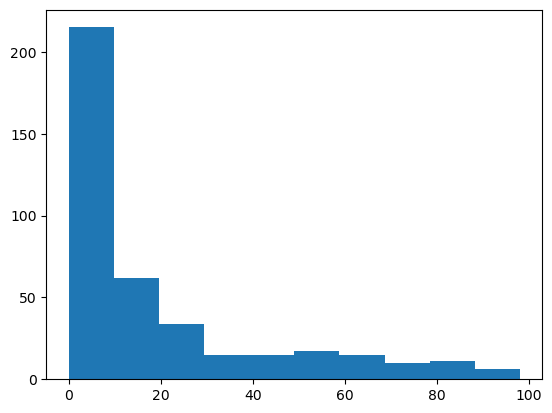

In [268]:
plt.hist(to_arduino_labels_train)
plt.show() 

In [38]:
preds_arduino_train = str(preds_arduino_train.tolist())
preds_arduino_train = preds_arduino_train.replace(']','}')
preds_arduino_train = preds_arduino_train.replace('[','{')
preds_arduino_train = preds_arduino_train.replace('},','},\n')

f = open("file.txt", "w")
f.write(preds_arduino_train)

242440

In [39]:
print(to_arduino_labels_val.tolist())

[11, 2, 6, 19, 5, 4, 5, 1, 5, 0, 0, 0, 9, 6, 4, 19, 4, 0, 4, 2, 11, 16, 0, 0, 4, 6, 1, 11, 0, 1, 1, 2, 15, 0, 5, 2, 17, 2, 10, 9, 12, 19, 5, 13, 10, 0, 2, 15, 0, 5]


In [40]:
preds_arduino_val = str(preds_arduino_val.tolist())
preds_arduino_val = preds_arduino_val.replace(']','}')
preds_arduino_val = preds_arduino_val.replace('[','{')
preds_arduino_val = preds_arduino_val.replace('},','},\n')

f = open("file.txt", "w")
f.write(preds_arduino_val)

30438

In [34]:
print(to_arduino_labels_test.tolist())

[16, 10, 4, 15, 16, 0, 2, 10, 5, 0, 4, 9, 4, 16, 11, 7, 4, 13, 10, 0, 4, 2, 5, 5, 11, 3, 9, 16, 11, 10, 14, 0, 0, 1, 4, 0, 4, 12, 0, 0, 11, 1, 1, 8, 3, 5, 2, 10, 4, 19]


In [35]:
preds_arduino_test = str(preds_arduino_test.tolist())
preds_arduino_test = preds_arduino_test.replace(']','}')
preds_arduino_test = preds_arduino_test.replace('[','{')
preds_arduino_test = preds_arduino_test.replace('},','},\n')

f = open("file.txt", "w")
f.write(preds_arduino_test)

30381

# PICTURE

In [220]:
import imp
from itertools import count
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.image as mpimg
import struct


In [240]:
data = [0x6F6C, 0x6F6C, 0x6F6C, 0x906C, 0x906C, 0x906C, 0xB06C, 0xB06C, 0xD274, 0xD274, 0xF274, 0xD274, 0xD274, 0xD274, 0xF274, 0xF27C, 0xF27C, 0xF27C, 0x117E, 0x117E, 0x317E, 0x3186, 0x1186, 0x3386, 0x3386, 0x317E, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x338E, 0x3386, 0x7196, 0x9396, 0x9496, 0x948E, 0x348E, 0x338E, 0x338E, 0x3186, 0x3186, 0x3186, 0x3186, 0x517E, 0x337E, 0xF174, 0x1176, 0x317E, 0x9386, 0xB486, 0xF364, 0xD164, 0x7254, 0xF23B, 0x903B, 0x2F33, 0xED29, 0xEE29, 0xCD29, 0xEE29, 0xE2B, 0xE33, 0xD33, 0xD2B, 0xD2B, 0xD33, 0x2D2B, 0x2D33, 0x2D33, 0x6D3B, 0x6F33, 0x6F33, 0x6F33, 0x8F33, 0x6F33, 0xB033, 0xB033, 0xB033, 0xD033, 0xF233, 0xF23B, 0x123C, 0x313C, 0x513C, 0x5144, 0x7344, 0x7344, 0x7344, 0xB44C, 0xF654, 0x1656, 0x1556, 0x355E, 0x575E, 0x775E, 0x7766, 0xB866, 0xDA6E, 0xFA6E, 0x1975, 0x3B75, 0x7C7D, 0x7E7D, 0x9E85, 0xBD85, 0x1D8F, 0x1D8F, 0x1D8F, 0x3D8F, 0x3D8F, 0x9D8F, 0x9D97, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x4F6C, 0x6F6C, 0x906C, 0x906C, 0x906C, 0xB06C, 0xB06C, 0xB074, 0xD074, 0xD274, 0xD274, 0xD274, 0xF274, 0xD27C, 0xF27C, 0xF27C, 0xF27C, 0x127E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3386, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x7386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x3386, 0x518E, 0x7396, 0x9396, 0x9396, 0x738E, 0x3486, 0x3386, 0x3386, 0x117E, 0x317E, 0x317E, 0x317E, 0x317E, 0x3176, 0xF16C, 0xD16C, 0xD174, 0x9386, 0x967E, 0x5354, 0x314C, 0xB03B, 0x6F33, 0xE2B, 0x2E33, 0xEE29, 0xEE29, 0xEE31, 0xEE29, 0xEE29, 0xED29, 0xED29, 0xE2B, 0x2D2B, 0x2D2B, 0x2D2B, 0x2D2B, 0x2D2B, 0xF2B, 0xEF21, 0x2D2B, 0x6F2B, 0x6F2B, 0x6F2B, 0x9033, 0xB033, 0xB033, 0xD033, 0xF233, 0xF233, 0xF23B, 0x123C, 0x3144, 0x3144, 0x5344, 0x7344, 0x9444, 0xB44C, 0xD64C, 0xB64C, 0xF554, 0x3556, 0x555E, 0x775E, 0x775E, 0x9866, 0xBA66, 0xBA66, 0xDA6E, 0xF96E, 0x1B75, 0x3C75, 0x7E7D, 0x9D7D, 0xBD85, 0xDD85, 0xFD85, 0x1D8F, 0x3D8F, 0x5D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x706C, 0x706C, 0x706C, 0x906C, 0xB06C, 0xB06C, 0xB26C, 0xB274, 0xB274, 0xB274, 0xD274, 0xD274, 0xF274, 0xF27C, 0xF27C, 0xF27C, 0x127E, 0x117E, 0x117E, 0x317E, 0x317E, 0x3186, 0x3186, 0x5386, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x7386, 0x7386, 0x9386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x5386, 0x518E, 0x9396, 0x7396, 0x9496, 0x738E, 0x1486, 0x3186, 0x3186, 0x117E, 0x117E, 0x117E, 0x117E, 0x317E, 0x517E, 0x1176, 0x1176, 0x3176, 0x737E, 0x7476, 0xF143, 0xCF43, 0x6D33, 0x4F33, 0xEE29, 0xCE29, 0xAE29, 0xAC29, 0xCE29, 0xEE31, 0xEE31, 0xCE29, 0xEE29, 0xEE29, 0xEE29, 0xEE29, 0x2D2B, 0xD2B, 0xD2B, 0xD2B, 0x4D33, 0x4D2B, 0x6F33, 0x6D33, 0x8F33, 0x8F33, 0xAF33, 0xB033, 0xD033, 0xF23B, 0xF233, 0xF23B, 0x123C, 0x313C, 0x3144, 0x5344, 0x5344, 0x9344, 0xB44C, 0xD44C, 0xD64C, 0xF654, 0xF654, 0x355E, 0x555E, 0x775E, 0x7766, 0x9866, 0x9A6E, 0xDA6E, 0xFA76, 0xF976, 0x3B75, 0x5B7D, 0x5C7D, 0x7C7D, 0x9E85, 0xDD85, 0xDD85, 0xFD85, 0xFD85, 0xFD85, 0x5D8F, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xAF74, 0xB074, 0xB06C, 0x906C, 0xB06C, 0xD074, 0xB274, 0xB274, 0xD274, 0xD274, 0xD274, 0xD274, 0xD27C, 0xF27C, 0xF27C, 0x127E, 0x127E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x7386, 0x9386, 0x9386, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x5386, 0x1186, 0x718E, 0x7396, 0x948E, 0x738E, 0x1486, 0x3186, 0x3186, 0xF174, 0xD174, 0xD274, 0xF274, 0xF174, 0xF174, 0xD16C, 0xF16C, 0xF36C, 0x1366, 0x336E, 0xD23B, 0x8F33, 0x4E2B, 0x2D2B, 0xE2B, 0xCE29, 0xCC29, 0xCE29, 0xCE29, 0x8E29, 0xAE29, 0xCE29, 0xCE29, 0xD2B, 0xED29, 0xD2B, 0xD2B, 0xD2B, 0xD2B, 0xD2B, 0x2D33, 0x2F2B, 0x2D2B, 0x6D2B, 0x8F33, 0x8F33, 0xAF33, 0xAF33, 0xB033, 0xB033, 0xD233, 0xF23B, 0x113C, 0x313C, 0x3144, 0x3144, 0x7344, 0x5344, 0x7444, 0xD44C, 0xD64C, 0xD654, 0xD654, 0x3556, 0x355E, 0x575E, 0x775E, 0x7866, 0xB866, 0xBA6E, 0xD96E, 0xD96E, 0xDB6E, 0xF976, 0x1B75, 0x5C7D, 0x7E7D, 0xBD85, 0xBD85, 0x9D7D, 0xBD85, 0xDD85, 0xFD85, 0xFD85, 0x5D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xB06C, 0x906C, 0xB06C, 0xB06C, 0xB26C, 0xD26C, 0xD274, 0xD274, 0xD274, 0xF274, 0xF274, 0xD274, 0xD27C, 0xF27C, 0xF27C, 0x117E, 0x117E, 0x117E, 0x317E, 0x317E, 0x3186, 0x5186, 0x5186, 0x3386, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x7386, 0x9386, 0x938E, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x538E, 0x3186, 0x718E, 0x7396, 0x748E, 0x538E, 0x1386, 0x3286, 0x5286, 0xF27C, 0xF274, 0xF274, 0xF274, 0xF274, 0xD174, 0x906C, 0x926C, 0x9264, 0x9064, 0x7254, 0x9033, 0x4D2B, 0xCC21, 0x6C21, 0x8B29, 0xCC29, 0xCC29, 0xCC29, 0xCE29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xCE29, 0xEE29, 0xEE29, 0xE2B, 0xD2B, 0xD2B, 0xD33, 0xD2B, 0xD2B, 0x4D2B, 0x6D2B, 0x6F33, 0x6F33, 0x8F33, 0x8F33, 0x9033, 0xB033, 0xD23B, 0xF233, 0x123C, 0x113C, 0x113C, 0x3344, 0x5344, 0x7344, 0x7344, 0xB44C, 0xD44C, 0xD454, 0xD654, 0xF654, 0x565E, 0x575E, 0x5766, 0x7766, 0x9766, 0x986E, 0xBA6E, 0xDA76, 0xD976, 0x197D, 0x1B75, 0x3B7D, 0x5C7D, 0x5C85, 0x7E85, 0x9D85, 0x9D85, 0xDD85, 0xFD8D, 0xDD85, 0x3D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x906C, 0xB06C, 0xB06C, 0x906C, 0xB274, 0xB274, 0xD274, 0xD274, 0xD274, 0xF274, 0xF274, 0xF274, 0xF27C, 0xF27C, 0xF27C, 0x117E, 0x117E, 0x1186, 0x3186, 0x3186, 0x5186, 0x5186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x548E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x938E, 0x738E, 0x738E, 0x5386, 0x3186, 0x738E, 0x738E, 0x748E, 0x538E, 0x337E, 0x117E, 0x117E, 0xD274, 0xD274, 0xD274, 0xD174, 0xD26C, 0x9164, 0x305C, 0x325C, 0x3054, 0x5054, 0x304C, 0x8D3B, 0x2E2B, 0xCB29, 0x8C29, 0xAC29, 0xCC29, 0xCC29, 0xAC29, 0xAC29, 0xAE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xEE29, 0xEE29, 0xEE29, 0xD2B, 0xED29, 0xD33, 0xD2B, 0x2D2B, 0x2D2B, 0x6F33, 0x6F33, 0x6F33, 0x8F33, 0x8F33, 0x9033, 0x9033, 0xD233, 0xF03B, 0xF23B, 0x123C, 0x113C, 0x3344, 0x5344, 0x5344, 0x5344, 0x934C, 0xB44C, 0xD454, 0xD654, 0xF554, 0x165E, 0x355E, 0x5566, 0x7766, 0x7866, 0x986E, 0xBA6E, 0xDA76, 0xD976, 0x1975, 0x1B75, 0x3B7D, 0x5C7D, 0x7E7D, 0x5E7D, 0x7E7D, 0x9D7D, 0x9D7D, 0xDD85, 0xDD85, 0x1D8F, 0x3D87, 0x3D87, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD074, 0xB06C, 0xD074, 0xD274, 0xB274, 0xB274, 0xD274, 0xD274, 0xD274, 0xF274, 0xF274, 0x1276, 0xF27C, 0xF27C, 0x127E, 0x117E, 0x117E, 0x117E, 0x3186, 0x3186, 0x5386, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x7386, 0x7386, 0x538E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x948E, 0x748E, 0x748E, 0x738E, 0x3386, 0x1186, 0x538E, 0x738E, 0x538E, 0x538E, 0x3386, 0x117E, 0xD174, 0x906C, 0xB074, 0xB274, 0xB274, 0x9264, 0x9264, 0x4F5C, 0xF54, 0xED4B, 0xEF4B, 0x4D33, 0xAE29, 0x8C29, 0xAB29, 0x8C29, 0xAC29, 0x8C29, 0x8C29, 0xAC29, 0xAC29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xEE29, 0xCE29, 0xEE29, 0xEE29, 0xD2B, 0xD33, 0xD2B, 0x2D2B, 0x2D2B, 0x4D33, 0x4D33, 0x6F33, 0x8F33, 0x8F33, 0x9033, 0xB033, 0xB03B, 0xF03B, 0xF23B, 0xF23B, 0x1144, 0x3144, 0x3144, 0x5344, 0x7344, 0x734C, 0xB44C, 0xB454, 0xD654, 0xF65C, 0xF65C, 0x155E, 0x5566, 0x7766, 0x7766, 0x976E, 0x986E, 0xBA76, 0xDA76, 0xBA76, 0xD976, 0xF976, 0x3B7D, 0x5C7D, 0x5C7D, 0x7C7D, 0x7E7D, 0x7E85, 0x9D85, 0xBD85, 0xDD8D, 0xDD85, 0xFD8D, 0x1D8F, 0x7D8F, 0x7D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xB074, 0xD074, 0xD074, 0xD274, 0xD274, 0xB274, 0xD274, 0xD274, 0xF274, 0xD274, 0xF274, 0xF27C, 0x127E, 0x127E, 0x117E, 0x317E, 0x117E, 0x1186, 0x3186, 0x3186, 0x3186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x948E, 0x748E, 0x738E, 0x3386, 0x1186, 0x518E, 0x538E, 0x338E, 0x5386, 0xF37C, 0xD274, 0xB274, 0x906C, 0x906C, 0x926C, 0x926C, 0x9264, 0x925C, 0x104C, 0xB043, 0x8F3B, 0x4D33, 0xAB29, 0x8B29, 0x8929, 0xAC29, 0x8C29, 0x8C29, 0x8C29, 0xAC29, 0xAC29, 0xAC29, 0xAE29, 0xAE29, 0xAE29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xEE29, 0xEE29, 0xE2B, 0xD2B, 0x2D2B, 0x2D2B, 0x2D2B, 0x4D2B, 0x4F33, 0x6F2B, 0xAF33, 0xAF33, 0xB033, 0xB033, 0xB233, 0xF03B, 0xF23B, 0xF23B, 0x1144, 0x1144, 0x3144, 0x5344, 0x534C, 0x744C, 0x9454, 0xB454, 0xB654, 0xD65C, 0x165E, 0x155E, 0x3566, 0x5766, 0x5766, 0x776E, 0x986E, 0xB876, 0xBA76, 0xDA76, 0xF976, 0xF976, 0x1B7D, 0x3B7D, 0x5B7D, 0x5C7D, 0x5E7D, 0x5E7D, 0x5E7D, 0x7E7D, 0x9D85, 0xDD85, 0xDD85, 0xFD85, 0x3D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xB06C, 0xD074, 0xD274, 0xD274, 0xD274, 0xD074, 0xD274, 0xF274, 0xF274, 0xD274, 0xF274, 0xF27C, 0x127E, 0x117E, 0x127E, 0x317E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x538E, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x948E, 0x748E, 0x738E, 0x3386, 0x3186, 0x718E, 0x5386, 0x5386, 0x5386, 0xD17C, 0x9074, 0x926C, 0x706C, 0x706C, 0x906C, 0x7064, 0x705C, 0x3054, 0xCD4B, 0x6D3B, 0x2E3B, 0xEE31, 0x8C29, 0x8E29, 0xAC29, 0xAC29, 0x8C29, 0x8C29, 0x8C29, 0xAB29, 0xCC29, 0xAC29, 0xAC29, 0xAC29, 0xCE29, 0xAE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xEE29, 0xE2B, 0xE2B, 0xD2B, 0xD2B, 0x2D2B, 0x2D2B, 0x4F33, 0x6F2B, 0x8F33, 0xAF33, 0xB033, 0xB03B, 0xD03B, 0xB23B, 0xD23B, 0xF23B, 0xF243, 0x1144, 0x3144, 0x5344, 0x534C, 0x744C, 0x9454, 0xB454, 0xB454, 0xD65C, 0xF65C, 0x165E, 0x3566, 0x3566, 0x556E, 0x776E, 0x576E, 0x9876, 0xB876, 0xB876, 0xDA76, 0xFA7E, 0x197D, 0x197D, 0x397D, 0x3B7D, 0x3C7D, 0x3C7D, 0x5C7D, 0x7E7D, 0x9E7D, 0x9D85, 0x9D85, 0xDD85, 0xFD8D, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD06C, 0xB074, 0xD074, 0xD274, 0xD274, 0xF274, 0xF274, 0xF274, 0xF27C, 0xD27C, 0xD27C, 0xF27C, 0xF27C, 0x117E, 0x127E, 0x317E, 0x317E, 0x3186, 0x3186, 0x5186, 0x5386, 0x5386, 0x738E, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x948E, 0x748E, 0x738E, 0x5386, 0x3186, 0x5186, 0x7386, 0x5386, 0x137E, 0xB174, 0x906C, 0x706C, 0x2F5C, 0x2F64, 0x5064, 0x525C, 0x1054, 0xCF4B, 0x8D43, 0xED31, 0xAC29, 0xAC29, 0x8B29, 0x6C29, 0x8B29, 0x8B29, 0x8C29, 0x6C29, 0x8C29, 0xAB29, 0xAC29, 0xAC21, 0xAC21, 0xAC29, 0xCC29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xEE29, 0xEE29, 0xD2B, 0xD2B, 0xD2B, 0x2D2B, 0x2D2B, 0x4F33, 0x6F2B, 0x8F33, 0x8F33, 0x903B, 0x9033, 0xB03B, 0xB23B, 0xD23B, 0xF23B, 0xF243, 0xF143, 0x314C, 0x534C, 0x5354, 0x5454, 0x9454, 0x9454, 0xB45C, 0xD45C, 0xF65C, 0x1666, 0x3566, 0x356E, 0x576E, 0x576E, 0x7776, 0x7876, 0x9876, 0xB876, 0xDA76, 0xDA7E, 0xF97E, 0x197D, 0x1B7D, 0x1B7D, 0x3B7D, 0x5C7D, 0x5C7D, 0x7E7D, 0x7E7D, 0x9E7D, 0xBD7D, 0xBD85, 0xBD85, 0xFD85, 0x1D87, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9E9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD06C, 0xD074, 0xD274, 0xF274, 0xF274, 0xF274, 0xF274, 0xF274, 0xF27C, 0x9274, 0xB274, 0xF27C, 0x127E, 0x127E, 0x127E, 0x327E, 0x317E, 0x3186, 0x3186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x738E, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x738E, 0x5386, 0x3186, 0x3186, 0x3186, 0x3386, 0x317E, 0xB174, 0x706C, 0x706C, 0x2F64, 0x4F64, 0x4F64, 0x1054, 0xF54, 0xAD43, 0x4D3B, 0xCE29, 0x8C29, 0x6C29, 0x6B29, 0x6C29, 0x6B29, 0x6B29, 0x6C29, 0x6B29, 0x8C29, 0x8B29, 0xAC29, 0xAC29, 0xAC21, 0xAC29, 0xAC29, 0x8C21, 0xAC29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xCD29, 0xD33, 0xED31, 0xE2B, 0x2D2B, 0x2D2B, 0x4F33, 0x4F33, 0x6F33, 0x6F33, 0x8F33, 0xB033, 0xB03B, 0xB03B, 0xB03B, 0xF03B, 0xF243, 0xF143, 0x3144, 0x514C, 0x514C, 0x7354, 0x9354, 0xB454, 0xB45C, 0xF45C, 0xD65C, 0x1666, 0x3566, 0x356E, 0x556E, 0x776E, 0x7776, 0x7776, 0x9876, 0xB876, 0xB87E, 0xFA7E, 0xFA7E, 0xF97E, 0x197D, 0x197D, 0x1B7D, 0x3B7D, 0x3B7D, 0x5B7D, 0x7C7D, 0x7E7D, 0x9E7D, 0x9E7D, 0xBD85, 0xDD85, 0x1D8F, 0x1D8F, 0x7D97, 0x9D97, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD074, 0xD274, 0xD274, 0xD274, 0xF274, 0xF274, 0xF274, 0xF27C, 0xF27C, 0x117E, 0x317E, 0x117E, 0x117E, 0x317E, 0x317E, 0x327E, 0x3186, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x948E, 0x748E, 0x748E, 0x748E, 0x748E, 0x3386, 0xF17C, 0x117E, 0x117E, 0x117E, 0x137E, 0xB26C, 0x5064, 0x7064, 0x2F5C, 0xF5C, 0xEF53, 0x8F43, 0x8F43, 0xE33, 0xE33, 0xAB29, 0x8B29, 0x8C29, 0x6B29, 0x6C29, 0x6B29, 0x6B29, 0x8C29, 0x8C29, 0x8B29, 0x8B29, 0xAC29, 0xAC29, 0x8C29, 0xAC29, 0xAC29, 0xAC29, 0xAC29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xCD29, 0xCD29, 0xED29, 0xD2B, 0x2D2B, 0x2D2B, 0x4F2B, 0x4F33, 0x6F33, 0x6F33, 0x8F33, 0xB033, 0xB03B, 0xB03B, 0xD03B, 0xD23B, 0x1244, 0x1144, 0x314C, 0x314C, 0x5154, 0x7354, 0x935C, 0x945C, 0xB45C, 0xD464, 0xD664, 0xF66C, 0x156E, 0x156E, 0x356E, 0x5776, 0x5776, 0x7776, 0x987E, 0x987E, 0xB87E, 0xDA7E, 0xDA7E, 0xF97E, 0xF986, 0x1985, 0x1B7D, 0x1B7D, 0x3B7D, 0x1B75, 0x1B75, 0x3C7D, 0x7E7D, 0x7E7D, 0x9E7D, 0xBD85, 0xFD85, 0xDD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xB274, 0xD274, 0xD274, 0xD274, 0xD274, 0xF274, 0xF274, 0xF274, 0x127E, 0xF27C, 0x117E, 0x117E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x938E, 0x748E, 0x948E, 0x748E, 0x748E, 0x748E, 0x748E, 0x738E, 0x5386, 0xF27C, 0xF284, 0x117E, 0xF17C, 0xD274, 0x7064, 0x2F64, 0xF64, 0xED5B, 0xED53, 0xEF4B, 0xAD43, 0x8D43, 0xAE29, 0x6C29, 0x4C29, 0x4B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x4B29, 0x8C29, 0x8C29, 0x8C29, 0x8C29, 0x6C29, 0x8C29, 0xAC29, 0xAC29, 0xAC29, 0xAC29, 0xAC29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xCD29, 0xED29, 0xED29, 0xD2B, 0xD2B, 0x2D2B, 0x2D33, 0x4F33, 0x4F33, 0x6F33, 0xAF33, 0xAF33, 0xB03B, 0xB03B, 0xD03B, 0xD03B, 0x1244, 0x1144, 0x314C, 0x514C, 0x714C, 0x7354, 0x935C, 0x945C, 0xB45C, 0xD464, 0xD664, 0x166E, 0x166E, 0x356E, 0x3576, 0x5576, 0x7776, 0x7776, 0x777E, 0x987E, 0xB87E, 0xD87E, 0xDA7E, 0xFA7E, 0xF986, 0xF986, 0xF97E, 0xF97E, 0x197D, 0x3B75, 0x1B7D, 0x3B7D, 0x7C7D, 0x7C7D, 0x9C85, 0x9E85, 0xBE85, 0xDD8D, 0x1D8F, 0x3D8F, 0x7D8F, 0x9D97, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD274, 0xD274, 0xD274, 0xF27C, 0xF27C, 0xF27C, 0xF27C, 0xF27C, 0x127E, 0x127E, 0x127E, 0x117E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x538E, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x938E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x738E, 0x137E, 0xD27C, 0xF27C, 0xF17C, 0xB26C, 0x926C, 0x7064, 0x2F5C, 0xF5C, 0xCF53, 0xCD4B, 0xAF43, 0x6F3B, 0xE33, 0xAC29, 0xAB29, 0x8C29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x8C29, 0x6C29, 0x8C29, 0x8B29, 0xAC29, 0xAC29, 0xCC21, 0xAC29, 0xAC29, 0xAE29, 0xAE29, 0xCE29, 0xCE29, 0xCD29, 0xED29, 0xED29, 0xD2B, 0xD2B, 0xD33, 0x2D33, 0x4F33, 0x4F33, 0x8F33, 0x8F33, 0xB03B, 0xB03B, 0xD043, 0xD043, 0xD043, 0x324C, 0xF24B, 0x3154, 0x5154, 0x7154, 0x7354, 0x935C, 0x9464, 0xB464, 0xD46C, 0xD66C, 0xF66C, 0x1676, 0x3676, 0x3576, 0x5576, 0x577E, 0x777E, 0x7786, 0x9886, 0xB886, 0xD886, 0xDA86, 0xDA86, 0xFA86, 0xF986, 0xF986, 0xF97E, 0xF97E, 0x1B7D, 0x1B7D, 0x3B7D, 0x5B7D, 0x5C7D, 0x5C7D, 0x7E7D, 0xBD85, 0xDD8D, 0xFD85, 0xFD85, 0x1D87, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD274, 0xD274, 0xD274, 0xF27C, 0xF274, 0x127E, 0xF17C, 0xF27C, 0x127E, 0x127E, 0x117E, 0x117E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x538E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x748E, 0x738E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x738E, 0x738E, 0xF184, 0xB27C, 0xF27C, 0xF274, 0xD274, 0x726C, 0x4F64, 0xD5C, 0xF5C, 0xAD53, 0x8E4B, 0x6E43, 0xEE31, 0x6C21, 0x2B21, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x4B21, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x8B21, 0x8B29, 0x8B29, 0x6B29, 0x8B29, 0xAC29, 0xAC29, 0xAC29, 0xAC29, 0xAE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xCE29, 0xED29, 0xD2B, 0xD2B, 0xD2B, 0x2D33, 0x2D33, 0x4D33, 0x6F33, 0x8F33, 0xAF3B, 0xB043, 0xD043, 0xD243, 0xF243, 0x1254, 0x114C, 0x3154, 0x7154, 0x715C, 0x735C, 0x935C, 0xB464, 0xD464, 0xD46C, 0xF46C, 0x166E, 0x166E, 0x3676, 0x5576, 0x5576, 0x557E, 0x777E, 0x977E, 0x9786, 0xB886, 0xB886, 0xB886, 0xDA86, 0xFA86, 0x1A85, 0x1985, 0xF97E, 0x197D, 0x197D, 0x197D, 0x3B7D, 0x5B7D, 0x5B7D, 0x5B7D, 0x7C7D, 0x9E85, 0xBE85, 0xDD85, 0xFD85, 0x3D8F, 0x5D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD274, 0xD27C, 0xD27C, 0xD27C, 0xF27C, 0x117E, 0x127E, 0x117E, 0x117E, 0x127E, 0x117E, 0x317E, 0x317E, 0x3186, 0x3186, 0x3186, 0x5186, 0x5386, 0x5386, 0x538E, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x7386, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x948E, 0x948E, 0x748E, 0x748E, 0x7386, 0x5386, 0xF17C, 0xD074, 0xD274, 0xD26C, 0x926C, 0x325C, 0xF5C, 0xED53, 0xED53, 0xCF4B, 0x8D43, 0xE33, 0xAC29, 0x6B29, 0x8B29, 0x6B21, 0x6B21, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x8B21, 0x8B29, 0x8B21, 0x8B21, 0x8B21, 0xAC21, 0xAC21, 0xAC21, 0xAC21, 0xAE29, 0xCE29, 0xCE29, 0xAE29, 0xCE29, 0xEE29, 0xED29, 0xD2B, 0xD2B, 0x2D2B, 0x2D33, 0x6D33, 0x6F33, 0x8F33, 0x8F3B, 0xAF43, 0xB043, 0xB04B, 0xD24B, 0xF24B, 0x1254, 0x1254, 0x3154, 0x515C, 0x515C, 0x7364, 0x9364, 0xB464, 0xD46C, 0xD46C, 0xF46C, 0xF474, 0x1676, 0x3576, 0x357E, 0x557E, 0x577E, 0x7786, 0x7786, 0x9886, 0x9886, 0x9886, 0xD88E, 0xDA86, 0xFA86, 0xFA86, 0xFA86, 0xF986, 0xF97E, 0x197D, 0x197D, 0x1B7D, 0x3B7D, 0x5B7D, 0x5C7D, 0x7C7D, 0x7E7D, 0x9D85, 0xDD85, 0xDD85, 0xFD85, 0xFD85, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF274, 0xD274, 0xF27C, 0xF274, 0xF27C, 0x127E, 0x117E, 0x117E, 0x117E, 0x117E, 0x317E, 0x317E, 0x317E, 0x317E, 0x5186, 0x3186, 0x3386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x538E, 0x7386, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x5386, 0x7386, 0xF17C, 0xD074, 0xD06C, 0x906C, 0x9064, 0x105C, 0xEF53, 0xCE53, 0xAD4B, 0x8E43, 0x4C3B, 0xCC29, 0x8C29, 0x4B21, 0x4B29, 0x6B21, 0x6B21, 0x6921, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x6B29, 0x8B29, 0x8B29, 0x8B29, 0x8B21, 0x8C21, 0x8C21, 0x8C21, 0x8C21, 0xAC29, 0xAC21, 0xCC29, 0xCE29, 0xAE29, 0xAE29, 0xCE29, 0xEE29, 0xD2B, 0xD2B, 0x2D2B, 0x2D33, 0x6D33, 0x6F33, 0x8F33, 0x8F3B, 0xCF43, 0xD043, 0xD04B, 0xD24B, 0xF24B, 0x1254, 0x1254, 0x5154, 0x515C, 0x5164, 0x7364, 0x9364, 0xB46C, 0xB46C, 0xD46C, 0xF66C, 0x1676, 0x1676, 0x3676, 0x357E, 0x557E, 0x777E, 0x7786, 0x9786, 0x9786, 0x9886, 0xB886, 0xD886, 0xD886, 0xFA86, 0xFA86, 0xFA86, 0x1A85, 0xFA7E, 0x197D, 0x197D, 0x197D, 0x1B7D, 0x3B7D, 0x3B7D, 0x5C85, 0x7C85, 0x9E85, 0xBE85, 0xBD85, 0xDD8D, 0xDD8D, 0x3D8F, 0x5D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF274, 0xD27C, 0xF27C, 0xF27C, 0x127E, 0x127E, 0x317E, 0x327E, 0x327E, 0x327E, 0x317E, 0x317E, 0x317E, 0x317E, 0x5186, 0x3186, 0x5386, 0x5386, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x7386, 0x738E, 0x748E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x9486, 0x7386, 0x5386, 0x5386, 0xD174, 0xB06C, 0xD06C, 0x9064, 0x9264, 0x305C, 0xF053, 0xCD4B, 0x6D3B, 0x2E33, 0xC33, 0xEC31, 0x8B29, 0x4B21, 0x6B29, 0x4B21, 0x6B29, 0x6B21, 0x6B29, 0x6929, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x8B29, 0x8B21, 0x8B29, 0x8B29, 0x8B21, 0x8B21, 0x8C21, 0x8C21, 0x8C21, 0xAC29, 0xAC29, 0xAC29, 0xCE29, 0xAE29, 0xAE29, 0xCE29, 0xEE29, 0xD2B, 0xD2B, 0xD33, 0x2D33, 0x6D3B, 0x6F3B, 0x8F3B, 0x8F3B, 0xAF43, 0xB04B, 0xD053, 0xF053, 0x125C, 0x315C, 0x315C, 0x315C, 0x5164, 0x7164, 0x9364, 0x946C, 0xB46C, 0xD46C, 0xD474, 0xF674, 0x1676, 0x167E, 0x167E, 0x357E, 0x5586, 0x7786, 0x7786, 0x978E, 0x978E, 0x9886, 0xB886, 0xB88E, 0xD88E, 0xDA8E, 0xFA8E, 0xFA8E, 0x1A85, 0xF986, 0xF986, 0xF97E, 0x197D, 0x3B7D, 0x3B7D, 0x3B7D, 0x3C7D, 0x5C7D, 0x5C7D, 0x9E85, 0xBD85, 0xDD85, 0xDD85, 0x1D87, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD274, 0xF27C, 0xF27C, 0x127E, 0x127E, 0x117E, 0x117E, 0x117E, 0x317E, 0x1186, 0x317E, 0x317E, 0x317E, 0x517E, 0x5186, 0x3186, 0x5386, 0x5386, 0x538E, 0x538E, 0x538E, 0x538E, 0x7386, 0x738E, 0x738E, 0x738E, 0x938E, 0x738E, 0x748E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x738E, 0x7386, 0x5386, 0x5386, 0xD174, 0x4F6C, 0x6F64, 0x7064, 0x4F5C, 0xF54, 0xCF4B, 0x8E43, 0x8D43, 0x2E33, 0xAC29, 0x8929, 0x4B21, 0x2B21, 0x4929, 0x4B21, 0x4921, 0x4B29, 0x6B29, 0x6B21, 0x6929, 0x6B21, 0x6B21, 0x8B21, 0x8B21, 0x6B29, 0x6B29, 0x6B29, 0x8B21, 0x8C21, 0x8C21, 0x8C21, 0x8C29, 0xAC29, 0xAC29, 0xAE29, 0x8E29, 0xAE29, 0xAE29, 0xCE29, 0xEE29, 0xEE29, 0xE33, 0x2D33, 0x4D3B, 0x2F33, 0x6F3B, 0x8F3B, 0x9043, 0xB043, 0xD04B, 0xD04B, 0xF253, 0x125C, 0x315C, 0x315C, 0x715C, 0x7164, 0x7364, 0x736C, 0xB36C, 0xB36C, 0xD474, 0xF474, 0xF674, 0x1676, 0x167E, 0x367E, 0x5586, 0x5586, 0x7786, 0x7786, 0x9786, 0x978E, 0x988E, 0xB886, 0xB88E, 0xD88E, 0xFA8E, 0xFA8E, 0xFA8E, 0xFA8E, 0xFA8E, 0xF986, 0xF986, 0x197D, 0x197D, 0x3B7D, 0x3B7D, 0x5B7D, 0x5C7D, 0x7C7D, 0x7E85, 0x7E7D, 0xBD85, 0xDD85, 0x1D8F, 0x5D8F, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x127E, 0xF27C, 0x127E, 0x127E, 0x127E, 0x117E, 0x117E, 0x117E, 0x317E, 0x3186, 0x3186, 0x317E, 0x317E, 0x5186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x7486, 0x7386, 0x337E, 0x337E, 0xD374, 0x7064, 0x7064, 0x505C, 0x2F5C, 0xEF53, 0x8D43, 0x4C3B, 0x4D3B, 0xEE29, 0x8B21, 0x6929, 0x6B29, 0x4921, 0x4921, 0x6B29, 0x4B29, 0x4B29, 0x4B29, 0x6B29, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x8B21, 0x8B21, 0x6B21, 0x6B21, 0x8B21, 0x8C21, 0x8C21, 0x6C29, 0x6B29, 0xAC29, 0xAE29, 0xAE29, 0x8E29, 0xAE29, 0xCE29, 0xCE29, 0xEE29, 0xEE31, 0x2D33, 0xD33, 0x2D3B, 0x4D3B, 0x6F43, 0x8F43, 0xB04B, 0xB04B, 0xB04B, 0xF053, 0x125C, 0x125C, 0x3164, 0x3164, 0x5164, 0x7164, 0x736C, 0x9374, 0xB474, 0xB474, 0xD47C, 0xF47C, 0xF67C, 0xF67C, 0x1686, 0x3686, 0x5586, 0x558E, 0x778E, 0x778E, 0x778E, 0x9796, 0x988E, 0xB88E, 0xB88E, 0xB88E, 0xDA8E, 0xDA8E, 0xFA8E, 0xFA8E, 0xFA8E, 0xF98E, 0xF986, 0xF986, 0x1B85, 0x3B85, 0x3B7D, 0x3B7D, 0x3C7D, 0x7C7D, 0x7C85, 0x7E7D, 0xBD85, 0xFD85, 0xFD85, 0x1D8F, 0x3D87, 0x7D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF27C, 0xF27C, 0x127E, 0x127E, 0x127E, 0x317E, 0x117E, 0x117E, 0x317E, 0x3186, 0x1186, 0x317E, 0x3186, 0x5186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x538E, 0x738E, 0x538E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x938E, 0x938E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x938E, 0x7386, 0x5386, 0x5386, 0x317E, 0x916C, 0x4F64, 0x4F64, 0x2F5C, 0xCF53, 0xCD4B, 0xAE4B, 0x4E3B, 0xE33, 0x8C29, 0x8C29, 0x4B21, 0x2921, 0x4921, 0x4921, 0x4929, 0x4B29, 0x4B29, 0x4B29, 0x4B29, 0x4B29, 0x4B21, 0x6B29, 0x6B21, 0x8B21, 0x8B29, 0x8B21, 0x6B21, 0x8B21, 0x8C21, 0x8C21, 0xAB29, 0x6C29, 0xAE29, 0xAE29, 0xAE29, 0xAC29, 0xAC29, 0xCC29, 0xCE29, 0xEE29, 0xD33, 0x2D33, 0x2D33, 0x2D33, 0x4D3B, 0x6F43, 0x8F43, 0xB04B, 0xD053, 0xF253, 0x125C, 0x125C, 0x325C, 0x3164, 0x515C, 0x7164, 0x7364, 0x736C, 0xB36C, 0xB374, 0xB474, 0xD474, 0xF47C, 0xF67C, 0xF684, 0x3686, 0x3686, 0x558E, 0x558E, 0x778E, 0x7796, 0x7796, 0x7796, 0x978E, 0xB88E, 0xB88E, 0xD88E, 0xD88E, 0xD88E, 0xFA8E, 0xFA8E, 0xFA8E, 0xFA8E, 0xF986, 0x1985, 0x1985, 0x3985, 0x3B7D, 0x3B7D, 0x5B7D, 0x5C7D, 0x7C85, 0x7E85, 0xBE85, 0x9E85, 0xBD85, 0xDD8D, 0x1D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF27C, 0x127E, 0x127E, 0x127E, 0x127E, 0x317E, 0x117E, 0x117E, 0x317E, 0x3186, 0x1186, 0x317E, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x9486, 0x7386, 0x537E, 0x537E, 0xD174, 0x3264, 0xED5B, 0xF5C, 0xEF53, 0xAD4B, 0x8D43, 0x6E3B, 0xEC31, 0xCC31, 0x4B21, 0x921, 0x4929, 0x4929, 0x4921, 0x4921, 0x4921, 0x4B29, 0x4B29, 0x4B29, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x8B21, 0x8C29, 0x8C21, 0x8B21, 0x8C29, 0x8C29, 0x8E29, 0x8E29, 0xAC29, 0xAE29, 0xEC29, 0xCE29, 0xEE29, 0xE33, 0xD3B, 0x2D3B, 0x6D3B, 0x6F43, 0x8F43, 0x6F43, 0x904B, 0xD053, 0xF053, 0x125C, 0x125C, 0x3264, 0x5164, 0x5164, 0x716C, 0x736C, 0x7374, 0xB374, 0xB47C, 0xD47C, 0xD47C, 0xF484, 0xF684, 0x3686, 0x358E, 0x568E, 0x5596, 0x5596, 0x7796, 0x7796, 0x7796, 0x7796, 0x9796, 0x9896, 0xB896, 0xD896, 0xD896, 0xD896, 0xFA96, 0xFA8E, 0xFA8E, 0xDA8E, 0xF98E, 0xF98E, 0x1985, 0x3985, 0x3B85, 0x3B85, 0x3B85, 0x5C85, 0x5C85, 0x7E85, 0x7E85, 0x7D85, 0x7D7D, 0xDD8D, 0x1D8F, 0x1D87, 0x3D87, 0x7D8F, 0x9D8F, 0x9D9F, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x117E, 0x117E, 0x117E, 0x117E, 0x317E, 0x317E, 0x317E, 0x317E, 0x3186, 0x317E, 0x3186, 0x317E, 0x3186, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x7386, 0x7386, 0x7386, 0x317E, 0xD174, 0x5264, 0xEF5B, 0xED5B, 0xCD53, 0xCD53, 0x8D4B, 0x2C3B, 0xAC29, 0x8B29, 0x4B21, 0x4929, 0x4929, 0x4929, 0x4921, 0x4921, 0x2921, 0x4B29, 0x4B29, 0x4B29, 0x4B29, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x6B29, 0x8C29, 0x6C21, 0x6C29, 0x8C29, 0xAC29, 0xAC29, 0xAC29, 0xEE29, 0xEE29, 0xEE29, 0xD33, 0x2D3B, 0x6D3B, 0x6F3B, 0x8F43, 0xAF4B, 0xD04B, 0xD053, 0xB053, 0xF05B, 0x125C, 0x1264, 0x3264, 0x5264, 0x716C, 0x716C, 0x7374, 0x9374, 0xB374, 0xD47C, 0xD47C, 0xD47C, 0xF484, 0x1686, 0x3686, 0x368E, 0x568E, 0x5596, 0x5596, 0x7796, 0x7796, 0x9796, 0x9796, 0x9796, 0x9896, 0xD896, 0xD896, 0xD896, 0xD896, 0xF896, 0xFA96, 0xFA8E, 0xFA8E, 0xFA8E, 0xFA8E, 0x1985, 0x3985, 0x3985, 0x3985, 0x3B85, 0x5B85, 0x5C85, 0x7C85, 0x9E85, 0x7E85, 0x9E85, 0xDE8D, 0xFD8D, 0xFD8D, 0x3D8F, 0x7D8F, 0x9D97, 0x9D97, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x1186, 0x3186, 0x1186, 0x117E, 0x317E, 0x317E, 0x317E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x5386, 0x7386, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x7486, 0x5386, 0x137E, 0xF374, 0xD16C, 0xB26C, 0x325C, 0xEF53, 0xED4B, 0xCD4B, 0x8D43, 0x4E3B, 0xEE31, 0xAC29, 0x8B29, 0x6929, 0x4929, 0x4929, 0x2921, 0x2921, 0x2921, 0x4929, 0x2B29, 0x2B29, 0x4B29, 0x4B29, 0x4B21, 0x6B29, 0x6B21, 0x6B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x8B21, 0x8C21, 0x8C21, 0x6C21, 0x8C29, 0xAC29, 0xAC29, 0xAC29, 0xCE29, 0xEE31, 0xEE31, 0x2E3B, 0x2D3B, 0x6F43, 0x6F43, 0x6F4B, 0xAF4B, 0xB053, 0xD053, 0x1264, 0xF05B, 0x3264, 0x3264, 0x516C, 0x526C, 0x516C, 0x7174, 0x9374, 0x937C, 0xB37C, 0xD484, 0xD484, 0xF484, 0xF48C, 0x168E, 0x168E, 0x3696, 0x5596, 0x5596, 0x5596, 0x779E, 0x779E, 0x779E, 0x979E, 0xB79E, 0xB79E, 0xB89E, 0xD896, 0xD896, 0xD896, 0xF896, 0xFA96, 0xFA96, 0xFA8E, 0xFA8E, 0xFA8E, 0x198D, 0x198D, 0x3985, 0x3985, 0x3B85, 0x5B85, 0x5C85, 0x5C85, 0x5E85, 0x7E85, 0x7E85, 0x9D85, 0xBD85, 0x1D8F, 0x3D8F, 0x5D8F, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x317E, 0x1186, 0x1186, 0x117E, 0x317E, 0x317E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x5186, 0x5186, 0x5186, 0x7386, 0x7386, 0x5386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x5486, 0x3486, 0x337E, 0x1376, 0xF274, 0xB26C, 0x105C, 0xCD4B, 0xCD4B, 0xCD4B, 0x8E43, 0x4D43, 0x8C29, 0x6B29, 0x2921, 0x4929, 0x4929, 0x4929, 0x4929, 0x4929, 0x4921, 0x4929, 0x2B29, 0x4B29, 0x4B29, 0x2B29, 0x4929, 0x6B21, 0x6B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6B29, 0x6C21, 0x8C21, 0x8C21, 0x8C29, 0x8C29, 0xAC29, 0xAE29, 0xAE29, 0xCE29, 0xEE31, 0xCE29, 0x4E3B, 0x4D3B, 0x6D43, 0x6F43, 0x8F4B, 0xCF53, 0xB053, 0xB053, 0x105C, 0x3264, 0x1264, 0x326C, 0x516C, 0x7174, 0x9174, 0x937C, 0x9374, 0x937C, 0xB37C, 0xD484, 0xF484, 0x1486, 0x148E, 0x168E, 0x368E, 0x368E, 0x5596, 0x7596, 0x7596, 0x979E, 0x979E, 0x979E, 0x9796, 0xB79E, 0xB79E, 0xD89E, 0xD896, 0xD896, 0xD896, 0xF896, 0xFA96, 0xFA96, 0xFA8E, 0xFA8E, 0xFA8E, 0xF98E, 0x198D, 0x198D, 0x198D, 0x398D, 0x3B85, 0x5B85, 0x5C85, 0x7C85, 0x7C85, 0x7E85, 0x9E85, 0xBE85, 0xDD85, 0x1D8F, 0x3D8F, 0x7D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x317E, 0x3186, 0x1186, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x5186, 0x5186, 0x5186, 0x5386, 0x5386, 0x7386, 0x5386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x7486, 0x347E, 0x537E, 0x337E, 0x3376, 0xD16C, 0x9264, 0xEF53, 0xAE43, 0xCE4B, 0x8D43, 0x4E3B, 0x2E3B, 0x6B21, 0x6929, 0x4921, 0x4921, 0x4921, 0x4921, 0x2921, 0x4921, 0x2921, 0x2921, 0x2929, 0x4B29, 0x4B29, 0x4B21, 0x6929, 0x6B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6C29, 0x6C29, 0x6C29, 0x6C29, 0x8C29, 0xAC29, 0xAC29, 0xAE29, 0xAE31, 0xEE31, 0xE3B, 0x2E3B, 0x4D3B, 0x4D3B, 0x6D43, 0x8F4B, 0xEF53, 0xD05B, 0xF05B, 0xF063, 0x1064, 0x306C, 0x126C, 0x326C, 0x5174, 0x7174, 0x917C, 0x917C, 0x937C, 0x937C, 0xD384, 0xD384, 0xF48C, 0x148E, 0x368E, 0x1696, 0x3696, 0x3696, 0x5596, 0x5596, 0x759E, 0x979E, 0x979E, 0x979E, 0xB79E, 0xB79E, 0xB79E, 0xD89E, 0xD89E, 0xD89E, 0xDA9E, 0xF89E, 0xFA96, 0xDA96, 0xDA96, 0xFA96, 0xFA96, 0xF996, 0x198D, 0x1995, 0x198D, 0x1B8D, 0x3B8D, 0x5B8D, 0x5B8D, 0x5C85, 0x7C85, 0x7E85, 0x7E85, 0x9D85, 0xBD85, 0xFD85, 0x1D87, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x317E, 0x317E, 0x3186, 0x1186, 0x317E, 0x3186, 0x3186, 0x3386, 0x5186, 0x3186, 0x3186, 0x3386, 0x5386, 0x5386, 0x5186, 0x5386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x748E, 0x738E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x738E, 0x7386, 0x337E, 0x537E, 0x317E, 0xF16C, 0x9264, 0xF5C, 0x8D4B, 0x8C4B, 0x6E43, 0x4E3B, 0xEC31, 0x8B29, 0x2B21, 0x4929, 0x4929, 0x4929, 0x2921, 0x2921, 0x4921, 0x4921, 0x4921, 0x2921, 0x4929, 0x4B29, 0x4B29, 0x4921, 0x6929, 0x6B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B29, 0x6C21, 0x4B21, 0x6B21, 0x8B29, 0xAC29, 0xAC29, 0xAE29, 0xAE29, 0xEE31, 0xD3B, 0x4D3B, 0x6D3B, 0x6D43, 0x8D4B, 0x8F4B, 0xCF5B, 0xD05B, 0xF05B, 0x1064, 0x506C, 0x5274, 0x5174, 0x5174, 0x3274, 0x717C, 0x917C, 0x937C, 0x937C, 0x937C, 0xF384, 0xF484, 0xF484, 0x148E, 0x368E, 0x3696, 0x3696, 0x5696, 0x769E, 0x7596, 0x959E, 0x959E, 0x979E, 0xB79E, 0xB79E, 0xB79E, 0xD79E, 0xD89E, 0xD89E, 0xD89E, 0xF89E, 0xF89E, 0xFA96, 0xDA96, 0xDA96, 0xFA96, 0xFA96, 0xF996, 0x1995, 0x1995, 0x198D, 0x198D, 0x3B8D, 0x3B8D, 0x5B8D, 0x5C85, 0x5C85, 0x7C85, 0x7E85, 0x9E85, 0xBE85, 0xFD8D, 0xFD8D, 0x3D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x317E, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x5386, 0x5186, 0x3186, 0x5386, 0x5386, 0x538E, 0x538E, 0x518E, 0x5386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x938E, 0x938E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x5486, 0x5386, 0x337E, 0x3376, 0xD36C, 0x9164, 0x5064, 0xF5C, 0xCD4B, 0x4E43, 0x2E3B, 0x2C3B, 0xAB29, 0x6B21, 0x6921, 0x4921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4929, 0x4921, 0x2921, 0x4921, 0x4921, 0x4929, 0x4B21, 0x4929, 0x4921, 0x6B21, 0x6B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6C29, 0x6B29, 0x6B29, 0x6C29, 0x8C29, 0xAC31, 0xAC31, 0xAE31, 0xEE39, 0x2D3B, 0x4D43, 0x6D43, 0x6D4B, 0x8D53, 0x8F53, 0xCF63, 0xF063, 0xF063, 0x106C, 0x306C, 0x5274, 0x5174, 0x527C, 0x727C, 0x917C, 0xB184, 0xB384, 0xD384, 0xD384, 0xF38C, 0x148E, 0x148E, 0x1496, 0x3496, 0x3696, 0x569E, 0x569E, 0x559E, 0x759E, 0x959E, 0x979E, 0xB79E, 0x979E, 0x979E, 0xB7A6, 0xB7A6, 0xD8A6, 0xD8A6, 0xD89E, 0xD89E, 0xD89E, 0xFA9E, 0xDA9E, 0xFA96, 0xFA96, 0xFA96, 0xF996, 0x1995, 0x1995, 0x1995, 0x1B95, 0x3B95, 0x3B8D, 0x5B8D, 0x5C8D, 0x5C8D, 0x7C85, 0x7E85, 0x7E85, 0x9D85, 0xBD85, 0xFD85, 0xFD85, 0x1D8F, 0x9D8F, 0x9D97, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x317E, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x5386, 0x5386, 0x5386, 0x3386, 0x5386, 0x538E, 0x538E, 0x518E, 0x5186, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x938E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x5386, 0x5386, 0x537E, 0x517E, 0xB26C, 0x7264, 0xF5C, 0xF54, 0xCD4B, 0x6C43, 0x2C3B, 0xC33, 0xCB29, 0x4921, 0x4921, 0x2A21, 0x2A21, 0x2921, 0x2A21, 0x2A21, 0x4929, 0x2921, 0x2921, 0x2921, 0x4929, 0x4B29, 0x4B29, 0x4B21, 0x4B29, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B21, 0x6B21, 0x6B21, 0x8B21, 0x6B21, 0x4B29, 0x4B29, 0x6C29, 0xAC29, 0xAC29, 0xAC29, 0xEE31, 0xEE31, 0xE3B, 0x2E3B, 0x4D43, 0x6D43, 0x8D4B, 0xAF53, 0xD05B, 0xEF63, 0xF063, 0x106C, 0x126C, 0x3274, 0x5274, 0x7174, 0x717C, 0x917C, 0x9184, 0xB384, 0x9384, 0xB384, 0xF38C, 0xF48C, 0x148E, 0x148E, 0x3496, 0x3696, 0x3696, 0x569E, 0x569E, 0x559E, 0x959E, 0x959E, 0x959E, 0xB79E, 0xB79E, 0xB7A6, 0xD7A6, 0xD7A6, 0xD7A6, 0xD89E, 0xF8A6, 0xF89E, 0xF89E, 0xF89E, 0xFA9E, 0xFA96, 0xFA96, 0xFA96, 0xFA96, 0x1A95, 0x1995, 0x1995, 0x1995, 0x398D, 0x3B8D, 0x3B8D, 0x5B8D, 0x5C8D, 0x5C8D, 0x7E85, 0x7E85, 0x9E85, 0x9E85, 0xDD85, 0xFD8D, 0x1D8F, 0x7D97, 0x7D97, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3386, 0x3386, 0x3386, 0x3186, 0x5386, 0x5386, 0x538E, 0x538E, 0x5186, 0x518E, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x748E, 0x738E, 0x738E, 0x748E, 0x9496, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x5386, 0x337E, 0x337E, 0x3376, 0xD16C, 0x7264, 0xF54, 0xED53, 0x8D43, 0x2E3B, 0xEC31, 0xCB29, 0xAB29, 0x6921, 0x4921, 0x2A21, 0x2921, 0x2921, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x4921, 0x2921, 0x4921, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6921, 0x6921, 0x6921, 0x6921, 0x6B21, 0x6B21, 0x6B29, 0x6C29, 0x6C29, 0xAC29, 0xAC31, 0xCC31, 0xEE31, 0xEE39, 0x2E43, 0x4E43, 0x4D43, 0x8D4B, 0x8F53, 0xAF5B, 0xCF63, 0xCF6B, 0xF06B, 0x1074, 0x3274, 0x3274, 0x527C, 0x717C, 0x717C, 0x9284, 0xB184, 0xB38C, 0xD38C, 0xD48C, 0xF38C, 0xF48C, 0x1496, 0x1496, 0x1496, 0x169E, 0x169E, 0x569E, 0x769E, 0x769E, 0x75A6, 0x95A6, 0x95A6, 0xB79E, 0xB7A6, 0xB7A6, 0xD7A6, 0xD7A6, 0xD7A6, 0xD8A6, 0xD8A6, 0xF8A6, 0xF8A6, 0xFA9E, 0xFA9E, 0xFA9E, 0xFA9E, 0xFA9E, 0xFA9E, 0x1A95, 0x1995, 0x1995, 0x1995, 0x1995, 0x3B95, 0x3B95, 0x5C8D, 0x5C8D, 0x5C8D, 0x7C8D, 0x7E85, 0x9E85, 0x9E85, 0xBD85, 0xDD85, 0xFD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x3386, 0x3186, 0x5386, 0x538E, 0x538E, 0x538E, 0x5186, 0x7186, 0x7386, 0x7386, 0x738E, 0x938E, 0x738E, 0x938E, 0x938E, 0x748E, 0x748E, 0x748E, 0x748E, 0x9496, 0x9496, 0x748E, 0x938E, 0x938E, 0x738E, 0x5386, 0x337E, 0x317E, 0x1176, 0x9264, 0x5064, 0xEF53, 0xCE53, 0x4E3B, 0xEC31, 0xCB31, 0xAB31, 0x2921, 0x2921, 0x4929, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x4921, 0x2921, 0x2921, 0x4921, 0x2921, 0x4921, 0x4B21, 0x4921, 0x4921, 0x4921, 0x4921, 0x4921, 0x6921, 0x6921, 0x6921, 0x6B21, 0x4B21, 0x6B21, 0x6B21, 0x6C29, 0x8C29, 0x8C29, 0xAC31, 0xCC31, 0xAE31, 0xEE39, 0x2E43, 0x6E4B, 0x6D4B, 0x8F53, 0xAF5B, 0xAF5B, 0xB063, 0xD06B, 0x106C, 0x3274, 0x3274, 0x5274, 0x727C, 0x717C, 0x7184, 0x7184, 0xD384, 0xD38C, 0xD38C, 0xD48C, 0x1496, 0xF48C, 0x1496, 0x3496, 0x3696, 0x369E, 0x569E, 0x569E, 0x759E, 0x759E, 0x75A6, 0x95A6, 0x95A6, 0x95A6, 0xB7A6, 0xB7A6, 0xD7A6, 0xD7A6, 0xD7A6, 0xD8A6, 0xD8A6, 0xF8A6, 0xF8A6, 0xF89E, 0xF89E, 0xF89E, 0x1A9D, 0xFA9E, 0x1A95, 0x1A95, 0x1A95, 0x1995, 0x1995, 0x3995, 0x3995, 0x3B8D, 0x5B8D, 0x5B8D, 0x5C8D, 0x7C8D, 0x7C85, 0x7E85, 0x9E85, 0xBD85, 0xDD8D, 0xFD8D, 0x1D8F, 0x3D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x3186, 0x3186, 0x3186, 0x3186, 0x5186, 0x3186, 0x3186, 0x5386, 0x5386, 0x5186, 0x5386, 0x5386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x938E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x738E, 0x738E, 0x5386, 0x5386, 0x1376, 0xD36C, 0xB164, 0x505C, 0x305C, 0xCF4B, 0x8D43, 0x2E3B, 0xEC31, 0xAB31, 0x6B29, 0x919, 0x2A21, 0x2921, 0xA21, 0x921, 0x2A21, 0x2A21, 0x4A21, 0x4921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4B21, 0x4921, 0x4921, 0x4921, 0x6921, 0x4B21, 0x4921, 0x4921, 0x6B21, 0x4B21, 0x4B21, 0x4B29, 0x6B29, 0x8B29, 0xAC29, 0x8C31, 0xAC31, 0xEC39, 0xEE39, 0x2E43, 0x2E4B, 0x6D53, 0x8D5B, 0x8D5B, 0xAF63, 0xEF6B, 0xF06B, 0x1074, 0x1274, 0x3074, 0x327C, 0x527C, 0x527C, 0x7184, 0x9184, 0x918C, 0xD38C, 0xD38C, 0xD394, 0xD494, 0xF494, 0xF494, 0x1496, 0x349E, 0x369E, 0x369E, 0x569E, 0x569E, 0x759E, 0x75A6, 0x95A6, 0x95A6, 0x95A6, 0xB5A6, 0xB7A6, 0xB7A6, 0xB7A6, 0xB7A6, 0xD8A6, 0xD8A6, 0xD8A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xFA9E, 0x1A9D, 0xFA9E, 0x1A9D, 0xFA9E, 0x199D, 0x1995, 0x1995, 0x1995, 0x3995, 0x3B95, 0x3B95, 0x3B95, 0x3C8D, 0x5C8D, 0x7C8D, 0x7E85, 0x9E85, 0x9E85, 0xBD85, 0xDD85, 0xFD85, 0x1D87, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x3186, 0x3186, 0x3186, 0x3386, 0x3186, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x938E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x738E, 0x738E, 0x5386, 0x7386, 0x337E, 0xF174, 0x9264, 0x2F5C, 0xCF53, 0xAF4B, 0x8E4B, 0xC3B, 0xCC31, 0x6B29, 0x2921, 0x2921, 0x2A21, 0x2921, 0x921, 0x2A21, 0x2A21, 0x2A21, 0x4921, 0x4921, 0x4921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4921, 0x4921, 0x4921, 0x4921, 0x4B21, 0x4921, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B29, 0x6C29, 0x8C29, 0x8C21, 0xCC31, 0xEE39, 0xEE39, 0xD43, 0xAD53, 0x8F53, 0x6D53, 0x6F5B, 0x8F5B, 0xCF63, 0xF6C, 0x106C, 0x3074, 0x3074, 0x3274, 0x327C, 0x517C, 0x717C, 0x7184, 0x7184, 0x918C, 0xD38C, 0xD394, 0xD394, 0xF494, 0x1496, 0x1496, 0x1496, 0x349E, 0x369E, 0x569E, 0x569E, 0x569E, 0x769E, 0x75A6, 0x95A6, 0x95A6, 0x95A6, 0xB5A6, 0xB7A6, 0xB7A6, 0xD7A6, 0xD7A6, 0xD8A6, 0xD8A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xF89E, 0xF89E, 0x1A9D, 0x1A9D, 0xFA9E, 0x1A9D, 0x1A9D, 0x199D, 0x1995, 0x3995, 0x3995, 0x3B95, 0x3B95, 0x3B95, 0x5B8D, 0x5C8D, 0x7C8D, 0x7C8D, 0x9E85, 0x9E85, 0xBD8D, 0xBD85, 0xDD8D, 0x3D8F, 0x9D8F, 0x7D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3186, 0x3186, 0x3186, 0x3386, 0x3386, 0x3186, 0x5186, 0x5186, 0x5386, 0x538E, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x7386, 0x938E, 0x738E, 0x738E, 0x938E, 0x938E, 0x738E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x9486, 0x7386, 0x5386, 0x5386, 0x537E, 0x3376, 0xD16C, 0x725C, 0xF54, 0xCD4B, 0xAD43, 0x4E43, 0xCC31, 0x8B29, 0x6929, 0x4921, 0x2921, 0x2A21, 0x2A21, 0x921, 0xA21, 0x2921, 0x2921, 0x4A21, 0x4921, 0x4921, 0x4921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4921, 0x4921, 0x4921, 0x4921, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x4B21, 0x6B21, 0x6B29, 0x6C29, 0x6C29, 0xCC31, 0xE3B, 0xEC39, 0xEC41, 0x2D4B, 0x4D53, 0x6D5B, 0x8D5B, 0xCF6B, 0xCF6B, 0xCF6B, 0xEF6B, 0x1074, 0x3074, 0x327C, 0x327C, 0x327C, 0x7284, 0x7284, 0xB18C, 0xB18C, 0xD394, 0xD394, 0xD394, 0xD394, 0xF494, 0xF494, 0x1496, 0x149E, 0x349E, 0x369E, 0x56A6, 0x56A6, 0x56A6, 0x75A6, 0x75A6, 0x95A6, 0x95A6, 0x95A6, 0xB7A6, 0xB7A6, 0xB7A6, 0xD7A6, 0xD7A6, 0xD7A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xF8A6, 0xF8AE, 0xF8A6, 0x1AA5, 0x1AA5, 0x1AA5, 0x3AA5, 0x19A5, 0x1A9D, 0x199D, 0x199D, 0x3995, 0x3995, 0x3B95, 0x3B95, 0x3B95, 0x3B95, 0x5C8D, 0x5C8D, 0x5C8D, 0x7E8D, 0x9E8D, 0x9D85, 0xBD85, 0xBD85, 0xDD7D, 0x5D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x3186, 0x3186, 0x3186, 0x3386, 0x5386, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x7386, 0x738E, 0x738E, 0x938E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x5386, 0x317E, 0xD274, 0x7064, 0x305C, 0xEF53, 0xAD4B, 0x8D43, 0x2C3B, 0x8C29, 0x2B21, 0x4921, 0x2921, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2A21, 0x4921, 0x4A21, 0x2921, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x4921, 0x2921, 0x4B21, 0x2B21, 0x4B21, 0x4921, 0x4921, 0x4B21, 0x6B29, 0x6B29, 0x6C29, 0x6C29, 0xAC31, 0xEE39, 0xAC31, 0xEC39, 0x8D53, 0x6D53, 0x6D5B, 0xAF63, 0xAF63, 0xEF6B, 0x1074, 0x1074, 0x1074, 0x3074, 0x327C, 0x327C, 0x327C, 0x7284, 0x7184, 0x918C, 0xB18C, 0xD18C, 0xD38C, 0xF394, 0xF394, 0xF494, 0x1496, 0x149E, 0x149E, 0x349E, 0x369E, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x75A6, 0x95A6, 0x95A6, 0x97AE, 0xB7A6, 0xB7A6, 0xB7A6, 0xD7A6, 0xD7A6, 0xD7A6, 0xF8A6, 0xF8A6, 0x18A5, 0x18A5, 0xF8A6, 0xF8A6, 0x1AA5, 0x1AA5, 0x1AA5, 0x1AA5, 0x3AA5, 0x39A5, 0x399D, 0x199D, 0x399D, 0x3995, 0x3995, 0x3995, 0x3B95, 0x3B95, 0x5B8D, 0x5C8D, 0x7C8D, 0x7C8D, 0x9E8D, 0xBE85, 0xBE85, 0xDD85, 0xFD85, 0x1D8F, 0x5D8F, 0x9D97, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5186, 0x3186, 0x3186, 0x5386, 0x5386, 0x5186, 0x5186, 0x5186, 0x738E, 0x7386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x748E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x7486, 0x5386, 0x5386, 0x537E, 0x3376, 0xB164, 0x525C, 0x2F54, 0xCD4B, 0xAD43, 0x6D3B, 0xC33, 0xCC29, 0x6B21, 0x2921, 0x2A21, 0x2A21, 0xA21, 0x921, 0x2A21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2B21, 0x2B21, 0x2B21, 0x2B21, 0x2921, 0x4921, 0x4B29, 0x6B29, 0x6B29, 0x8C31, 0x8C31, 0xCC39, 0xE43, 0x6E4B, 0x4D4B, 0x8D53, 0xAD5B, 0xCD63, 0xAF6B, 0xAF6B, 0xCF6B, 0xF073, 0x1074, 0x327C, 0x107C, 0x3284, 0x5284, 0x5284, 0x918C, 0x918C, 0x918C, 0xB18C, 0xD194, 0xD394, 0xF394, 0xF394, 0xF494, 0xF494, 0x149E, 0x349E, 0x349E, 0x36A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x75A6, 0x95A6, 0x75AE, 0x97AE, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7A6, 0xD7AE, 0xF7A6, 0xD8A6, 0xF8A6, 0xF8A6, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AA5, 0x1AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x19A5, 0x19A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3B95, 0x3B95, 0x3B95, 0x5C95, 0x5C8D, 0x7C8D, 0x7E85, 0x9E8D, 0x9E85, 0xDD8D, 0xDD85, 0x1D87, 0x3D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5386, 0x3386, 0x3186, 0x5186, 0x5386, 0x5186, 0x5186, 0x5186, 0x7386, 0x7386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x738E, 0x538E, 0x3386, 0x317E, 0x337E, 0x317E, 0xB26C, 0x505C, 0xF54, 0xAD43, 0x6E43, 0x2E3B, 0x8B29, 0x2B21, 0x4929, 0x2921, 0x2921, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2B21, 0x2B21, 0x2B21, 0x2B21, 0x4B21, 0x4B29, 0x6B29, 0x6C29, 0x6C29, 0x8C29, 0xC3B, 0xC43, 0x4E4B, 0x4D53, 0x6E5B, 0x8D63, 0xAF6B, 0xD06B, 0xEF6B, 0x1074, 0xF073, 0x1074, 0x127C, 0x327C, 0x3284, 0x3284, 0x7184, 0x918C, 0x918C, 0xB18C, 0xB18C, 0xD394, 0xD394, 0xF394, 0xF394, 0xF494, 0x149E, 0x149E, 0x349E, 0x369E, 0x36A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x95A6, 0x95AE, 0x95AE, 0xB7AE, 0xB7AE, 0xD7A6, 0xD7A6, 0xD7A6, 0xF7A6, 0xF7A6, 0xF8A6, 0xF8AE, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AA5, 0x1AA5, 0x1AA5, 0x1AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3995, 0x3B95, 0x5B95, 0x5B8D, 0x5C8D, 0x7C8D, 0x7C8D, 0x9E8D, 0x9E8D, 0x9E85, 0xBD85, 0xFD8D, 0xFD8D, 0x1D8F, 0x3D87, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5386, 0x5186, 0x3186, 0x5386, 0x5186, 0x7186, 0x7186, 0x5186, 0x5386, 0x5386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7496, 0x748E, 0x948E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x7386, 0x7386, 0x3386, 0x137E, 0x1376, 0xF174, 0xB064, 0xF54, 0xCE4B, 0x6D43, 0x4E3B, 0xCC31, 0x6929, 0x2921, 0x2921, 0x2921, 0x921, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0xA21, 0x2921, 0x2921, 0x921, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2B21, 0x2B21, 0x4B21, 0x4B21, 0x4B29, 0x6B29, 0x8B31, 0x6C31, 0x8C31, 0xC43, 0x2C4B, 0x4E53, 0x6D5B, 0x8D63, 0x8D63, 0xAF6B, 0xEF73, 0xEF73, 0x1074, 0x107C, 0x127C, 0x327C, 0x5284, 0x5284, 0x5184, 0x918C, 0x918C, 0x918C, 0xB194, 0xB194, 0xB394, 0xD394, 0xF394, 0xF39C, 0xF49C, 0x149E, 0x349E, 0x349E, 0x349E, 0x36A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x95AE, 0x95A6, 0x95A6, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xD8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x3B9D, 0x3B95, 0x3B95, 0x5B95, 0x5B95, 0x7C8D, 0x7C8D, 0x7E8D, 0x7E85, 0x9E85, 0xBD85, 0xFD85, 0xBD85, 0x1D8F, 0x5D8F, 0x9D97, 0x9D8F, 0x9D97, 0x9DA7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x5386, 0x5386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7396, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x938E, 0x948E, 0x938E, 0x738E, 0x738E, 0x7386, 0x5386, 0x7386, 0x317E, 0xF174, 0xB26C, 0x2F5C, 0xD54, 0xED4B, 0x4E43, 0x4C43, 0xCC31, 0x6B29, 0x2B21, 0x2921, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2921, 0x2921, 0x921, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4B21, 0x4B21, 0x4B21, 0x4B29, 0x6B29, 0x8B31, 0xAC31, 0xCC39, 0xE43, 0x4E4B, 0x8E53, 0xAD5B, 0xEF63, 0xEF6B, 0xCF6B, 0xF06B, 0xF74, 0x1074, 0x107C, 0x327C, 0x5284, 0x5284, 0x718C, 0x718C, 0x918C, 0x918C, 0x918C, 0xB194, 0xD194, 0xD394, 0xD394, 0xF394, 0xF49C, 0x149E, 0x149E, 0x349E, 0x349E, 0x369E, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x96AE, 0x95A6, 0x95A6, 0x95A6, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7A6, 0xD7AE, 0xD7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x1AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x3B9D, 0x3B95, 0x3B95, 0x5B95, 0x5B95, 0x5B8D, 0x7C8D, 0x7C8D, 0x7E8D, 0x7E85, 0x9E85, 0xBD85, 0xDD8D, 0x1D8F, 0x5D8F, 0x9D97, 0x9D8F, 0x9D97, 0x9DA7, 0x9DB7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x738E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x938E, 0x948E, 0x748E, 0x738E, 0x7386, 0x5386, 0x3386, 0x337E, 0xD174, 0x916C, 0x5264, 0xF54, 0xED4B, 0xAD43, 0x2D3B, 0xC3B, 0xAB31, 0x4929, 0xA21, 0x2A21, 0xA21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2919, 0x2919, 0x2921, 0x4B21, 0x2B21, 0x4B29, 0x6B29, 0x6B31, 0x8B31, 0xEC39, 0xCE41, 0xC43, 0x6C53, 0x8D5B, 0xAD5B, 0xCD63, 0xCF6B, 0xCF6B, 0xF073, 0xF7C, 0x107C, 0x5084, 0x3284, 0x5284, 0x528C, 0x728C, 0x718C, 0x718C, 0x918C, 0x918C, 0xB194, 0xD194, 0xD194, 0xD394, 0xF39C, 0xF39C, 0x149E, 0x149E, 0x34A6, 0x34A6, 0x36A6, 0x36A6, 0x56A6, 0x56A6, 0x76A6, 0x75A6, 0x76A6, 0x95A6, 0x95A6, 0x95A6, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x59A5, 0x39A5, 0x399D, 0x399D, 0x3B9D, 0x5B95, 0x5B95, 0x5B95, 0x5B95, 0x7C8D, 0x7C8D, 0x7E8D, 0x7E85, 0x7D85, 0xBD85, 0xDD85, 0xDD85, 0x3D87, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x5386, 0x7386, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x7496, 0x748E, 0x948E, 0x948E, 0x948E, 0x948E, 0x948E, 0x738E, 0x738E, 0x738E, 0x5386, 0x7386, 0x5386, 0x117E, 0xD174, 0xB26C, 0x305C, 0xEF53, 0xAE43, 0x6E43, 0xE33, 0xAC31, 0x6B29, 0x2921, 0x2921, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x921, 0x2919, 0x4921, 0x2921, 0x4B21, 0x4B21, 0x6B29, 0x8B29, 0xAC31, 0xEC39, 0xEE41, 0x4E4B, 0xAE5B, 0xAD5B, 0x8D63, 0xAF6B, 0xCF6B, 0xCF73, 0xEF73, 0x107C, 0x107C, 0x3084, 0x5284, 0x5284, 0x728C, 0x5184, 0x928C, 0x918C, 0xB18C, 0xB194, 0xB194, 0xD194, 0xD394, 0xF394, 0xF39C, 0x139E, 0x149E, 0x149E, 0x349E, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x95A6, 0xB5A6, 0xB5A6, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AA5, 0x59A5, 0x59A5, 0x39A5, 0x39A5, 0x5B9D, 0x5B9D, 0x5995, 0x5B95, 0x3B95, 0x5B95, 0x5B95, 0x5C95, 0x7C8D, 0x7E8D, 0x7E85, 0x9E85, 0xBD85, 0xDD85, 0xFD85, 0x3D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5186, 0x5186, 0x5386, 0x5386, 0x5386, 0x738E, 0x538E, 0x538E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x948E, 0x948E, 0x948E, 0x748E, 0x748E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x337E, 0xF374, 0xF174, 0x916C, 0x7264, 0xF54, 0xCD4B, 0x6D3B, 0x4E3B, 0xCC31, 0xAB29, 0x6929, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA19, 0xA19, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0x921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x921, 0x2921, 0x2921, 0x2921, 0x4B21, 0x4B29, 0x6B29, 0x8B31, 0x6C31, 0xCB41, 0xE4B, 0x4E53, 0x8E5B, 0x8D63, 0xAD6B, 0xCF6B, 0xF74, 0x107C, 0xF7C, 0xF7C, 0x1084, 0x3284, 0x5284, 0x528C, 0x728C, 0x9194, 0xB194, 0xB18C, 0xB194, 0xB194, 0xD194, 0xD194, 0xF39C, 0xF39C, 0xF39C, 0x139E, 0x149E, 0x149E, 0x14A6, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x96A6, 0x95AE, 0x95AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39AD, 0x59A5, 0x39A5, 0x39A5, 0x3BA5, 0x5B9D, 0x3B9D, 0x3B9D, 0x5B95, 0x5B95, 0x5B95, 0x5C95, 0x7C8D, 0x7E8D, 0x7E8D, 0x9E85, 0x9D85, 0xBD85, 0xFD85, 0x1D87, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x5386, 0x5386, 0x7386, 0x5386, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x948E, 0x948E, 0x748E, 0x948E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x1176, 0xD274, 0x7264, 0xEF53, 0xAD4B, 0xAD4B, 0x4E3B, 0x2C3B, 0xAC31, 0x4B29, 0x4929, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA19, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4B21, 0x6B29, 0x8B29, 0x8C29, 0xCC39, 0xC43, 0xD4B, 0x8D5B, 0x8E63, 0xAD63, 0x8F6B, 0xCF6B, 0xEF73, 0xF74, 0xF7C, 0x3084, 0x528C, 0x5284, 0x5284, 0x528C, 0x728C, 0x918C, 0xB18C, 0xB18C, 0xB194, 0xD194, 0xD194, 0xD394, 0xD39C, 0xF39C, 0xF39C, 0xF49C, 0x149E, 0x149E, 0x14A6, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x95A6, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x59A5, 0x59A5, 0x59A5, 0x59A5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5995, 0x5B95, 0x5B95, 0x5C95, 0x7C8D, 0x7C8D, 0x7C8D, 0x9E85, 0x9E85, 0x7E7D, 0x9D85, 0xBD85, 0x3D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x538E, 0x538E, 0x5386, 0x5386, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x948E, 0x748E, 0x748E, 0x748E, 0x948E, 0x748E, 0x738E, 0x7386, 0x7386, 0x5386, 0x337E, 0x1376, 0xD16C, 0x9264, 0x325C, 0xEF53, 0x8E43, 0x8D43, 0x4D3B, 0x4E43, 0x6C29, 0x4B29, 0x4929, 0x2921, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA19, 0xA21, 0xA21, 0xA21, 0xA21, 0xA19, 0xA19, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x2921, 0x4B29, 0x6B29, 0x8C31, 0xAC31, 0xCE39, 0xC4B, 0xE4B, 0xAD63, 0x8D63, 0xAD6B, 0xCD6B, 0xEF73, 0x107C, 0x107C, 0x3084, 0x3084, 0x528C, 0x728C, 0x928C, 0x728C, 0x728C, 0x9194, 0xB194, 0xB194, 0xB194, 0xB194, 0xD194, 0xD39C, 0xF39C, 0xF39C, 0xF39C, 0x149E, 0x149E, 0x14A6, 0x34A6, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x96AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5A6, 0xD5A6, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x1AAD, 0x39AD, 0x39AD, 0x39A5, 0x39A5, 0x59A5, 0x5BA5, 0x3BA5, 0x5B9D, 0x599D, 0x5B9D, 0x5B95, 0x5C95, 0x5C95, 0x7C8D, 0x7E8D, 0x7E85, 0x7E85, 0x7D7D, 0xBD85, 0xDD85, 0x3D8F, 0x5D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x538E, 0x538E, 0x5386, 0x5386, 0x738E, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x948E, 0x748E, 0x748E, 0x938E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x5386, 0x537E, 0x317E, 0xD16C, 0x9064, 0xF053, 0xEF53, 0xAD43, 0x6E3B, 0xEC31, 0xB3B, 0x2B21, 0xB21, 0x2929, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA19, 0xA19, 0xA19, 0xA21, 0xA21, 0xA21, 0xA19, 0x919, 0x2A21, 0xA19, 0x921, 0xA21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x2921, 0x4921, 0x4921, 0x4921, 0x4B29, 0x6B29, 0x8C31, 0x8C31, 0xCE39, 0xB4B, 0x2D53, 0x8D63, 0xAD63, 0xCD6B, 0xEF6B, 0xF74, 0x107C, 0x3084, 0x3084, 0x5284, 0x528C, 0x728C, 0x928C, 0x928C, 0x928C, 0xB194, 0xB194, 0x9194, 0xB194, 0xB194, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0x139E, 0x149E, 0x14A6, 0x34A6, 0x34A6, 0x54A6, 0x54A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x96A6, 0x95AE, 0x95AE, 0xB5AE, 0xB5A6, 0xD5A6, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x1AAD, 0x39AD, 0x39AD, 0x39AD, 0x39A5, 0x59A5, 0x59A5, 0x5B9D, 0x599D, 0x5B9D, 0x5B9D, 0x5B95, 0x5C95, 0x5C95, 0x7C8D, 0x7C8D, 0x7E85, 0x9E85, 0x9E85, 0xBD85, 0xBD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x538E, 0x538E, 0x538E, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x7386, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x738E, 0x748E, 0x948E, 0x748E, 0x748E, 0x938E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x537E, 0x1376, 0xB16C, 0x7264, 0x305C, 0xCF53, 0xCE4B, 0xAE43, 0x6E3B, 0xCE31, 0xCB31, 0x2921, 0x2921, 0x2921, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA19, 0xA19, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xA19, 0x2A21, 0xEA1A, 0xA21, 0x2A21, 0x2A21, 0x919, 0x921, 0x2921, 0x6921, 0x4921, 0x2921, 0x4921, 0x4B29, 0x4B31, 0x8C31, 0x8C39, 0xCE41, 0x2B53, 0x2D53, 0x8D63, 0x8D63, 0xED73, 0xEF73, 0xF7C, 0x107C, 0x2F84, 0x3084, 0x508C, 0x528C, 0x728C, 0x9294, 0x9294, 0x9194, 0x9194, 0x9194, 0x9194, 0xB194, 0xB194, 0xD394, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF49C, 0x14A6, 0x34A6, 0x34A6, 0x54A6, 0x54A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x96A6, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x39AD, 0x39AD, 0x39AD, 0x39AD, 0x39A5, 0x3BA5, 0x5BA5, 0x3BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x3C95, 0x5B95, 0x5C95, 0x7C8D, 0x7C8D, 0x9E85, 0x9E85, 0xBD85, 0xFD85, 0x3D87, 0x3D87, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DBF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x538E, 0x538E, 0x5386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x717E, 0x1176, 0x926C, 0x305C, 0xEF5B, 0xAF53, 0x8E4B, 0x6E43, 0x2C3B, 0xE33, 0xAB31, 0x2921, 0x2921, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA19, 0xA19, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xA21, 0xA19, 0xA19, 0xA19, 0x921, 0x921, 0x921, 0x2A21, 0x2921, 0x921, 0xE91A, 0x2921, 0x2921, 0x4921, 0x4929, 0x6B29, 0x8C31, 0x8C31, 0xEE41, 0x4C53, 0x4D5B, 0x8D63, 0xAD6B, 0xED73, 0xEF73, 0x2F7C, 0x307C, 0x5084, 0x5284, 0x728C, 0x728C, 0x728C, 0x9294, 0x9294, 0x9294, 0x9194, 0xB194, 0xB194, 0xB194, 0xB394, 0xD394, 0xF394, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF3A4, 0x14A6, 0x14A6, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x76A6, 0x76A6, 0x76A6, 0x96A6, 0x95A6, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39AD, 0x39AD, 0x39AD, 0x39AD, 0x39A5, 0x39A5, 0x3BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B95, 0x5B95, 0x5C95, 0x7C8D, 0x7C8D, 0x7C85, 0x7E85, 0x9E85, 0xBD85, 0xFD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x538E, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x5386, 0x5386, 0x337E, 0xF374, 0xF16C, 0xB26C, 0x525C, 0x1054, 0xAD4B, 0x6E43, 0x2D3B, 0x2E3B, 0xEC31, 0xAB29, 0x4A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA19, 0xA19, 0xEA22, 0xEA22, 0xEA22, 0xA19, 0xA19, 0xA19, 0xA19, 0xEA22, 0xA21, 0x921, 0x921, 0x921, 0x2921, 0x921, 0x921, 0x2921, 0x4921, 0x4929, 0x6929, 0x6B29, 0xCB39, 0xEC39, 0x2D4B, 0x6E5B, 0x8D63, 0xCD6B, 0xAD73, 0xCF73, 0xEF7B, 0x2F84, 0x3084, 0x5084, 0x528C, 0x728C, 0x7294, 0x7294, 0x9294, 0x9294, 0x9294, 0x9194, 0x9194, 0xB194, 0xB194, 0xD394, 0xD39C, 0xD39C, 0xF39C, 0xD39C, 0xF39C, 0xF3A4, 0xF3A4, 0x14A6, 0x14A6, 0x34A6, 0x54A6, 0x56A6, 0x56A6, 0x56A6, 0x56A6, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39AD, 0x39AD, 0x39AD, 0x39A5, 0x39A5, 0x3BA5, 0x3BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B95, 0x5C95, 0x5C8D, 0x5C8D, 0x5E85, 0x7E85, 0x7E85, 0x9D85, 0xFD85, 0x1D87, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x538E, 0x538E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x337E, 0x1276, 0xB06C, 0xB06C, 0x505C, 0xEF4B, 0xAD4B, 0x8E43, 0x2E3B, 0xEC31, 0x8B29, 0x2921, 0x4A21, 0x4A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xE822, 0xE822, 0xEA22, 0xA19, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x921, 0x921, 0x921, 0x921, 0x2921, 0x2B21, 0x4921, 0x4921, 0x4921, 0x8929, 0x6B29, 0xAC39, 0xCC39, 0xE4B, 0x6E5B, 0x8D5B, 0xAD6B, 0xCF73, 0xEF73, 0xF7C, 0x2F84, 0x3084, 0x5084, 0x528C, 0x728C, 0x728C, 0x9294, 0x9294, 0x9294, 0x9194, 0x9194, 0xB194, 0xB194, 0xB194, 0xD194, 0xD19C, 0xD39C, 0xF39C, 0xD39C, 0xF39C, 0xF3A4, 0xF4A4, 0x14A6, 0x14A6, 0x36A6, 0x56A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x3AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x5B9D, 0x5B9D, 0x5B95, 0x5C95, 0x5C8D, 0x5C8D, 0x5C85, 0x7E85, 0x7E85, 0x9E85, 0xBD85, 0xFD85, 0x3D8F, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x5386, 0x337E, 0xF16C, 0x7264, 0x305C, 0xCF4B, 0xAE43, 0xAD43, 0x6E3B, 0xE33, 0xCC29, 0x8929, 0x4A21, 0x2A21, 0xA19, 0xA21, 0xA21, 0xA21, 0xEA1A, 0xEA1A, 0xE81A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA22, 0xEA22, 0x921, 0xA21, 0xA21, 0x921, 0x921, 0x921, 0x921, 0x2921, 0x2921, 0x2921, 0x4929, 0x4929, 0x6931, 0x6B31, 0xCC39, 0xEC49, 0xE53, 0x6E5B, 0x6E63, 0xAD73, 0xEF73, 0xF7C, 0x3084, 0x3084, 0x508C, 0x508C, 0x528C, 0x728C, 0x728C, 0x9294, 0x928C, 0xB194, 0xB194, 0xB194, 0x9194, 0xB19C, 0xB19C, 0xB19C, 0xD19C, 0xD39C, 0xD39C, 0xF39C, 0xF39C, 0xF39C, 0xF4A4, 0x14A6, 0x34A6, 0x34A6, 0x36A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8B6, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39AD, 0x39AD, 0x39A5, 0x59A5, 0x59A5, 0x5BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B9D, 0x5C95, 0x5C95, 0x5C8D, 0x7C85, 0x7E85, 0x7E7D, 0x9E85, 0xBD85, 0xFD85, 0x3D87, 0x9D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DB7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x538E, 0x738E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x5386, 0x3386, 0x3186, 0x517E, 0x3176, 0xF16C, 0x7064, 0xF5C, 0x8D4B, 0x8E4B, 0x6E4B, 0xB3B, 0xAC31, 0x8B29, 0x6921, 0x2921, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xEA1A, 0xA19, 0xA19, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x921, 0x921, 0x921, 0x2921, 0xA21, 0xA21, 0x2921, 0x2921, 0x4929, 0x8929, 0xAB31, 0x6B31, 0xCC41, 0xEC49, 0xEE49, 0x8E63, 0xAD6B, 0xED73, 0xEF73, 0xF7C, 0x3084, 0x3084, 0x508C, 0x508C, 0x528C, 0x728C, 0x7294, 0x928C, 0x9294, 0xB294, 0xB194, 0xB194, 0xB194, 0xD19C, 0xD194, 0xD194, 0xD19C, 0xD39C, 0xF39C, 0xF39C, 0xF39C, 0xD39C, 0x14A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x56AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x38AD, 0x38AD, 0x3AAD, 0x3AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x39AD, 0x59A5, 0x59A5, 0x59A5, 0x59A5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B95, 0x5B95, 0x5B95, 0x5C8D, 0x5C85, 0x5C85, 0x5C85, 0x9E85, 0xBE85, 0xDD85, 0x1D87, 0x3D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x538E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x5386, 0x5386, 0x5386, 0x337E, 0x337E, 0x1376, 0xB16C, 0xB264, 0x705C, 0x305C, 0xCF4B, 0x6D43, 0x2E43, 0xEB39, 0x8B29, 0x6929, 0x4A21, 0x2A21, 0x2A21, 0xA21, 0xA19, 0xA19, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xE81A, 0xA19, 0xA19, 0xA19, 0xEA1A, 0xEA22, 0xEA22, 0xEA1A, 0xA21, 0xA21, 0x921, 0x921, 0x921, 0xA21, 0xA21, 0xA21, 0x4929, 0x2921, 0x4929, 0x6929, 0x8B31, 0x8B39, 0xAC41, 0xCC49, 0x2E53, 0xAD6B, 0xAD6B, 0xCF73, 0xEF7B, 0x107C, 0x3084, 0x308C, 0x508C, 0x528C, 0x728C, 0x728C, 0x7294, 0x9294, 0x9294, 0x9294, 0x9194, 0xB19C, 0xB194, 0xD194, 0xD194, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF3A4, 0x14A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x56A6, 0x56A6, 0x56A6, 0x76A6, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD5AE, 0xF7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0x18AD, 0x18B5, 0x18B5, 0x18B5, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39A5, 0x59A5, 0x59A5, 0x59A5, 0x5BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B95, 0x5B95, 0x5C95, 0x7C8D, 0x5C85, 0x7C7D, 0x9E7D, 0x9D85, 0xDD85, 0xFD85, 0x3D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x538E, 0x538E, 0x5386, 0x337E, 0x5186, 0x117E, 0xF174, 0x7264, 0x3064, 0xEF53, 0xCD53, 0x6D43, 0x2E3B, 0xC3B, 0xCB31, 0x6B29, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA19, 0xEA22, 0xEA22, 0xEA22, 0xE81A, 0xE81A, 0xE81A, 0xE81A, 0xE81A, 0x819, 0xA19, 0xE81A, 0xEA1A, 0xEA22, 0xA21, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x921, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2921, 0x4921, 0x4929, 0x6929, 0x6B31, 0xCB39, 0xE4B, 0x2E53, 0x6D5B, 0xAD63, 0xCD73, 0xEF73, 0xF07B, 0x1084, 0x3084, 0x308C, 0x508C, 0x708C, 0x728C, 0x728C, 0x7294, 0x9294, 0x9294, 0x9294, 0xB194, 0xB19C, 0xB194, 0xD194, 0xD194, 0xD19C, 0xD39C, 0xF39C, 0xF39C, 0xF39C, 0x139E, 0x13A6, 0x13A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x36A6, 0x36A6, 0x56A6, 0x56A6, 0x56AE, 0x76AE, 0x75AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18B5, 0x18B5, 0x18B5, 0x18AD, 0x3AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x59A5, 0x59A5, 0x59A5, 0x5BA5, 0x5BA5, 0x5B9D, 0x5B9D, 0x5B95, 0x5B95, 0x5C95, 0x5C8D, 0x5C85, 0x5C85, 0x9E85, 0x9E85, 0xBD85, 0xFD8D, 0x1D87, 0x7D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7396, 0x748E, 0x748E, 0x738E, 0x738E, 0x538E, 0x5386, 0x5386, 0x517E, 0x1176, 0xD16C, 0xD16C, 0x7264, 0x3264, 0xEF5B, 0xCD4B, 0x4E3B, 0x2C3B, 0xEC31, 0xCB31, 0x4B29, 0x4929, 0x2921, 0x2A21, 0x2A21, 0xA21, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xE81A, 0xEA22, 0xE81A, 0xE81A, 0xA19, 0xA19, 0xEA1A, 0xEA22, 0xEA22, 0xA19, 0xEA22, 0xA21, 0x921, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2921, 0x4929, 0x4929, 0x6A31, 0x8931, 0xCB41, 0xE4B, 0xE53, 0x4D63, 0xAD6B, 0xED73, 0xEF7B, 0x1084, 0x3084, 0x5084, 0x5084, 0x508C, 0x708C, 0x728C, 0x728C, 0x9294, 0x9294, 0x9294, 0xB294, 0x919C, 0xB19C, 0xB19C, 0xD19C, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF3A4, 0x13A6, 0x13A6, 0x34A6, 0x34A6, 0x34A6, 0x56A6, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x75AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD5AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x1AB5, 0x1AB5, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x59A5, 0x59A5, 0x59A5, 0x5BA5, 0x5BA5, 0x5B9D, 0x5B9D, 0x5B9D, 0x5B95, 0x5C95, 0x5C8D, 0x5C85, 0x5C7D, 0x5E7D, 0x7E7D, 0x9D85, 0xDD85, 0xDD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x7386, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7396, 0x748E, 0x738E, 0x7386, 0x538E, 0x5386, 0x5386, 0x5186, 0x517E, 0x517E, 0x1276, 0xB16C, 0x9264, 0x305C, 0xEF53, 0xCE53, 0x4E43, 0x6E43, 0xCC31, 0x6929, 0x4B29, 0x4929, 0x2A21, 0x2A21, 0x2A21, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xE81A, 0xC822, 0xC81A, 0xC822, 0xEA1A, 0xEA1A, 0xA19, 0xEA1A, 0xEA1A, 0xA21, 0xA19, 0xA19, 0xA21, 0xA21, 0xEA22, 0xA21, 0x2921, 0x2921, 0x2921, 0x6929, 0x6B29, 0xCB39, 0xEC39, 0xEE41, 0xE4B, 0xC53, 0x4E5B, 0xCD6B, 0xED73, 0xEF7B, 0xF7C, 0x3084, 0x3084, 0x5084, 0x508C, 0x708C, 0x708C, 0x708C, 0x9294, 0x9294, 0x9194, 0x9194, 0x919C, 0x919C, 0xB194, 0xD194, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF39C, 0xF39C, 0xF3A4, 0x13A6, 0x14A6, 0x14A6, 0x34A6, 0x36A6, 0x36AE, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF8B6, 0xF8AE, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x1AB5, 0x1AB5, 0x1AB5, 0x1AAD, 0x3AAD, 0x1AAD, 0x3AAD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x59A5, 0x39A5, 0x3BA5, 0x5B9D, 0x3B9D, 0x5B9D, 0x5B95, 0x5C95, 0x5C8D, 0x5C85, 0x5C7D, 0x5C7D, 0x7E7D, 0x9D85, 0xDD85, 0x1D87, 0x5D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x9386, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x738E, 0x7386, 0x7386, 0x7386, 0x5386, 0x5386, 0x317E, 0x317E, 0x1176, 0xD26C, 0xB264, 0x7064, 0xD053, 0xCD53, 0x6D43, 0xC3B, 0xC3B, 0xAB29, 0x6921, 0x6929, 0x2929, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xCA1A, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xE81A, 0xC822, 0xC81A, 0xCA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA19, 0xA19, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2921, 0x2921, 0x2921, 0x6929, 0x6B31, 0xCB39, 0xAC39, 0x2C4B, 0x6E5B, 0x4E5B, 0x6D63, 0xCD73, 0xED7B, 0xF7C, 0x3084, 0x5084, 0x5084, 0x508C, 0x508C, 0x708C, 0x728C, 0x7094, 0x7094, 0x9294, 0x9194, 0xB194, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF39C, 0xF3A4, 0x13A6, 0x13A6, 0x13A6, 0x14A6, 0x34A6, 0x36AE, 0x36AE, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x95AE, 0x96AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AB5, 0x1AB5, 0x1AB5, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x3B9D, 0x5B9D, 0x3B9D, 0x5C95, 0x5C8D, 0x5C85, 0x5C7D, 0x5C7D, 0x7E7D, 0x9D7D, 0xDD85, 0xDD85, 0x3D87, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9D9F, 0x9DB7, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x938E, 0x938E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x5386, 0x317E, 0x117E, 0xD274, 0x7064, 0x5064, 0x4F64, 0x8F4B, 0xAD4B, 0xE3B, 0xCC39, 0x8B29, 0x4B29, 0x2921, 0x2929, 0x2929, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xCA1A, 0xC81A, 0xE81A, 0xE81A, 0xE81A, 0xE81A, 0xC822, 0xCA22, 0xCA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA21, 0xA19, 0xA19, 0xA21, 0x921, 0xA21, 0x2921, 0x2921, 0x2921, 0x2921, 0x6929, 0x4B29, 0xAB39, 0xAC39, 0xE4B, 0x6D5B, 0x4E5B, 0xAD6B, 0xCD73, 0xED7B, 0xF7C, 0x2F84, 0x3084, 0x5084, 0x508C, 0x508C, 0x708C, 0x708C, 0x708C, 0x7294, 0x9294, 0x9294, 0xB194, 0xB19C, 0xB19C, 0xB19C, 0xD19C, 0xD19C, 0xD39C, 0xF39C, 0xF39C, 0x139E, 0xF3A4, 0x13A6, 0x14A6, 0x14A6, 0x14A6, 0x34A6, 0x34A6, 0x34AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0x17AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AB5, 0x1AB5, 0x1AB5, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x3B9D, 0x3B9D, 0x3B9D, 0x5B95, 0x5B8D, 0x5C8D, 0x5C85, 0x5C7D, 0x7C7D, 0x9E85, 0xBE85, 0xBD7D, 0x3D87, 0x7D8F, 0x9D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x938E, 0x938E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x337E, 0x337E, 0xF174, 0xD26C, 0x9264, 0x9064, 0xF54, 0x6D43, 0x6E43, 0x2E3B, 0xEE39, 0x6B29, 0x6929, 0x2921, 0x2929, 0x2921, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xE81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xEA1A, 0xC822, 0xC81A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA19, 0xA19, 0xA19, 0xA19, 0xA21, 0x921, 0xE922, 0x2921, 0x2921, 0x2929, 0x4929, 0x8931, 0x8939, 0xCB41, 0xCC41, 0xEC51, 0x4E63, 0x6E63, 0xAD6B, 0xCE73, 0xED7B, 0xF84, 0x3084, 0x308C, 0x308C, 0x508C, 0x508C, 0x508C, 0x708C, 0x728C, 0x7294, 0x9294, 0x9294, 0xB194, 0xB19C, 0xB19C, 0xB19C, 0xD19C, 0xF39C, 0xD19C, 0xF39C, 0xF39C, 0x139E, 0xF3A4, 0x13A6, 0x14A6, 0x14A6, 0x14A6, 0x34A6, 0x34A6, 0x34AE, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x75AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AB5, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x3B9D, 0x5B9D, 0x5B95, 0x5B95, 0x3B95, 0x5C8D, 0x5C85, 0x5C85, 0x7C7D, 0x7E7D, 0xBE7D, 0xBD7D, 0x3D87, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x5386, 0x5386, 0x5386, 0x337E, 0x317E, 0x1276, 0xD26C, 0x7264, 0x5064, 0xED53, 0x8D43, 0x8E43, 0xE3B, 0xCC31, 0x4B29, 0x4929, 0x2929, 0x2A29, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xCA22, 0xC81A, 0xC81A, 0xE81A, 0xCA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA19, 0xA19, 0xA19, 0xA19, 0xA19, 0xA21, 0x2921, 0x2921, 0x2929, 0x4929, 0x4B29, 0x6B31, 0xAB39, 0xC4B, 0xE4B, 0x4E5B, 0x8E63, 0xAD63, 0xCD73, 0xED73, 0xF7C, 0x2F84, 0x2F84, 0x308C, 0x308C, 0x528C, 0x528C, 0x728C, 0x728C, 0x728C, 0x9294, 0x9294, 0x9294, 0xB294, 0xB194, 0xB19C, 0xD19C, 0xD19C, 0xF39C, 0x139E, 0xF3A4, 0xF39C, 0xF3A4, 0x13A6, 0x13A6, 0x14A6, 0x14A6, 0x34A6, 0x34A6, 0x34A6, 0x34AE, 0x56AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x3AB5, 0x3AB5, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x1AAD, 0x3AAD, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x3B9D, 0x5B95, 0x3B95, 0x5B95, 0x5B8D, 0x5C85, 0x5C85, 0x5C7D, 0x7C7D, 0xBE7D, 0xBD7D, 0x3D8F, 0x3D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x938E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x337E, 0x137E, 0x1176, 0xD174, 0x5264, 0xD053, 0xEF53, 0xAD4B, 0x4D3B, 0xE3B, 0xAC31, 0x8B31, 0x6929, 0x4929, 0x2929, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xCA22, 0xCA1A, 0xC81A, 0xC81A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA22, 0xA19, 0xA19, 0x2A21, 0x2A21, 0x2921, 0x2929, 0x2929, 0x4931, 0x2B29, 0xAB39, 0xEB41, 0xEC49, 0xC53, 0x2E5B, 0x8E63, 0x8E6B, 0xCD73, 0xCD73, 0xEF7B, 0x2F84, 0x2F84, 0x508C, 0x508C, 0x508C, 0x528C, 0x5294, 0x7294, 0x7294, 0x9294, 0xB294, 0x9294, 0xB294, 0xB19C, 0xD19C, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x13A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0x17AD, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x18B5, 0x1AB5, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x3B9D, 0x5B95, 0x5B95, 0x5B95, 0x3B8D, 0x5C85, 0x5C85, 0x5C7D, 0x7E7D, 0xBE7D, 0xDD85, 0xFD85, 0x1D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x3186, 0x137E, 0xF174, 0xB274, 0x5064, 0xD053, 0xCF53, 0x8D4B, 0xE3B, 0xAC31, 0x4B29, 0x4929, 0x4929, 0x4929, 0x2A29, 0xA29, 0x2A29, 0xA21, 0xEA22, 0xEA22, 0xCA1A, 0xC81A, 0xE81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA22, 0xCA1A, 0xCA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA19, 0xA19, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x4929, 0x4931, 0x2B31, 0xAC39, 0xC43, 0xC4B, 0x2C53, 0x6E5B, 0x8E63, 0xAD6B, 0xCD73, 0xEF7B, 0xF7C, 0x2F84, 0x3084, 0x508C, 0x508C, 0x508C, 0x528C, 0x7294, 0x7294, 0x7294, 0x928C, 0x9294, 0x9294, 0xB294, 0xB19C, 0xD19C, 0xD19C, 0xD19C, 0xF19C, 0xF39C, 0xF3A4, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x36AE, 0x36AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x56AE, 0x76AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0x18AD, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x18B5, 0x38B5, 0x3AB5, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x5995, 0x5B95, 0x5B95, 0x3B8D, 0x3B85, 0x5C85, 0x5C7D, 0x7C7D, 0x9E7D, 0xBD85, 0xFD85, 0x1D87, 0x9D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x3386, 0xF37C, 0xF174, 0xD174, 0xD26C, 0x7064, 0xF053, 0xEF53, 0x6D43, 0xEC39, 0xAB31, 0x8B29, 0x6929, 0x4929, 0x2929, 0x929, 0xA21, 0xA21, 0xA21, 0xEA1A, 0xEA1A, 0xCA1A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xEA1A, 0xCA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xEA1A, 0xEA22, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2929, 0x2929, 0xA941, 0x4931, 0x8B41, 0x2C4B, 0x4E53, 0x4C5B, 0x8E63, 0x8E6B, 0xAD73, 0xCD73, 0xEF7B, 0xF84, 0x2F84, 0x308C, 0x308C, 0x508C, 0x528C, 0x728C, 0x7294, 0x7294, 0x7294, 0x9294, 0xB294, 0xB294, 0xB294, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xF39C, 0xF39C, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x33A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x54AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x75AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x18B5, 0x18AD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x5B95, 0x5B95, 0x3B8D, 0x3B85, 0x3C85, 0x5C7D, 0x5C7D, 0x7E7D, 0xDD7D, 0xFD85, 0x3D87, 0x7D87, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x938E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x5386, 0x5386, 0x5186, 0x1176, 0xF174, 0xD26C, 0xB264, 0x505C, 0xEF53, 0xED53, 0x6E43, 0xC3B, 0xAB31, 0xAB31, 0x6929, 0x2A29, 0x2929, 0x929, 0xA21, 0x2A21, 0xA21, 0xEA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0x2921, 0x2929, 0x2929, 0x8B39, 0xAB39, 0xC4B, 0x4C53, 0x6E53, 0xAE63, 0x8E63, 0xAE6B, 0xAD73, 0xCD73, 0xEF7B, 0xF7C, 0x2F84, 0x2F8C, 0x508C, 0x508C, 0x508C, 0x528C, 0x7294, 0x7294, 0x7294, 0x9294, 0x9294, 0xB294, 0xB294, 0xD194, 0xD19C, 0xD19C, 0xD39C, 0xF39C, 0xF39C, 0xF3A4, 0x13A6, 0x13A6, 0x33A6, 0x33A6, 0x34A6, 0x34A6, 0x34A6, 0x54AE, 0x54AE, 0x54AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x56AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0x18AD, 0x18AD, 0x18B5, 0x18B5, 0x18AD, 0x18AD, 0x1AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x1AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x5995, 0x3B95, 0x3B8D, 0x3B85, 0x3C85, 0x5C7D, 0x5C7D, 0x9E7D, 0x9D7D, 0xBD85, 0xFD85, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x938E, 0x938E, 0x938E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x7486, 0x7486, 0x7486, 0x5386, 0x5386, 0x537E, 0x1176, 0xD16C, 0xB264, 0x705C, 0x305C, 0xAF4B, 0xAD4B, 0x2E3B, 0xCB31, 0x4929, 0x4929, 0x2A21, 0x2A29, 0x921, 0x2A21, 0xA21, 0xA21, 0x2A21, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xEA22, 0xEA22, 0xEA1A, 0xA19, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A21, 0xA21, 0x4931, 0x2931, 0xAB41, 0xEB49, 0x2E53, 0x2C53, 0x6E5B, 0x6E63, 0x8E6B, 0x8E6B, 0xAD73, 0xCD7B, 0xEF83, 0xF84, 0x2F84, 0x2F8C, 0x508C, 0x508C, 0x508C, 0x528C, 0x728C, 0x7294, 0x9294, 0x9294, 0x9294, 0xB294, 0xD294, 0xD19C, 0xD19C, 0xD19C, 0xD39C, 0xF3A4, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x33A6, 0x33A6, 0x34A6, 0x54A6, 0x34A6, 0x54A6, 0x54AE, 0x54AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x3B9D, 0x3B95, 0x3B8D, 0x3B85, 0x3C85, 0x3C7D, 0x3C7D, 0x7E7D, 0x9D7D, 0xDD85, 0xFD85, 0x5D8F, 0x9D97, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x3386, 0x3186, 0x117E, 0xD274, 0xD274, 0x906C, 0x305C, 0x2F54, 0xCE4B, 0x8D43, 0xEE31, 0x6B29, 0x6929, 0x4929, 0x2921, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0xA21, 0x819, 0xEA1A, 0xCA1A, 0xC81A, 0xE81A, 0xE81A, 0xC81A, 0xE81A, 0xE81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xA19, 0xA21, 0xA21, 0xA21, 0x921, 0x921, 0x921, 0x4931, 0x4B31, 0x8B39, 0xAB41, 0xC53, 0xC53, 0x6E63, 0x6E63, 0x6E6B, 0xAD73, 0xAD73, 0xED7B, 0xEF7B, 0xF84, 0x2F84, 0x2F8C, 0x308C, 0x508C, 0x508C, 0x708C, 0x708C, 0x9094, 0x7294, 0x9294, 0x9294, 0xB294, 0xD194, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xF3A4, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x33A6, 0x33A6, 0x34A6, 0x54A6, 0x34A6, 0x54A6, 0x54AE, 0x56AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x95AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3B95, 0x3B8D, 0x3C85, 0x3C85, 0x3C7D, 0x5C7D, 0x7C7D, 0x7D7D, 0xDD85, 0xFD85, 0x3D8F, 0x7D87, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x738E, 0x738E, 0x748E, 0x7386, 0x7386, 0x7386, 0x7386, 0x5386, 0x5386, 0x3386, 0x317E, 0x1176, 0xD274, 0x916C, 0x5064, 0xEF53, 0xEF53, 0x4E3B, 0x2E3B, 0xEC31, 0xAB29, 0x8929, 0x4929, 0x2A29, 0x2A21, 0x4A21, 0x2A21, 0x2A21, 0xA21, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A29, 0x2929, 0x4931, 0x6939, 0xAB41, 0xCC49, 0x4C63, 0x2E5B, 0x6E63, 0x4E6B, 0xAE73, 0xCD73, 0xCD7B, 0xCF7B, 0xEF83, 0xF84, 0x3084, 0x308C, 0x308C, 0x508C, 0x708C, 0x708C, 0x708C, 0x7094, 0x7294, 0x9294, 0x9294, 0xB294, 0xD194, 0xD194, 0xD19C, 0xD19C, 0xD19C, 0xD39C, 0xF3A4, 0xF3A4, 0x13A6, 0x33A6, 0x33A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x54AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x95AE, 0xB5AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xD8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x3B95, 0x3B8D, 0x3C8D, 0x3C85, 0x3C7D, 0x3C7D, 0x5C7D, 0x7D7D, 0xBD85, 0xDD85, 0xFD85, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x748E, 0x7486, 0x7386, 0x7386, 0x7386, 0x7386, 0x5386, 0x337E, 0x317E, 0xF174, 0xD074, 0x926C, 0x2F5C, 0xED53, 0xCD4B, 0x2E43, 0xAB31, 0x6C29, 0x6929, 0x6929, 0x4929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA1A, 0xE81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A29, 0x2929, 0x4931, 0xAB39, 0xEC49, 0x2E53, 0xAE6B, 0x8D6B, 0xAD6B, 0xAD6B, 0xED73, 0xCD73, 0xED7B, 0xF7C, 0xEF83, 0xEF83, 0x3084, 0x308C, 0x308C, 0x508C, 0x508C, 0x708C, 0x708C, 0x7094, 0x7294, 0x9294, 0x9194, 0x9194, 0xB194, 0xD194, 0xD19C, 0xD19C, 0xF19C, 0xD39C, 0xF3A4, 0xF3A4, 0x13A6, 0x13A6, 0x33A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x54AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x56AE, 0x76AE, 0x76AE, 0x96AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x18AD, 0x18AD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x3B95, 0x3B8D, 0x3B8D, 0x3B85, 0x3B7D, 0x3C7D, 0x5C7D, 0x7E7D, 0xBD85, 0xFD85, 0x1D8F, 0x7D8F, 0x9D97, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x738E, 0x748E, 0x738E, 0x748E, 0x748E, 0x738E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x5386, 0x537E, 0x337E, 0x3176, 0xF16C, 0x906C, 0x525C, 0x305C, 0xCF4B, 0xAD43, 0x4E3B, 0xEB31, 0xAB29, 0x6921, 0x4929, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA19, 0xEA1A, 0xE81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A29, 0x4931, 0xAB41, 0xEB49, 0xC4B, 0xEC51, 0x6C6B, 0x6E6B, 0xCE73, 0xAD6B, 0xCD73, 0xED73, 0xED7B, 0xED7B, 0xF84, 0xF84, 0x308C, 0x308C, 0x308C, 0x508C, 0x708C, 0x708C, 0x708C, 0x708C, 0x728C, 0x728C, 0x728C, 0x918C, 0xD194, 0xD194, 0xD194, 0xF19C, 0xF19C, 0xF39C, 0xF39C, 0xF39C, 0x139E, 0x339E, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x54AE, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x75AE, 0x75AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xF8B6, 0xF8B6, 0xF7B6, 0x18B5, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x399D, 0x199D, 0x199D, 0x3B95, 0x3B95, 0x3B8D, 0x3B85, 0x3B7D, 0x3B75, 0x3C75, 0x7E7D, 0x9D85, 0xDD85, 0x1D8F, 0x7D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x738E, 0x948E, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x5386, 0x5386, 0x317E, 0x1176, 0x1176, 0xD06C, 0x305C, 0xEF53, 0xAD4B, 0x8E43, 0xEC39, 0xAB31, 0xAB31, 0x6929, 0x2A29, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA19, 0xEA1A, 0xE81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xE81A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x2A21, 0x2929, 0x4929, 0x2931, 0x8B39, 0xCB41, 0xC53, 0x4E5B, 0xAE6B, 0xAD6B, 0xCE73, 0xAD6B, 0xCD73, 0xED73, 0xCD7B, 0xF7C, 0xF84, 0xF84, 0x3084, 0x308C, 0x508C, 0x508C, 0x508C, 0x508C, 0x508C, 0x728C, 0x528C, 0x508C, 0x528C, 0x928C, 0xF294, 0xD194, 0xD194, 0xF19C, 0xF19C, 0xF19C, 0xF39C, 0xF39C, 0x139E, 0x139E, 0x14A6, 0x34A6, 0x34A6, 0x34A6, 0x34A6, 0x54A6, 0x54AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x75AE, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x17B5, 0x18AD, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3995, 0x3B8D, 0x3985, 0x3B7D, 0x3B7D, 0x5C7D, 0x9E85, 0x9E85, 0xFD8D, 0x1D8F, 0x3D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x738E, 0x938E, 0x938E, 0x738E, 0x738E, 0x748E, 0x748E, 0x748E, 0x7386, 0x7386, 0x7386, 0x5386, 0x5386, 0x337E, 0x137E, 0xF16C, 0xF16C, 0xB06C, 0x3054, 0xEF4B, 0xCD4B, 0x6E43, 0xAC31, 0xAB31, 0x8B31, 0x2921, 0x2A29, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA19, 0xA19, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xEA1A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x2A29, 0x2A29, 0x4931, 0x4931, 0x8B41, 0xEB51, 0x2C5B, 0x6E63, 0xCE73, 0xCD73, 0xCE73, 0xCD73, 0xCD7B, 0xED7B, 0xED7B, 0xF84, 0xF84, 0xF84, 0x108C, 0x308C, 0x308C, 0x508C, 0x508C, 0x508C, 0x5284, 0x3284, 0x5284, 0x5284, 0x7284, 0x928C, 0x928C, 0xB28C, 0xD18C, 0x1196, 0xF194, 0xF194, 0xF394, 0x139E, 0x139E, 0x139E, 0x349E, 0x349E, 0x349E, 0x349E, 0x34A6, 0x34A6, 0x54A6, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xF8B6, 0xF8B6, 0xF7B6, 0x17AD, 0x18B5, 0xF8B6, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3B95, 0x3B8D, 0x3985, 0x3B7D, 0x3B7D, 0x1C75, 0x7C7D, 0x7E7D, 0xBD85, 0xDD85, 0x3D8F, 0x9D97, 0x9D8F, 0x9D9F, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x938E, 0x738E, 0x748E, 0x738E, 0x738E, 0x938E, 0x748E, 0x748E, 0x7486, 0x7386, 0x5386, 0x5386, 0x5386, 0x3386, 0x337E, 0xF174, 0x926C, 0x5064, 0xEF53, 0xAD4B, 0xCE4B, 0x6E43, 0xCC31, 0xAB31, 0x4929, 0x921, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA19, 0xA19, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE81A, 0xE822, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0x2A29, 0x2921, 0x4931, 0x6B39, 0xCB49, 0x2B5B, 0x4E63, 0x6E63, 0xCE73, 0xCD73, 0xCD73, 0xED73, 0xED73, 0xCD7B, 0xED7B, 0xEF83, 0xF84, 0xF84, 0x108C, 0x308C, 0x308C, 0x3084, 0x5084, 0x3084, 0x3084, 0x3084, 0x5084, 0x5084, 0x7084, 0x7284, 0x908C, 0x928C, 0xB28C, 0xD294, 0xF194, 0xF19C, 0xF19C, 0xF39C, 0x139E, 0x139E, 0x339E, 0x349E, 0x349E, 0x349E, 0x34A6, 0x34A6, 0x34A6, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8B6, 0xF8B6, 0xF8B6, 0xF8AE, 0x18B5, 0x18B5, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3995, 0x3B8D, 0x3B85, 0x3B7D, 0x3B75, 0x3B7D, 0x7C7D, 0x7E7D, 0xBD85, 0xDD8D, 0x1D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x948E, 0x748E, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x5386, 0x337E, 0xF37C, 0xD174, 0x7164, 0x5264, 0x5064, 0xEF53, 0x8D43, 0x4E3B, 0x2B3B, 0xCC31, 0x4B29, 0x4A29, 0x2929, 0x2929, 0x2929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA19, 0xA19, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE81A, 0xE822, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x2A21, 0x2A29, 0x6931, 0xA941, 0xC941, 0xCB51, 0xB5B, 0x6E63, 0x8E6B, 0xAD73, 0xAD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xF7C, 0xF7C, 0xF84, 0xF84, 0x1084, 0x3084, 0x3084, 0x3084, 0x3084, 0x5084, 0x5284, 0x507C, 0x307C, 0x307C, 0x3084, 0x7084, 0x7284, 0xB284, 0x918C, 0x928C, 0xB18C, 0xB18C, 0xD194, 0xF394, 0xF394, 0xF394, 0xD394, 0xF394, 0x339E, 0x349E, 0x349E, 0x34A6, 0x34A6, 0x56A6, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7B6, 0xF8B6, 0xF8B6, 0xF8B6, 0x18B5, 0x18B5, 0x18B5, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AA5, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x3B8D, 0x1B8D, 0x1B7D, 0x1B7D, 0x3B75, 0x5C7D, 0x7E7D, 0xBE85, 0xDD85, 0x3D8F, 0x9D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x5386, 0x337E, 0x1176, 0xD174, 0x726C, 0x3064, 0xF5C, 0xED53, 0xCD4B, 0x2E3B, 0xE931, 0x8B29, 0x2929, 0x2929, 0x2A29, 0xA29, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0xA19, 0xA19, 0xEA1A, 0xEA1A, 0xAA1A, 0xA81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE81A, 0xE81A, 0xE81A, 0xE822, 0xA21, 0xEA22, 0xA21, 0xA21, 0xA21, 0xA29, 0x4929, 0xA939, 0xB4B, 0x2C5B, 0x4C63, 0x6E6B, 0xCD73, 0xED73, 0xCD73, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xEF7B, 0xEF7B, 0xEF83, 0xF84, 0x1084, 0xF84, 0x2F84, 0x2F84, 0x5084, 0x1084, 0x107C, 0x107C, 0x107C, 0x307C, 0x5084, 0x7084, 0x9284, 0xB284, 0x928C, 0x928C, 0x918C, 0xB18C, 0xB18C, 0xD38C, 0xD394, 0xD38C, 0xD394, 0xD394, 0xF394, 0x149E, 0x149E, 0x149E, 0x34A6, 0x54A6, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0xB5AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0xF7B6, 0x18B5, 0x18B5, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x198D, 0x1B8D, 0x1B7D, 0x1B7D, 0x3B75, 0x3C75, 0x7E7D, 0xBE85, 0xFD85, 0x3D8F, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x748E, 0x748E, 0x738E, 0x738E, 0x738E, 0x7386, 0x738E, 0x7486, 0x5386, 0x5386, 0x5386, 0x537E, 0x337E, 0xF174, 0xD16C, 0x9264, 0x105C, 0x1054, 0xEF4B, 0x8D43, 0xE33, 0xAB31, 0x8B31, 0x4A29, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0x2A19, 0xA19, 0xEA1A, 0xAA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xE81A, 0xC81A, 0xE81A, 0xC822, 0xE822, 0xE822, 0xEA22, 0xA21, 0xA21, 0xA21, 0x2A29, 0x4A31, 0x6A39, 0xC941, 0x2B5B, 0x4C5B, 0x6E6B, 0x6E6B, 0xAE73, 0xCD73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xF7C, 0x2F7C, 0xF7C, 0xEF7B, 0xF7C, 0xF7C, 0x107C, 0x1074, 0x3074, 0x307C, 0x3074, 0x307C, 0x507C, 0x327C, 0x507C, 0x7284, 0x7184, 0x9184, 0x9184, 0xB38C, 0xD38C, 0xF38C, 0xD38C, 0xD38C, 0xD38C, 0xF394, 0x1396, 0x349E, 0x349E, 0x56A6, 0x76AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0xB5AE, 0xB5AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0x18B5, 0x18B5, 0x18AD, 0xF8AE, 0x18B5, 0x18AD, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x19AD, 0x39A5, 0x19A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x1995, 0x1B8D, 0x1B85, 0x1B75, 0x3B75, 0x3B75, 0x7C7D, 0x9E7D, 0xDD85, 0x3D87, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x7386, 0x5386, 0x5386, 0x537E, 0x137E, 0xD174, 0xB16C, 0x906C, 0x2F5C, 0x1054, 0xED4B, 0x4E3B, 0xCE31, 0x4929, 0xA29, 0x4929, 0x2A21, 0x2A29, 0x2A29, 0x2A29, 0x2A21, 0xA21, 0xA21, 0xA19, 0xE81A, 0xEA1A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xE822, 0xE822, 0xEA22, 0xEA22, 0xA21, 0xA21, 0x2A21, 0x2A29, 0x4931, 0x8B39, 0xCB49, 0x2B5B, 0xC5B, 0x6E6B, 0xAE73, 0xAD73, 0xCD73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xF7C, 0xF7C, 0xF7C, 0xEF73, 0xF7C, 0xF7C, 0x1074, 0x3074, 0x1074, 0xF073, 0xF073, 0x307C, 0x507C, 0x507C, 0x527C, 0x7284, 0x9184, 0x9184, 0x9184, 0x7284, 0x9184, 0xB184, 0xB38C, 0xD38C, 0xD38C, 0xD38C, 0x1396, 0xF394, 0x139E, 0x34A6, 0x56AE, 0x56AE, 0x56AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0xB6AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7B6, 0xD7AE, 0xF7AE, 0xD7AE, 0xD7B6, 0xF7B6, 0xD7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8AE, 0xF8AE, 0x18B5, 0xF8B6, 0xF8B6, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x19A5, 0x19A5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x399D, 0x3995, 0x1995, 0x198D, 0x197D, 0x1975, 0x1B75, 0x5B75, 0x7C7D, 0xBE7D, 0xDD85, 0x1D87, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x938E, 0x938E, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7486, 0x7386, 0x5386, 0x5386, 0x5386, 0x337E, 0x317E, 0xD16C, 0xB16C, 0x7264, 0x1054, 0xD04B, 0xAD43, 0xD33, 0xCB31, 0x4B29, 0x4929, 0x2929, 0x2A21, 0x2A29, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA19, 0xEA1A, 0xC81A, 0xCA1A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA22, 0xEA22, 0xE822, 0xE822, 0xEA22, 0xA21, 0x2A21, 0x2A21, 0x2929, 0x6A39, 0x8941, 0xEC51, 0x4C63, 0x4E63, 0x8D6B, 0xAE73, 0xAD7B, 0xCD7B, 0xED7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED73, 0xED73, 0xED73, 0xEF73, 0xEF73, 0xCF73, 0xCD73, 0xED73, 0xEF73, 0xF74, 0x1074, 0x106C, 0x1074, 0xF06B, 0x1074, 0x1074, 0x5074, 0x5274, 0x727C, 0x727C, 0x9184, 0xB184, 0xB184, 0xB184, 0x9184, 0x917C, 0xB17C, 0x9384, 0xB384, 0xD38C, 0xF38C, 0x3496, 0x1396, 0x1496, 0x149E, 0x34A6, 0x56A6, 0x76A6, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x96AE, 0x96AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB7AE, 0xB7B6, 0xD7B6, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7B6, 0xF7B6, 0xD7B6, 0xD7B6, 0xF7B6, 0xF8B6, 0x18AD, 0x18AD, 0x18B5, 0x18AD, 0xF8AE, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x19AD, 0x39A5, 0x39A5, 0x19A5, 0x199D, 0x399D, 0x399D, 0x3995, 0x1995, 0x198D, 0x1985, 0x197D, 0x1B75, 0x3B75, 0x5C7D, 0x9E7D, 0xDD85, 0xFD85, 0x7D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x938E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x5386, 0x5386, 0x117E, 0x117E, 0xD174, 0x926C, 0x7064, 0xEF53, 0x8D43, 0x8E4B, 0xEC31, 0xCB31, 0x4B29, 0x2A29, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xA21, 0xA19, 0xA19, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xAA1A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xE81A, 0xC81A, 0xCA1A, 0xEA1A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0x2A21, 0x2A29, 0x4931, 0x4B39, 0xAC49, 0x2C5B, 0x8E6B, 0x8E6B, 0xCD73, 0xAD73, 0xCD7B, 0xCD7B, 0xCF7B, 0xCD7B, 0xEF7B, 0xED7B, 0xCF7B, 0xCD73, 0xCD73, 0xED73, 0xED73, 0xCD73, 0xED73, 0xCD73, 0xEF73, 0xF74, 0xEF6B, 0xEF6B, 0xF6C, 0xEF6B, 0xEF6B, 0xF74, 0x1074, 0x3074, 0x3074, 0x3074, 0x3274, 0x3274, 0x3274, 0x3274, 0x527C, 0x717C, 0x717C, 0x917C, 0x917C, 0x9184, 0x9184, 0xB18C, 0xD394, 0x1496, 0x1396, 0x349E, 0x349E, 0x34A6, 0x56A6, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7B6, 0xD7B6, 0xD7AE, 0xF7AE, 0xF7AE, 0xD7B6, 0xD7B6, 0xD7B6, 0xD7B6, 0xF7B6, 0xF8B6, 0x18AD, 0x18AD, 0xF8B6, 0x18AD, 0xF8AE, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x19AD, 0x39A5, 0x39A5, 0x39A5, 0x19A5, 0x199D, 0x399D, 0x3995, 0x3995, 0x198D, 0x1985, 0x197D, 0x1975, 0x3B75, 0x5B75, 0x9E7D, 0xDE85, 0xFD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x938E, 0x748E, 0x938E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x5386, 0x337E, 0x117E, 0x1176, 0xB16C, 0x9264, 0x5064, 0xCF4B, 0x8F43, 0x8E43, 0xCE31, 0xA931, 0x4929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0xA21, 0xA19, 0xEA22, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE81A, 0xE81A, 0xC81A, 0xEA1A, 0xCA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0x2A21, 0x4A29, 0x2A31, 0xAB41, 0xC53, 0x4C63, 0x8E6B, 0x8E73, 0xAE73, 0xAD7B, 0xCD7B, 0xED7B, 0xED7B, 0xEF7B, 0xED7B, 0xCD73, 0xCD73, 0xCD73, 0xCD73, 0xCD73, 0xCD6B, 0xED6B, 0xCD6B, 0xCD6B, 0xCF6B, 0xAD6B, 0xAD6B, 0xCF63, 0xEF63, 0xEF63, 0xEF6B, 0xF06B, 0xEF6B, 0xEF6B, 0xF06B, 0x106C, 0x326C, 0x326C, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x5174, 0x517C, 0x517C, 0x517C, 0x918C, 0xD18C, 0x1396, 0x1396, 0x3496, 0x549E, 0x369E, 0x56A6, 0x76AE, 0x76AE, 0x76AE, 0x76AE, 0x96AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7B6, 0xD7AE, 0xD7AE, 0xF7AE, 0xD7AE, 0xD7B6, 0xD7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8B6, 0xF8AE, 0xF8B6, 0x18AD, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x39AD, 0x19A5, 0x39A5, 0x19A5, 0x19A5, 0x19A5, 0x399D, 0x399D, 0x1995, 0x198D, 0x1985, 0x197D, 0x197D, 0x3B75, 0x5C75, 0x9E7D, 0xBE85, 0xDD85, 0x1D87, 0x9D8F, 0x9D97, 0x9D9F, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x938E, 0x748E, 0x738E, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x5386, 0x3386, 0x3186, 0x1176, 0xF174, 0x9264, 0x906C, 0x5064, 0xEF53, 0x8D4B, 0x4E43, 0x6C29, 0x4929, 0x2929, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0x821, 0xEA1A, 0xE822, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA21, 0x6831, 0x4931, 0xAB41, 0x2C5B, 0x6C63, 0x8E6B, 0x8E73, 0x8E73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD73, 0xCD73, 0xCD73, 0xCD73, 0xCD73, 0xAD6B, 0xCD6B, 0xCD6B, 0xCD73, 0xCF6B, 0xCD6B, 0xAF6B, 0xCF63, 0x8F63, 0xCF6B, 0xCF6B, 0xAD63, 0xEF6B, 0xEF6B, 0x106C, 0xF06B, 0xF06B, 0x306C, 0x3274, 0x3274, 0x3274, 0x5274, 0x5274, 0x5274, 0x517C, 0x517C, 0x717C, 0x517C, 0xB184, 0xB18C, 0xF394, 0x1396, 0x349E, 0x349E, 0x349E, 0x76A6, 0x56AE, 0x76AE, 0x75AE, 0x75AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7B6, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7B6, 0xD7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8B6, 0xF8B6, 0xF8AE, 0xF8B6, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x39A5, 0x19A5, 0x19A5, 0x199D, 0x1995, 0x1995, 0x198D, 0x1985, 0x197D, 0x1975, 0x3B75, 0x5B7D, 0x9E7D, 0xBE85, 0xFD85, 0x1D87, 0x9D8F, 0x9D97, 0x9D9F, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x748E, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x5386, 0x337E, 0x5386, 0x337E, 0x1176, 0xF16C, 0xB264, 0x525C, 0x305C, 0xAF4B, 0xE3B, 0xCC31, 0xAB31, 0x6929, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA19, 0xEA1A, 0xEA1A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0x2821, 0xE81A, 0xEA22, 0xE822, 0xEA22, 0xA21, 0xA21, 0x2A21, 0xA21, 0x6831, 0xCB41, 0xCC51, 0x2B63, 0x4C63, 0x8D73, 0xAE73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD73, 0xCD73, 0xCD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xCD6B, 0xAF6B, 0xAF6B, 0xCF6B, 0xCF6B, 0xCF63, 0xCF63, 0xCF63, 0xCF63, 0xEF63, 0xEF6B, 0xF06B, 0xF06B, 0x106C, 0x1064, 0x106C, 0x106C, 0x126C, 0x326C, 0x5274, 0x3274, 0x3174, 0x5174, 0x7174, 0x7174, 0x9184, 0x9184, 0xD38C, 0xF38C, 0xF48C, 0x3496, 0x349E, 0x36A6, 0x56A6, 0x76A6, 0x96A6, 0x96AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5B6, 0xD7B6, 0xD7AE, 0xF7AE, 0xF7AE, 0xD7AE, 0xD7B6, 0xD7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8B6, 0xF8B6, 0xF8B6, 0x18AD, 0x18AD, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x1995, 0x1995, 0x198D, 0x1985, 0x197D, 0x1975, 0x3B75, 0x3B75, 0x7C7D, 0x9E7D, 0xFD85, 0x3D87, 0x9D8F, 0x9D97, 0x9D9F, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x748E, 0x748E, 0x7386, 0x7386, 0x5386, 0x5386, 0x137E, 0xF17C, 0x117E, 0xF174, 0xF16C, 0xB26C, 0x7064, 0xEF5B, 0x8D4B, 0xE3B, 0x8C31, 0x6B29, 0x6929, 0x2921, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xE81A, 0xC81A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xEA1A, 0xEA1A, 0xEA22, 0xA21, 0xEA22, 0xA21, 0x2A21, 0x2A29, 0x4A31, 0x8B41, 0xEB51, 0x6C6B, 0x8E6B, 0xAD73, 0xAD73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD73, 0xAD73, 0xCD6B, 0xCD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAF6B, 0xCF6B, 0xCF6B, 0xAF6B, 0xCF63, 0xAF6B, 0xCF63, 0xCF63, 0xEF63, 0xF06B, 0xF06B, 0xF06B, 0x106C, 0xF06B, 0xF063, 0x106C, 0x106C, 0xF06B, 0x106C, 0x526C, 0x326C, 0x5174, 0x5274, 0x517C, 0x717C, 0x717C, 0xB184, 0xD38C, 0xF38C, 0x1496, 0x349E, 0x34A6, 0x56A6, 0x55A6, 0x76A6, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5B6, 0xD7B6, 0xD7B6, 0xD7AE, 0xF7AE, 0xD7B6, 0xD7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8B6, 0xD8B6, 0xF8B6, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x19AD, 0x3AAD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x199D, 0x199D, 0x1995, 0x198D, 0x1985, 0x197D, 0x1975, 0x1B75, 0x5B75, 0x5C7D, 0x9E7D, 0xFD85, 0x3D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x7486, 0x7386, 0x7386, 0x5386, 0x5386, 0x137E, 0x137E, 0x317E, 0x1176, 0xF16C, 0xB264, 0x505C, 0xF053, 0x8D43, 0xD3B, 0xAC31, 0x6B29, 0x4929, 0x921, 0x2A21, 0xA21, 0x2A21, 0xA21, 0xA21, 0xA21, 0x2A21, 0xE81A, 0xEA1A, 0xCA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xEA1A, 0xEA22, 0xA21, 0xA21, 0xA21, 0xA21, 0x2A29, 0x6A39, 0x8941, 0xCB51, 0xEB59, 0x8C6B, 0xAE73, 0x8E73, 0x8E73, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD7B, 0xAD73, 0xAD6B, 0xAD6B, 0x8D63, 0x8D6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xAF73, 0xCF6B, 0xCF6B, 0xCF6B, 0xAF6B, 0xAF6B, 0xCF6B, 0xCF63, 0xCF63, 0xF06B, 0xF06B, 0xF06B, 0xF063, 0xF063, 0xF063, 0x1064, 0x1064, 0x1064, 0xF063, 0x3264, 0x526C, 0x516C, 0x326C, 0x3174, 0x7174, 0x917C, 0x937C, 0xD384, 0xF38C, 0x1496, 0x1496, 0x149E, 0x369E, 0x76A6, 0x76A6, 0x95A6, 0x95A6, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7B6, 0xD7AE, 0xF7AE, 0xF7AE, 0xD7B6, 0xD8B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xF7B6, 0xD8B6, 0xD8B6, 0xD8B6, 0xF8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x39A5, 0x19A5, 0x199D, 0x199D, 0x1995, 0x198D, 0x1985, 0x197D, 0x197D, 0x3975, 0x3B75, 0x5C75, 0x9E7D, 0xDD85, 0x3D8F, 0x5D8F, 0x9D8F, 0x9D9F, 0x9D9F, 0x9DA7, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x7486, 0x7386, 0x9386, 0x5386, 0x5386, 0x117E, 0x117E, 0xF274, 0xD26C, 0xB26C, 0x7064, 0xF54, 0xCF4B, 0x8E4B, 0xEE39, 0xAC31, 0x6B29, 0x4929, 0x921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0xA19, 0xE81A, 0xE81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xE81A, 0xEA1A, 0xEA22, 0xEA22, 0xEA22, 0xA21, 0xA21, 0xA29, 0x6931, 0xA941, 0x2B53, 0x6C63, 0x8E6B, 0xAE73, 0xCD73, 0xCD73, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xAD7B, 0xAD73, 0xAD6B, 0x8D6B, 0x8D63, 0x8D6B, 0xAD6B, 0xAD6B, 0xAF6B, 0xAF6B, 0xCF6B, 0xCF6B, 0xCF6B, 0xCF6B, 0xAF63, 0xCF6B, 0xD06B, 0xF06B, 0xF06B, 0xF06B, 0xF06B, 0xF06B, 0xF063, 0xF063, 0xF063, 0xF063, 0x1064, 0xF063, 0x1064, 0x1064, 0xF063, 0x126C, 0x326C, 0x5174, 0x5174, 0x717C, 0x517C, 0x9184, 0xB384, 0xF38C, 0x1496, 0x149E, 0x369E, 0x76AE, 0x76A6, 0x76A6, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xD5AE, 0xD7B6, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7B6, 0xF8B6, 0xF8B6, 0xF7B6, 0x17B5, 0xF7B6, 0xF7B6, 0xD7B6, 0xD7AE, 0xD7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x18AD, 0x1AAD, 0x3AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x199D, 0x199D, 0x1995, 0x198D, 0x1985, 0x197D, 0xF97E, 0x1975, 0x3B75, 0x5C75, 0x9E7D, 0xDD85, 0x3D8F, 0x5D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x748E, 0x738E, 0x738E, 0x7486, 0x7386, 0x7386, 0x5386, 0x3386, 0x117E, 0x117E, 0xD16C, 0xD26C, 0xB26C, 0x7264, 0xF54, 0xCF4B, 0x4E43, 0xAC31, 0x6929, 0x4A29, 0x921, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xE81A, 0xE81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA1A, 0xCA1A, 0xEA22, 0xEA22, 0xA21, 0xA29, 0x2A29, 0x6A39, 0x8949, 0xB5B, 0x8C6B, 0x8D6B, 0xAE73, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCD73, 0xAD73, 0xAD6B, 0xAD6B, 0xCD73, 0xAF73, 0x8D73, 0xAD6B, 0xAF73, 0xCF6B, 0xAF73, 0xCF73, 0xCF73, 0xCF6B, 0xCF6B, 0xCF6B, 0xCF6B, 0xF06B, 0xF06B, 0xF06B, 0x106C, 0x106C, 0x106C, 0x126C, 0x1064, 0xF063, 0xF063, 0xF063, 0xF263, 0x1064, 0x1064, 0x326C, 0x1264, 0x3264, 0x316C, 0x3174, 0x5174, 0x917C, 0xB384, 0xF38C, 0x148E, 0x3496, 0x369E, 0x76A6, 0x76A6, 0x76A6, 0x95A6, 0x95AE, 0x95AE, 0xB5AE, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7B6, 0xF7B6, 0xD8B6, 0xF7B6, 0xF8B6, 0x18B5, 0xF7B6, 0xD7B6, 0xD7B6, 0xD7AE, 0xD7AE, 0xF8AE, 0xF8AE, 0x18AD, 0x18AD, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x39AD, 0x39A5, 0x39A5, 0x39A5, 0x199D, 0x1995, 0x1995, 0xF996, 0x198D, 0x197D, 0x1975, 0x3975, 0x3B75, 0x5C75, 0x9E7D, 0xBD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x5386, 0x3386, 0x117E, 0xF17C, 0xD174, 0xD274, 0xB26C, 0xB26C, 0xF5C, 0xAD4B, 0x2C43, 0xAB31, 0x6929, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xCA22, 0xCA22, 0xEA1A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xA29, 0x4931, 0x8941, 0xCB49, 0x2B63, 0x6C6B, 0x8D73, 0xAE73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD73, 0xAD73, 0xAD6B, 0xAD6B, 0xAD6B, 0xAD6B, 0x8D73, 0xAF73, 0xCF6B, 0xCF6B, 0xAF6B, 0xCF6B, 0xEF6B, 0xCF6B, 0xCF6B, 0xEF6B, 0xD06B, 0xF06B, 0xF06B, 0xF06B, 0x106C, 0x106C, 0x106C, 0x106C, 0x1064, 0x1064, 0x1064, 0xF063, 0xD063, 0x1064, 0x1064, 0x1064, 0x326C, 0x126C, 0x326C, 0x3274, 0x5174, 0x927C, 0xB184, 0xD38C, 0xD48C, 0xD38C, 0x1496, 0x569E, 0x56A6, 0x76A6, 0x95A6, 0x95AE, 0x95AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0x17B5, 0x17B5, 0xF7B6, 0xF7B6, 0xF7B6, 0xD7B6, 0xD7AE, 0xD7AE, 0xF7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x199D, 0x1995, 0x1995, 0x1995, 0x198D, 0x197D, 0xF976, 0x1975, 0x3B75, 0x5C7D, 0x9E7D, 0xBD85, 0x1D8F, 0x5D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x7486, 0x738E, 0x738E, 0x7486, 0x7386, 0x5386, 0x537E, 0x5386, 0x117E, 0xF174, 0xD174, 0xB26C, 0x7064, 0x7264, 0xCF53, 0x8F43, 0x2E3B, 0xA931, 0x6B21, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xCA1A, 0xAA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xC81A, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA2A, 0x4A31, 0x4939, 0xA949, 0xEB51, 0x4C63, 0x6E6B, 0xAE73, 0xAE73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xCD7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCD73, 0xAD73, 0xAD73, 0xAD73, 0xAD73, 0xAD73, 0x8D73, 0xCF73, 0xCF6B, 0xCF73, 0xEF73, 0xEF73, 0xEF73, 0xCF73, 0xAF6B, 0xCF73, 0xCF6B, 0xF073, 0xF073, 0xF073, 0x1074, 0x1074, 0x1074, 0x106C, 0x106C, 0x106C, 0x106C, 0xF063, 0xF263, 0x1064, 0x1064, 0x1064, 0x1264, 0x326C, 0x126C, 0x326C, 0x316C, 0x5174, 0x7174, 0x9384, 0xD38C, 0xF48C, 0x148E, 0x5696, 0x569E, 0x769E, 0x75A6, 0x95A6, 0x95AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0x17B5, 0xF7B6, 0xF7B6, 0xF7B6, 0xD7B6, 0xB7AE, 0xD7AE, 0xD7B6, 0xF8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x3AA5, 0x39A5, 0x199D, 0x1995, 0x3995, 0x1995, 0x198D, 0x1985, 0x1975, 0x1975, 0x3B75, 0x5B7D, 0x7C7D, 0x9D7D, 0xFD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x7386, 0x538E, 0x738E, 0x738E, 0x7386, 0x5386, 0x337E, 0x117E, 0x117E, 0xF174, 0xD174, 0xD274, 0x7064, 0x5064, 0xAD53, 0x4D43, 0xCC31, 0x8B29, 0x4B21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xCA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE81A, 0xEA22, 0xC822, 0xE822, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0x2A31, 0x6939, 0xCB49, 0xC5B, 0x8C6B, 0xAE73, 0xCD73, 0xCD73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCD73, 0xAD73, 0xAD73, 0xAD73, 0xAD73, 0xAD73, 0x8D73, 0xCD73, 0xCF73, 0xEF73, 0xEF73, 0xEF73, 0xF74, 0xF74, 0x3074, 0xF073, 0xCF73, 0xF073, 0xF073, 0x1074, 0x3074, 0x3274, 0x1274, 0x3074, 0x326C, 0x106C, 0x126C, 0xF063, 0xF063, 0x1064, 0x1064, 0x1064, 0x1064, 0xF063, 0x1264, 0x326C, 0x326C, 0x5174, 0x3174, 0x517C, 0xB384, 0xF38C, 0x148E, 0x5496, 0x349E, 0x569E, 0x76A6, 0x95A6, 0x95AE, 0xB5AE, 0xB5AE, 0xD7B6, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0x17B5, 0x17B5, 0xF7B6, 0xF7B6, 0xF7B6, 0xD7B6, 0xB7AE, 0xB7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18AD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AAD, 0x3AAD, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x199D, 0x3995, 0x1995, 0x198D, 0xF986, 0xF976, 0xF976, 0x3B75, 0x5B7D, 0x7C7D, 0x9D85, 0xDD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9386, 0x738E, 0x738E, 0x538E, 0x7386, 0x7386, 0x5386, 0x337E, 0x117E, 0x117E, 0xD174, 0xD174, 0xD26C, 0x7264, 0x325C, 0xAF4B, 0x2D3B, 0xAC31, 0x8929, 0x6929, 0x2821, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE822, 0xEA22, 0xC822, 0xE81A, 0xEA22, 0xEA22, 0xEA22, 0xE82A, 0x4839, 0xA949, 0xEB51, 0x2C63, 0x8E6B, 0x8E73, 0xCD73, 0xCD7B, 0xED7B, 0xCD7B, 0xCD83, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xAD7B, 0xAD7B, 0xAD7B, 0xCD73, 0xAD73, 0xAF73, 0xCD73, 0xEF7B, 0xCF73, 0xEF73, 0xEF73, 0xEF73, 0xF74, 0xF74, 0x107C, 0x107C, 0x107C, 0x307C, 0x1074, 0x107C, 0x3074, 0x3274, 0x3274, 0x3274, 0x3074, 0x1074, 0x106C, 0xF063, 0xF06B, 0xF063, 0xF263, 0x1064, 0x1064, 0x1064, 0x1264, 0xF263, 0xF263, 0x516C, 0x7174, 0x7374, 0xD384, 0xF384, 0x148E, 0x348E, 0x3496, 0x369E, 0x569E, 0x76A6, 0x95A6, 0xB5A6, 0xB5AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0x17B5, 0x17B5, 0x17B5, 0xF7B6, 0xF7B6, 0xD8B6, 0xB7AE, 0xB7AE, 0xD8B6, 0xF8B6, 0xF8AE, 0xFAAE, 0x1AAD, 0x1AAD, 0xFAAE, 0x18AD, 0x1AAD, 0x3AAD, 0x3AA5, 0x3AA5, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x199D, 0x1995, 0x1995, 0x198D, 0xF986, 0xF97E, 0xF976, 0x1B75, 0x5B75, 0x7C7D, 0x9D7D, 0xDD85, 0x5D8F, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9386, 0x738E, 0x738E, 0x738E, 0x7386, 0x7386, 0x5386, 0x137E, 0x117E, 0x1176, 0xD174, 0xB274, 0xD274, 0x7064, 0x1054, 0x8D4B, 0xE3B, 0x8B31, 0x6A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC822, 0xC81A, 0xC822, 0xC822, 0xEA22, 0xEA22, 0xA21, 0x2929, 0x6939, 0xA949, 0xC5B, 0x6C6B, 0xAE73, 0xAE73, 0xCD73, 0xED7B, 0xED7B, 0xED7B, 0xED83, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCD73, 0xCD73, 0xCD73, 0xAF73, 0xAF73, 0xEF7B, 0xEF7B, 0xEF73, 0xCF73, 0xEF73, 0xF74, 0xF74, 0xF74, 0x1074, 0x1074, 0x307C, 0x307C, 0x107C, 0x127C, 0x3274, 0x3274, 0x3274, 0x3274, 0x3074, 0x3274, 0x326C, 0x106C, 0x1064, 0xF063, 0x1064, 0x1264, 0x1264, 0x1064, 0x1264, 0x1264, 0xF263, 0x126C, 0x126C, 0x517C, 0x9184, 0xB184, 0xF38C, 0xF48C, 0xF494, 0x369E, 0x56A6, 0x56A6, 0x95A6, 0x95A6, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7B6, 0x17B5, 0x17B5, 0x17B5, 0xF8B6, 0xF7B6, 0xD7B6, 0xB7AE, 0xB7AE, 0xD7B6, 0xF8B6, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x1AAD, 0x3AA5, 0x3AA5, 0x3AAD, 0x39A5, 0x39A5, 0x39A5, 0x399D, 0x199D, 0x1A95, 0x1995, 0x198D, 0xF986, 0xF97E, 0xF976, 0x1B75, 0x5B7D, 0x7C75, 0x9D7D, 0xDD85, 0x3D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x738E, 0x738E, 0x7386, 0x5386, 0x337E, 0x137E, 0x117E, 0x1176, 0xD174, 0xB274, 0x926C, 0x705C, 0xF54, 0x6D3B, 0xC33, 0x8B29, 0x4929, 0xA21, 0x2821, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0x881A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC822, 0xCA22, 0xCA22, 0xE81A, 0xE822, 0xEA22, 0xEA2A, 0x2A31, 0x8A41, 0xC951, 0x2C63, 0x6E6B, 0xAE73, 0xCE73, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED83, 0xED83, 0xED7B, 0xD7C, 0xED7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xCD7B, 0xAF7B, 0xCF7B, 0xCF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xF7C, 0x107C, 0x107C, 0x307C, 0x307C, 0x307C, 0x307C, 0x327C, 0x107C, 0x327C, 0x327C, 0x327C, 0x527C, 0x5274, 0x5274, 0x326C, 0x106C, 0x106C, 0x1264, 0x3264, 0x1264, 0x1264, 0x1264, 0xF263, 0xF263, 0x1164, 0x126C, 0x116C, 0x717C, 0x737C, 0x937C, 0xD38C, 0xF38C, 0x3696, 0x569E, 0x569E, 0x95A6, 0xB5A6, 0xD5A6, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0x17B5, 0xF8B6, 0xD7B6, 0xB8B6, 0x97AE, 0xB7AE, 0xD7AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x1AAD, 0x1AA5, 0x1AA5, 0x1AA5, 0x18A5, 0x1AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x39A5, 0x399D, 0x399D, 0x199D, 0x1995, 0x1995, 0xF98E, 0xF986, 0xF97E, 0xF976, 0x1B75, 0x3B75, 0x5C7D, 0x9D7D, 0x9D7D, 0x1D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x748E, 0x748E, 0x7386, 0x5386, 0x3386, 0x137E, 0x117E, 0xF174, 0xD174, 0xB274, 0x926C, 0x5064, 0xF54, 0x8D43, 0xEB31, 0x6B29, 0x4929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xE822, 0xE822, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0x881A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA22, 0xEA1A, 0xEA22, 0xCA22, 0xAA22, 0x2A31, 0xC949, 0xC53, 0x6C6B, 0xAE73, 0xAE73, 0xCD7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED83, 0xED7B, 0xEF7B, 0xEF7B, 0xED7B, 0xCD7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xCD7B, 0xAF7B, 0xEF7B, 0xCF7B, 0xEF7B, 0xF07B, 0xEF7B, 0xEF7B, 0x107C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x327C, 0x327C, 0x327C, 0x327C, 0x327C, 0x3274, 0x3274, 0x3274, 0x326C, 0x326C, 0x126C, 0x126C, 0x1264, 0x1264, 0xF263, 0x1264, 0x3264, 0x126C, 0x326C, 0x717C, 0x937C, 0xB384, 0xD38C, 0xF48C, 0x3696, 0x369E, 0x56A6, 0x76A6, 0x95A6, 0xD5A6, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0xF8B6, 0xF8B6, 0xD8B6, 0xB8B6, 0x97AE, 0xB7AE, 0xD7AE, 0xD8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0xF8AE, 0x18A5, 0x18A5, 0xF8A6, 0x18A5, 0x1AA5, 0x1AA5, 0x3AA5, 0x3AA5, 0x3AA5, 0x39A5, 0x399D, 0x199D, 0x1995, 0x1995, 0x198D, 0xF986, 0xF97E, 0xF976, 0xF96E, 0x3B75, 0x5C7D, 0x7E7D, 0xDD85, 0x1D87, 0x9D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x748E, 0x748E, 0x5386, 0x5386, 0x347E, 0x137E, 0xF17C, 0xF174, 0xD274, 0xB174, 0x5264, 0x7064, 0xCF4B, 0x4E3B, 0x8B29, 0x6929, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xE81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA812, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xCA22, 0xCA1A, 0xCA22, 0xEA22, 0xEA22, 0xA29, 0xA29, 0x4939, 0xA53, 0xC5B, 0x6E6B, 0x8E73, 0xAE7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xED83, 0xED83, 0xED7B, 0xEF83, 0xED7B, 0xCD7B, 0xCD7B, 0xCF7B, 0xCF7B, 0xCD7B, 0xCD7B, 0xEF7B, 0xCF7B, 0xEF83, 0xD07B, 0xF07B, 0xF7C, 0x107C, 0x107C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x307C, 0x527C, 0x327C, 0x327C, 0x327C, 0x327C, 0x327C, 0x327C, 0x3274, 0x3274, 0x3274, 0x3274, 0x126C, 0xF26B, 0x126C, 0xF263, 0xF263, 0x126C, 0x126C, 0x126C, 0x316C, 0x917C, 0xB37C, 0xD484, 0x148E, 0x3696, 0x369E, 0x769E, 0x75A6, 0x95A6, 0xB5AE, 0xD5AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7AE, 0xF7AE, 0x17AD, 0xF8B6, 0xF8B6, 0xD8B6, 0xB8B6, 0x97AE, 0xB7AE, 0xD8AE, 0xD8AE, 0x18AD, 0xF8A6, 0xF8A6, 0xF8A6, 0x18A5, 0xF8A6, 0xF89E, 0xFA9E, 0xFA9E, 0x1A9D, 0x1A9D, 0x1A9D, 0x1A9D, 0x1A9D, 0x199D, 0x199D, 0x1A95, 0x1A95, 0x198D, 0xF986, 0xF97E, 0xF976, 0xF96E, 0x3B75, 0x5C7D, 0x7E7D, 0xBD85, 0x1D87, 0x7D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x748E, 0x748E, 0x5486, 0x5386, 0x137E, 0x137E, 0xF17C, 0xD174, 0xD274, 0xB274, 0x3064, 0x4F64, 0xAD4B, 0x4E3B, 0x8B29, 0x6929, 0x4A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xEA22, 0xEA22, 0x929, 0x6939, 0xA5B, 0x2C63, 0x6E6B, 0x8E73, 0xAE7B, 0xCD7B, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xED83, 0xED83, 0xED7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xED7B, 0xEF7B, 0xEF7B, 0xF84, 0xD083, 0xEF7B, 0xEF7B, 0x1084, 0x1084, 0x3084, 0x3084, 0x307C, 0x3084, 0x3284, 0x3284, 0x327C, 0x307C, 0x527C, 0x327C, 0x327C, 0x327C, 0x327C, 0x327C, 0x327C, 0x3274, 0x3274, 0x526C, 0x526C, 0x326C, 0x326C, 0x126C, 0x126C, 0x126C, 0x126C, 0x126C, 0x326C, 0x3274, 0x7174, 0xB37C, 0xB384, 0xB384, 0xF48C, 0x3696, 0x76A6, 0x769E, 0x95A6, 0xB5A6, 0xB5AE, 0xD5AE, 0xD5AE, 0xD7AE, 0xB7AE, 0xD7AE, 0xF7AE, 0xF7B6, 0xF8B6, 0xF8B6, 0xD8B6, 0xB8B6, 0x97AE, 0xB7AE, 0xD8AE, 0xD8AE, 0xD8A6, 0xF8A6, 0xD8A6, 0xD8A6, 0xD8A6, 0xD89E, 0xF8A6, 0xF89E, 0xF89E, 0xFAA6, 0x18A5, 0x1AA5, 0x1A9D, 0x1A9D, 0x1A9D, 0x399D, 0x1995, 0x1995, 0x198D, 0x1985, 0xF97E, 0xF976, 0xF976, 0x3975, 0x5C7D, 0x7E7D, 0xDD85, 0x1D8F, 0x7D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x738E, 0x748E, 0x7486, 0x5386, 0x3386, 0x137E, 0xF37C, 0xF17C, 0xD174, 0xD274, 0xB26C, 0x105C, 0xF54, 0x8F43, 0x2E3B, 0x8B29, 0x4929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA19, 0xEA22, 0xEA1A, 0xEA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE81A, 0xE81A, 0xE81A, 0xC81A, 0xC822, 0xEA22, 0xEA22, 0x2A31, 0x4A31, 0x6941, 0xA5B, 0x2C63, 0x6E6B, 0xCD83, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xEF7B, 0xED83, 0xED83, 0xED83, 0xED83, 0xED83, 0xED83, 0xCF7B, 0xEF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xED7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xF07B, 0xF07B, 0xF07B, 0xF7C, 0x107C, 0xF07B, 0x107C, 0x307C, 0x307C, 0x527C, 0x327C, 0x327C, 0x327C, 0x527C, 0x327C, 0x3274, 0x3274, 0x5274, 0x3274, 0x3274, 0x5274, 0x326C, 0x326C, 0x326C, 0x126C, 0x126C, 0x126C, 0x126C, 0x116C, 0x717C, 0xB37C, 0xB384, 0xD384, 0x148E, 0x1696, 0x769E, 0x769E, 0x75A6, 0xB5AE, 0xD5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xF7B6, 0xF8B6, 0xF8B6, 0xD8B6, 0xB8AE, 0xB7AE, 0xB7AE, 0xD8AE, 0xD8AE, 0xF8A6, 0xF8A6, 0xF8A6, 0xD89E, 0xD89E, 0xF89E, 0xF89E, 0xF89E, 0xF89E, 0xF89E, 0xD89E, 0xF896, 0xFA96, 0x1A95, 0x1A95, 0x1A95, 0x1A95, 0x1A95, 0x198D, 0xF986, 0xF97E, 0xD976, 0xF96E, 0x1975, 0x5C7D, 0x7C7D, 0xBD85, 0xDD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x7386, 0x5386, 0x3386, 0x137E, 0xF17C, 0xD274, 0xD174, 0xD274, 0x926C, 0x305C, 0xD54, 0x2E3B, 0x8B29, 0x6929, 0xA21, 0xE822, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0x821, 0xA19, 0xEA1A, 0xEA1A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xE81A, 0xC81A, 0xC81A, 0xC822, 0xCA22, 0xCA22, 0x2A31, 0x4939, 0xEC51, 0x8C63, 0x8C6B, 0xAE73, 0xEE7B, 0xCD7B, 0xCD7B, 0xED7B, 0xED7B, 0xD84, 0xD84, 0xED83, 0xED83, 0xED83, 0xED83, 0xED83, 0xCF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xCF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xCF73, 0xEF73, 0xF7C, 0xF07B, 0xF07B, 0xF07B, 0x107C, 0x307C, 0x307C, 0x307C, 0x307C, 0x327C, 0x327C, 0x527C, 0x3274, 0x3274, 0x5274, 0x3274, 0x3274, 0x3274, 0x526C, 0x526C, 0x326C, 0x126C, 0x126C, 0x126C, 0x3174, 0x3174, 0x717C, 0xB17C, 0xB384, 0xD384, 0x138E, 0x1496, 0x549E, 0x369E, 0x56A6, 0x95A6, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xF7AE, 0xF7B6, 0xF7B6, 0xF8B6, 0xD8B6, 0xB8AE, 0xB8AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD8A6, 0xD8A6, 0xD8A6, 0xD89E, 0xD89E, 0xB89E, 0xB796, 0xB796, 0xD896, 0xD896, 0xD896, 0xD896, 0xF896, 0xF896, 0xF896, 0xFA96, 0xFA96, 0x1A95, 0x1A8D, 0x1A8D, 0xF97E, 0xFA76, 0xD96E, 0x1975, 0x3B75, 0x7C7D, 0xBE85, 0xDD85, 0x3D8F, 0x9D97, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x7386, 0x5386, 0x337E, 0x117E, 0xF17C, 0xB274, 0xD274, 0xB26C, 0x9264, 0x1054, 0xCF4B, 0x2D3B, 0xCB31, 0x8929, 0x2A21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA19, 0xA19, 0xA19, 0xA19, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xEA2A, 0x2A31, 0x4941, 0x95B, 0x8C6B, 0x8E73, 0x8D73, 0xCD7B, 0xCE83, 0xCD83, 0xCD83, 0xED83, 0xD84, 0xD84, 0xD84, 0xED83, 0xED83, 0xED83, 0xED83, 0xEF7B, 0xEF7B, 0xEF7B, 0xED7B, 0xED7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xEF7B, 0xCF7B, 0xEF7B, 0xCF7B, 0xEF73, 0xEF73, 0xCF73, 0xEF73, 0xEF73, 0xEF73, 0xEF7B, 0xF07B, 0x107C, 0x107C, 0x307C, 0x307C, 0x3074, 0x327C, 0x327C, 0x3274, 0x3274, 0x5274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x126C, 0x126C, 0x1274, 0x1174, 0x1174, 0x517C, 0x937C, 0xB37C, 0xB384, 0xF38C, 0x1496, 0x549E, 0x569E, 0x76A6, 0x96A6, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7AE, 0xD7B6, 0xF7B6, 0xD8B6, 0xD8AE, 0xD8AE, 0xB7AE, 0xB7A6, 0xD7A6, 0xD7A6, 0xD8A6, 0xD89E, 0x979E, 0xB79E, 0x9796, 0xB796, 0x9796, 0x978E, 0xB88E, 0xD88E, 0xF896, 0xF896, 0xF896, 0xF896, 0xF88E, 0xFA8E, 0xFA8E, 0xFA8E, 0xFA86, 0xFA86, 0xFA7E, 0xD976, 0xD976, 0x1975, 0x3B75, 0x7C7D, 0xBE85, 0xDD85, 0x3D87, 0x9D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x7386, 0x5386, 0x337E, 0xF17C, 0x117E, 0xD274, 0xB274, 0xD274, 0xB064, 0x2F54, 0xCD4B, 0xEE31, 0xAB31, 0x6929, 0x4A29, 0xA21, 0xA21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA19, 0x819, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xCA22, 0xEA22, 0xA29, 0x2931, 0x2939, 0xEB51, 0x6C6B, 0x8C73, 0xCE73, 0xCD7B, 0xCD83, 0xCD83, 0xD84, 0xED83, 0xD84, 0xD84, 0xD84, 0xED83, 0xEF83, 0xEF83, 0xEF83, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xED7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xEF7B, 0xEF73, 0xEF73, 0xCD73, 0xCF73, 0xCF73, 0xCF73, 0xCF73, 0xEF73, 0xEF7B, 0xF07B, 0x107C, 0x107C, 0x1074, 0x307C, 0x307C, 0x307C, 0x307C, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x3274, 0x5174, 0x3174, 0x126C, 0xF26B, 0x3274, 0x517C, 0x717C, 0x937C, 0x9384, 0xB38C, 0x148E, 0x3496, 0x369E, 0x56A6, 0x95A6, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xD7AE, 0xD7B6, 0xD7B6, 0xF8B6, 0xD8B6, 0xD8AE, 0xB7AE, 0xB7AE, 0xB7A6, 0xB7A6, 0xD7A6, 0xF7A6, 0xD7A6, 0xB79E, 0xB796, 0x9796, 0x7796, 0x7796, 0x9796, 0xB78E, 0xB88E, 0xB88E, 0xB78E, 0xB78E, 0xB88E, 0xD88E, 0xD88E, 0xD88E, 0xFA8E, 0xFA8E, 0xDA86, 0xFA7E, 0xDA76, 0xDA6E, 0x1975, 0x3B75, 0x9C7D, 0x9E7D, 0xDD85, 0x3D87, 0x9D97, 0x9D97, 0x9DA7, 0x9DAF, 0x9DBF, 0x9DD7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x7386, 0x5386, 0x137E, 0x1176, 0x1176, 0xD274, 0xB26C, 0xB26C, 0x505C, 0xEF4B, 0xAD43, 0xCE29, 0x6B29, 0x6929, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xE81A, 0xEA1A, 0xE81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xC822, 0xEA2A, 0x2A31, 0x4939, 0x8949, 0x2C63, 0x8E73, 0x8E73, 0xAE7B, 0xCE83, 0xCD83, 0xED83, 0xED83, 0xD84, 0xED83, 0xD84, 0xD84, 0xD84, 0xED83, 0xED83, 0xEF7B, 0xED7B, 0xED7B, 0xED73, 0xCD73, 0xCD73, 0xCF7B, 0xCF7B, 0xCF7B, 0xCF73, 0xAF73, 0xAF73, 0xAF73, 0xAF73, 0xAD73, 0xCF73, 0xCF73, 0xCF6B, 0xEF73, 0xD073, 0xCF73, 0xF073, 0x1074, 0x1074, 0x5274, 0x3074, 0x3074, 0x3274, 0x3274, 0x3274, 0x3274, 0x1274, 0x1274, 0x1174, 0x1274, 0x3274, 0x3274, 0x5274, 0x3274, 0x3274, 0x5274, 0x517C, 0x5174, 0x517C, 0x717C, 0x937C, 0x9384, 0xB384, 0xF48C, 0x3496, 0x369E, 0x569E, 0x95A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xD5B6, 0xD7B6, 0xD7B6, 0xD8AE, 0xF8AE, 0xD8AE, 0xB7A6, 0xB7A6, 0xB7A6, 0xB7A6, 0xB79E, 0xB79E, 0xB796, 0x9796, 0x978E, 0x778E, 0x5586, 0x558E, 0x5786, 0x3586, 0x7586, 0x9786, 0x9786, 0x9886, 0x9886, 0xD886, 0xFA86, 0xFA86, 0xFA86, 0xFA86, 0xFA86, 0xFA7E, 0xDA76, 0xDA6E, 0xF96E, 0x3B75, 0x7C7D, 0x7E7D, 0xDD85, 0x3D87, 0x9D8F, 0x9D97, 0x9DA7, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x748E, 0x5386, 0x5386, 0x137E, 0xF174, 0xF174, 0xD06C, 0xB274, 0x906C, 0xF5C, 0xAD43, 0x4D3B, 0xCE31, 0x4B29, 0x2921, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xC81A, 0xEA22, 0xA29, 0x2931, 0xAB49, 0x8C6B, 0xEE7B, 0xAE73, 0xCE7B, 0xCD7B, 0xED83, 0xED83, 0xED83, 0xD84, 0xED83, 0xEF83, 0xD84, 0xD84, 0xF84, 0xEF7B, 0xEF83, 0xEF7B, 0xED7B, 0xCD7B, 0xCD73, 0xCD7B, 0xCF7B, 0xAF7B, 0xCF7B, 0xCF7B, 0xCF73, 0xAF6B, 0xAD6B, 0x8D6B, 0xAD6B, 0xAD6B, 0xAD6B, 0xCF6B, 0xAF6B, 0xCF6B, 0xEF6B, 0xEF6B, 0xEF73, 0x1074, 0x3074, 0x5274, 0x3074, 0x1274, 0x1274, 0x1274, 0x3274, 0x1274, 0x1274, 0x1274, 0x1274, 0x1274, 0x3274, 0x5274, 0x5174, 0x3274, 0x3174, 0x3274, 0x3274, 0x5274, 0x717C, 0x917C, 0x9384, 0xD38C, 0xD48C, 0x3496, 0x349E, 0x569E, 0x95A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0x97AE, 0xB7B6, 0xB7B6, 0xD7B6, 0xD8AE, 0xD8AE, 0xD8AE, 0xB7A6, 0x97A6, 0xB7A6, 0xB7A6, 0x979E, 0x779E, 0x7596, 0x7596, 0x558E, 0x558E, 0x5586, 0x5586, 0x5586, 0x5586, 0x7586, 0x957E, 0xB77E, 0xB77E, 0xB786, 0x9886, 0x987E, 0xB886, 0xD886, 0xDA86, 0xDA7E, 0xDA7E, 0xDA76, 0xDA76, 0xF96E, 0x3B7D, 0x7C7D, 0x7E7D, 0xDD85, 0x3D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x748E, 0x7486, 0x5386, 0x5386, 0x337E, 0xF174, 0xD174, 0xB26C, 0x926C, 0x7264, 0x2F5C, 0x8F43, 0x6D43, 0xEC31, 0x2921, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA19, 0xEA22, 0xEA22, 0xEA1A, 0xEA22, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xC822, 0xC822, 0xA29, 0x4A31, 0xAA41, 0xEB59, 0x6C6B, 0xAE7B, 0xAE7B, 0xCD7B, 0xCD83, 0xED83, 0xED83, 0xED83, 0xED83, 0xD84, 0xEF83, 0xED83, 0xF84, 0xF84, 0xEF7B, 0xEF7B, 0xEF7B, 0xED7B, 0xCD7B, 0xCD7B, 0xCF7B, 0xAF73, 0xCF73, 0xCF73, 0xAF73, 0xAF6B, 0xAD6B, 0xAD63, 0x8D63, 0x8D63, 0xAD63, 0xCF63, 0xCF63, 0xAF5B, 0xCF63, 0xEF63, 0xCF63, 0xCF63, 0xCF63, 0xAF63, 0xF6C, 0x1074, 0x3074, 0x1274, 0x1274, 0x3274, 0x3274, 0x1274, 0x1274, 0x1274, 0x1274, 0x3274, 0x5274, 0x517C, 0x317C, 0x317C, 0x3174, 0x5274, 0x527C, 0x517C, 0x937C, 0x9384, 0xB384, 0xD48C, 0x1496, 0x349E, 0x569E, 0x95A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD8AE, 0xD8AE, 0xD8AE, 0xB7A6, 0x97A6, 0x979E, 0x979E, 0x979E, 0x9796, 0x778E, 0x558E, 0x7586, 0x5586, 0x5586, 0x557E, 0x557E, 0x757E, 0x557E, 0x757E, 0x977E, 0x977E, 0x5776, 0x577E, 0x977E, 0xB87E, 0xD87E, 0xDA7E, 0xDA7E, 0xDA7E, 0xDA76, 0xDA6E, 0xD96E, 0x3B75, 0x7B7D, 0x5E7D, 0xDD85, 0x3D87, 0x9D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x948E, 0x748E, 0x7486, 0x5386, 0x3386, 0x137E, 0x117E, 0xB16C, 0xD26C, 0xD26C, 0x705C, 0x2F5C, 0x8F43, 0xE3B, 0x8C31, 0x2B29, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xEA22, 0xE81A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA22, 0xC822, 0xA29, 0x2A31, 0xCB49, 0x6C63, 0x8E6B, 0xAE7B, 0xCE7B, 0xCD7B, 0xED83, 0xED83, 0xED83, 0xD84, 0xED83, 0xD84, 0xEF83, 0xF84, 0xF84, 0xEF7B, 0xEF7B, 0xEF7B, 0xCF7B, 0xCD7B, 0xCD7B, 0xAD7B, 0xAD73, 0xAD73, 0xAF73, 0xCD73, 0x6D6B, 0x4E63, 0x4E63, 0x6D63, 0x8D63, 0xAD6B, 0xAD6B, 0xCD6B, 0xCD63, 0xAF5B, 0xAD5B, 0x8D5B, 0x8D5B, 0xAF63, 0xCF63, 0xD063, 0xEF6B, 0x106C, 0x306C, 0x3274, 0x1274, 0xF073, 0xF073, 0x1274, 0xF273, 0xF26B, 0xF073, 0x1274, 0x3274, 0x527C, 0x317C, 0x517C, 0x3174, 0x5174, 0x527C, 0x527C, 0x917C, 0x9184, 0xD384, 0xD38C, 0x3496, 0x349E, 0x56A6, 0x75A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5B6, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xB7A6, 0x97A6, 0x75A6, 0x759E, 0x7596, 0x7596, 0x7596, 0x558E, 0x5586, 0x5586, 0x367E, 0x3676, 0x3576, 0x1676, 0x357E, 0x5576, 0x5576, 0x5576, 0x777E, 0x777E, 0x977E, 0x977E, 0xB87E, 0xBA7E, 0xDA86, 0xBA7E, 0xDA76, 0xDA76, 0xF976, 0x397D, 0x5B7D, 0x7E7D, 0x9E7D, 0xFD85, 0x7D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x9486, 0x5486, 0x5386, 0x337E, 0x137E, 0x317E, 0xB16C, 0xD26C, 0xB164, 0x3054, 0xF54, 0x6F3B, 0xEE31, 0xA931, 0x2921, 0x2921, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xE81A, 0xCA1A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xC822, 0xE822, 0xA31, 0x2A31, 0xCB51, 0x4C63, 0x6E6B, 0xCE7B, 0xCD7B, 0xED83, 0xED83, 0xED83, 0xED83, 0xED83, 0xED83, 0xD84, 0xD84, 0xF84, 0xF84, 0xEF83, 0xEF83, 0xCF7B, 0xCF7B, 0xCD7B, 0xAD7B, 0xAD73, 0x8D73, 0xAD73, 0xAF73, 0x8F6B, 0x8D6B, 0x6D63, 0x6D63, 0x6D63, 0x6D5B, 0x8D63, 0x6D5B, 0x4D53, 0x6D53, 0x6D53, 0x4D53, 0x6D53, 0x8D53, 0x8F5B, 0x8F5B, 0xAF5B, 0xCF63, 0xD063, 0xD063, 0x106C, 0x126C, 0x126C, 0xF073, 0x1274, 0x126C, 0xF26B, 0x106C, 0x126C, 0x5274, 0x527C, 0x517C, 0x5174, 0x5174, 0x5174, 0x527C, 0x517C, 0x917C, 0xB184, 0xB384, 0xD38C, 0x1496, 0x349E, 0x369E, 0x76A6, 0x95A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xD7AE, 0xB7A6, 0x97A6, 0x779E, 0x759E, 0x7596, 0x7596, 0x558E, 0x5586, 0x3586, 0x357E, 0x157E, 0x1676, 0x166E, 0x1676, 0x3576, 0x5576, 0x5576, 0x5576, 0x7776, 0x7776, 0x777E, 0x977E, 0x9876, 0x9876, 0x9876, 0x9A76, 0xBA76, 0xBA76, 0xDA6E, 0xF976, 0x1975, 0x5B7D, 0x7E7D, 0x7D7D, 0x1D87, 0x7D8F, 0x9D8F, 0x9D9F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x9486, 0x5486, 0x3386, 0x337E, 0x137E, 0x317E, 0xB16C, 0xB26C, 0x7264, 0xEF53, 0x8D4B, 0xD3B, 0xAC31, 0x6929, 0x2921, 0xA21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xE822, 0xE822, 0xC822, 0xE822, 0xA29, 0x2A39, 0xC951, 0x4B6B, 0x8E73, 0xEE83, 0xEE83, 0xED83, 0xED83, 0xED83, 0xED83, 0xEF83, 0xD84, 0xD84, 0xD84, 0xD84, 0xF84, 0xEF83, 0xEF83, 0xCF7B, 0xED7B, 0xCD7B, 0xAD7B, 0xAD73, 0x8D73, 0x8D73, 0xAD73, 0x6D6B, 0x6D6B, 0x6D63, 0x8E63, 0x6D63, 0x4D5B, 0xE53, 0x2E53, 0xE53, 0x2E4B, 0x4E53, 0x6D53, 0x6D53, 0x6D53, 0x8D53, 0x8F53, 0x6F53, 0x8D53, 0xAF5B, 0xAF63, 0xEF6B, 0xF06B, 0x106C, 0xF073, 0x1274, 0x126C, 0xF26B, 0xF26B, 0xD06B, 0x1274, 0x507C, 0x527C, 0x527C, 0x5174, 0x5174, 0x517C, 0x517C, 0x7184, 0x9184, 0xD384, 0xB38C, 0x1496, 0x549E, 0x56A6, 0x76A6, 0x96A6, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB7AE, 0xB7AE, 0xD7AE, 0xD7AE, 0xB7AE, 0xB7A6, 0x97A6, 0x779E, 0x559E, 0x7596, 0x7596, 0x558E, 0x3586, 0x167E, 0x167E, 0xF674, 0xF674, 0x1676, 0x1676, 0xF674, 0x1676, 0x3576, 0x3576, 0x5576, 0x5776, 0x777E, 0x777E, 0x9776, 0x977E, 0x987E, 0xB87E, 0xBA76, 0xBA76, 0xBA6E, 0xF976, 0x1975, 0x5B7D, 0x7C7D, 0x7E7D, 0xFD8D, 0x7D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9386, 0x9486, 0x5486, 0x3386, 0x337E, 0x337E, 0x317E, 0xB16C, 0x916C, 0x7264, 0xD04B, 0x8D43, 0x2D3B, 0x8B29, 0x6929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xE822, 0xC822, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xE81A, 0xE81A, 0x821, 0x2A29, 0x8839, 0x8A41, 0xEB59, 0x6C6B, 0xAD7B, 0xCE83, 0xEE83, 0xED83, 0xED83, 0xED83, 0xD84, 0xD84, 0xD84, 0xD84, 0xD84, 0xD84, 0xF84, 0xEF83, 0xF84, 0xEF83, 0xEF7B, 0xAD7B, 0xAD7B, 0xAD73, 0xAD73, 0x8D6B, 0x8D6B, 0x6D6B, 0x6D63, 0x8D63, 0x4D5B, 0x4D5B, 0x2E53, 0x2E4B, 0x4E4B, 0x4D4B, 0x2E4B, 0x4D4B, 0x4D4B, 0x4D4B, 0x4D4B, 0x4D4B, 0x4D4B, 0x6D4B, 0x8F53, 0xD05B, 0xD05B, 0xD063, 0xF06B, 0xF06B, 0x106C, 0x1274, 0x126C, 0x106C, 0xF06B, 0xD063, 0x126C, 0x527C, 0x527C, 0x517C, 0x5174, 0x5174, 0x517C, 0x517C, 0x7184, 0x9184, 0xB384, 0xB38C, 0x149E, 0x349E, 0x56A6, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB7AE, 0xB7AE, 0xB7AE, 0xB7AE, 0xB7AE, 0x97A6, 0x979E, 0x5796, 0x5596, 0x358E, 0x358E, 0x3686, 0x167E, 0x357E, 0x3676, 0xF674, 0xF674, 0xF674, 0xF66C, 0x1576, 0x1576, 0x3576, 0x3576, 0x5576, 0x5776, 0x7776, 0x7776, 0x9776, 0x987E, 0x987E, 0x9876, 0xB876, 0xBA76, 0xBA6E, 0xF976, 0xF976, 0x3B7D, 0x7C7D, 0x7E7D, 0xFD85, 0x5D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x7486, 0x748E, 0x3486, 0x3386, 0x337E, 0x337E, 0x117E, 0xD16C, 0x926C, 0x7264, 0xEF53, 0xAD4B, 0x4D3B, 0x8B29, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xCA22, 0xEA22, 0xC822, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA21, 0x821, 0x4831, 0xC949, 0x4B5B, 0xAC73, 0xCE7B, 0xCE83, 0xED83, 0xD84, 0xEF83, 0xF84, 0xF84, 0x2F84, 0xF84, 0xD84, 0xD84, 0xF84, 0xF84, 0xF84, 0xF84, 0xEF83, 0xCF7B, 0xAD7B, 0xAD7B, 0xAD73, 0x8D73, 0x6E6B, 0x8D6B, 0x4D63, 0x6D63, 0x6D63, 0x4E5B, 0x2E53, 0x2E4B, 0x4E53, 0x4E4B, 0x2E4B, 0x2E4B, 0xE4B, 0x2E4B, 0x2D4B, 0x2D4B, 0x2D43, 0x2D43, 0x2D43, 0x6D4B, 0x8F53, 0xAF5B, 0xD063, 0xF063, 0xF06B, 0xF06B, 0x1274, 0x126C, 0x126C, 0xF26B, 0xD063, 0x1274, 0x3074, 0x5274, 0x517C, 0x517C, 0x317C, 0x527C, 0x517C, 0x7184, 0xB184, 0xB184, 0xD38C, 0x1496, 0x349E, 0x56A6, 0x96AE, 0x95AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0x97A6, 0x97A6, 0x77A6, 0x5796, 0x5596, 0x358E, 0x1686, 0x1686, 0x167E, 0x167E, 0xF674, 0xF674, 0xF674, 0xF674, 0x1676, 0x166E, 0x1676, 0x3676, 0x3576, 0x5576, 0x5776, 0x7776, 0x7776, 0x9776, 0x987E, 0x987E, 0x9876, 0xB876, 0xBA76, 0xBA6E, 0xFA76, 0x1B75, 0x3B75, 0x7C7D, 0x7E7D, 0xDD85, 0x3D8F, 0x7D8F, 0x9D97, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x748E, 0x7486, 0x7486, 0x3386, 0x337E, 0x137E, 0xF374, 0xB16C, 0x5264, 0x5064, 0xCD4B, 0x4D43, 0xAC29, 0x6B29, 0x4921, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA22, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xE81A, 0xCA1A, 0xA21, 0x829, 0x8A41, 0x2953, 0x6C63, 0xAE73, 0xCE7B, 0xCE83, 0xED83, 0xD8C, 0xF8C, 0xF84, 0xF8C, 0x2F8C, 0x2F84, 0xD84, 0xD84, 0xF84, 0xEF83, 0xEF83, 0xCF83, 0xAF7B, 0xCD7B, 0xCD7B, 0xAD73, 0x8D73, 0x8D73, 0x6D6B, 0x6D6B, 0x6D63, 0x4D5B, 0x4D5B, 0x2E53, 0xEE49, 0xEE49, 0xE4B, 0xE43, 0xE43, 0xE43, 0xCE39, 0xEE41, 0xEE41, 0xE3B, 0x2D43, 0x4D43, 0x4D43, 0x6D43, 0x6F4B, 0xCD53, 0xF063, 0xF063, 0xF06B, 0xF06B, 0x126C, 0x126C, 0x126C, 0xF26B, 0xD063, 0x126C, 0x3074, 0x527C, 0x517C, 0x517C, 0x317C, 0x317C, 0x517C, 0x9184, 0xB184, 0xB38C, 0xD394, 0xF494, 0x349E, 0x74A6, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5AE, 0xB5AE, 0xB7AE, 0xB7A6, 0x97A6, 0x97A6, 0x759E, 0x5596, 0x558E, 0x358E, 0x3686, 0x167E, 0x167E, 0xD674, 0xD674, 0xF474, 0xF674, 0xF674, 0xF674, 0x1676, 0x1676, 0x3576, 0x3576, 0x5576, 0x5576, 0x777E, 0x777E, 0x977E, 0x987E, 0x987E, 0x9876, 0xBA76, 0xBA6E, 0xDA6E, 0xDA6E, 0x196D, 0x3B75, 0x7C7D, 0x7E7D, 0xDD85, 0x3D8F, 0x7D8F, 0x9D97, 0x9DA7, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x738E, 0x5386, 0x3386, 0x3386, 0x337E, 0x117E, 0xB374, 0x926C, 0x3064, 0xF64, 0xAD4B, 0x2E43, 0x8B29, 0x6C29, 0x2921, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xCA22, 0xCA22, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xCA1A, 0xEA22, 0xA21, 0xA29, 0x6A39, 0x2953, 0x4C63, 0xAE7B, 0xCE7B, 0xED83, 0xD84, 0xF8C, 0xD84, 0xF84, 0xF84, 0x2F8C, 0x2F84, 0xF84, 0xF84, 0xF84, 0xEF83, 0xEF83, 0xEF83, 0xCF7B, 0xCF7B, 0xCD7B, 0xAD73, 0x8D73, 0x8D6B, 0x6D6B, 0x6D6B, 0x4D63, 0x4E5B, 0x2E53, 0xEC49, 0xCC49, 0xE4B, 0xE4B, 0x2E4B, 0x2E43, 0x2E43, 0xCE39, 0xCC39, 0xCC39, 0xEE39, 0xE3B, 0xEE31, 0xD3B, 0x4D3B, 0x6D4B, 0xAD53, 0xF263, 0xF063, 0xF063, 0xF06B, 0x106C, 0x126C, 0x126C, 0x126C, 0xF26B, 0xF06B, 0x3274, 0x327C, 0x527C, 0x517C, 0x327C, 0x327C, 0x327C, 0x9184, 0x9184, 0xB18C, 0xF394, 0x1396, 0x339E, 0x74A6, 0x76A6, 0x96AE, 0x96AE, 0x95AE, 0x95AE, 0xB5AE, 0x95AE, 0x95AE, 0xB5AE, 0xB5A6, 0x95A6, 0x95A6, 0x759E, 0x5596, 0x5596, 0x3586, 0x1686, 0x167E, 0x167E, 0xF674, 0xF474, 0xD674, 0xD674, 0xF674, 0xF674, 0x1676, 0x1676, 0x3576, 0x3576, 0x5576, 0x7776, 0x977E, 0x7776, 0x977E, 0xB87E, 0xB87E, 0xB876, 0xBA76, 0xBA6E, 0xBA6E, 0xDA6E, 0x1975, 0x1B75, 0x5C7D, 0x7C7D, 0xDE85, 0x1D8F, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x7386, 0x5386, 0x337E, 0x337E, 0x137E, 0x1176, 0xD16C, 0x926C, 0x325C, 0x105C, 0xCD4B, 0x2E3B, 0xAB31, 0x6B29, 0x2921, 0x2A21, 0xA21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC822, 0xC822, 0xEA22, 0xEA22, 0xEA22, 0x4A31, 0xA941, 0x2B5B, 0x4E63, 0xAE7B, 0xCE83, 0xED8B, 0xED8B, 0xD8C, 0xF8C, 0xD8C, 0xD8C, 0x2F8C, 0x2F8C, 0xF8C, 0x2F84, 0x2F8C, 0xF84, 0xF84, 0xEF83, 0xCF7B, 0xCF7B, 0xCD7B, 0xAD73, 0x8D73, 0x8D6B, 0xAD6B, 0x4D63, 0x4E63, 0x2E53, 0xEE49, 0xEC49, 0xE4B, 0xE4B, 0xE4B, 0x2E43, 0x2E43, 0x6E43, 0xEE39, 0xEE39, 0xEE39, 0xEE31, 0xCE31, 0xE33, 0x4D3B, 0x4D3B, 0x6D43, 0x8E4B, 0x926C, 0x526C, 0xF263, 0x1064, 0x106C, 0x326C, 0x126C, 0x126C, 0x126C, 0xF06B, 0x1274, 0x527C, 0x527C, 0x527C, 0x327C, 0x317C, 0x3274, 0x7184, 0x7184, 0xB18C, 0xF394, 0xF39C, 0x349E, 0x76A6, 0x76AE, 0x96AE, 0x96AE, 0xB5AE, 0x95AE, 0xB5AE, 0x95AE, 0xB5AE, 0xB5A6, 0x97A6, 0x95A6, 0x95A6, 0x759E, 0x5596, 0x368E, 0x3686, 0x1686, 0x167E, 0xF67C, 0xF474, 0xD674, 0xD674, 0xD674, 0xF674, 0xF674, 0xF674, 0x1676, 0x3576, 0x557E, 0x557E, 0x777E, 0x977E, 0x977E, 0x987E, 0x987E, 0xB87E, 0xB87E, 0xBA7E, 0xBA76, 0xBA6E, 0xDA6E, 0x196D, 0x3B75, 0x5C7D, 0x7E7D, 0x9D7D, 0xFD85, 0x7D8F, 0x9D8F, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x7386, 0x5386, 0x337E, 0x337E, 0x117E, 0xF174, 0x916C, 0x7264, 0x5064, 0xF5C, 0x8D43, 0xE33, 0xAB31, 0x6B29, 0x2A21, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xA81A, 0xA81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xEA22, 0xEA22, 0x4A31, 0xA949, 0x6B63, 0x4E6B, 0xAE7B, 0xCD83, 0xED8B, 0xED8B, 0xD8C, 0xF8C, 0xD8C, 0xD8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0xF84, 0xF84, 0xF84, 0xEF83, 0xEF7B, 0xEF7B, 0xAD7B, 0x8D73, 0x8D73, 0x8D6B, 0xAD6B, 0x6D63, 0x4D5B, 0x2E53, 0xEE49, 0xEC49, 0xE4B, 0xE4B, 0x2E4B, 0x2E43, 0x2E43, 0xEE39, 0xCC39, 0xCE39, 0xAC31, 0xAC31, 0xEC31, 0xCE29, 0x6E43, 0xB043, 0x2D3B, 0x6E43, 0x7264, 0x7364, 0x316C, 0x1064, 0xF26B, 0xF06B, 0x1274, 0x1274, 0x126C, 0x1274, 0x1074, 0x327C, 0x527C, 0x527C, 0x327C, 0x327C, 0x527C, 0x7184, 0x7184, 0xB194, 0xF394, 0xF39C, 0x33A6, 0x54A6, 0x56A6, 0x76AE, 0x96AE, 0xB5AE, 0x95AE, 0xB5AE, 0x95AE, 0x95AE, 0xB5A6, 0xB5A6, 0x75A6, 0x759E, 0x559E, 0x3596, 0x368E, 0x1686, 0x1686, 0x167E, 0xF47C, 0xD474, 0xD674, 0xD474, 0xD674, 0xF674, 0x1676, 0xF674, 0x1676, 0x3576, 0x557E, 0x557E, 0x757E, 0x977E, 0x977E, 0x9786, 0xB886, 0xB886, 0xB87E, 0xB87E, 0xBA76, 0xBA6E, 0xDA6E, 0xF96E, 0x1B75, 0x5B7D, 0x5C7D, 0x9E85, 0xFD85, 0x9D8F, 0x9D97, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x5386, 0x337E, 0x337E, 0x117E, 0xF174, 0xB16C, 0x725C, 0x305C, 0xCF4B, 0x8D43, 0x2C3B, 0xAB31, 0x6929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x921, 0xA21, 0xA21, 0xA21, 0xA21, 0x821, 0xA21, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA71A, 0xC81A, 0xC81A, 0xE822, 0xEA22, 0xA21, 0xA29, 0x4A39, 0xAA51, 0x2B6B, 0x6E73, 0xAE83, 0xED8B, 0xED8B, 0xD8C, 0xD8C, 0xD8C, 0xF8C, 0xD8C, 0xF8C, 0x2F8C, 0x2F8C, 0xF8C, 0xF8C, 0xF8C, 0xF84, 0xF84, 0xEF83, 0xEF7B, 0xCD73, 0xAD73, 0x8D73, 0x8D6B, 0xAD6B, 0x6D63, 0x4E5B, 0x2E53, 0xE53, 0xE4B, 0xE4B, 0xE4B, 0x2E4B, 0x4E4B, 0x2E43, 0xCD39, 0xCC39, 0xCE31, 0xAE31, 0xAC31, 0xAC29, 0x8C21, 0x8D43, 0xAF43, 0x2D3B, 0x8E4B, 0x5064, 0x716C, 0x716C, 0x1164, 0xD263, 0xF06B, 0x1274, 0x1274, 0x1274, 0x1274, 0x1074, 0x3074, 0x3274, 0x3274, 0x327C, 0x327C, 0x527C, 0x5184, 0x9184, 0x918C, 0xD394, 0xF39C, 0x14A6, 0x34A6, 0x56AE, 0x76AE, 0x96AE, 0x95AE, 0xB5AE, 0x95AE, 0x95AE, 0x95A6, 0x95A6, 0x95A6, 0x759E, 0x759E, 0x5596, 0x3596, 0x3686, 0x1686, 0x167E, 0x167E, 0xF47C, 0xF47C, 0xD474, 0xD474, 0xD674, 0xD674, 0xF674, 0xF674, 0x1676, 0x367E, 0x557E, 0x5586, 0x7586, 0x9786, 0x9786, 0x9886, 0xB886, 0xD886, 0xD886, 0xBA7E, 0xBA76, 0xBA6E, 0xDA6E, 0xF96E, 0x1975, 0x3B75, 0x5C75, 0xBE7D, 0xDD85, 0x7D8F, 0x9D8F, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x5386, 0x337E, 0x3186, 0xF17C, 0xD174, 0xD26C, 0xB264, 0x5064, 0xAF4B, 0x4E43, 0xEC39, 0xAB31, 0x4B29, 0x2A29, 0x2A21, 0x2A21, 0x2821, 0x2A21, 0x4A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xEA22, 0xA21, 0xA29, 0x4939, 0xE951, 0x6B6B, 0x4E73, 0xAD83, 0xED8B, 0xED8B, 0xD8C, 0xD8C, 0xD8C, 0xF8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0xF8C, 0x2F8C, 0xF8C, 0xF84, 0xEF83, 0xCF7B, 0xAD7B, 0xAD73, 0xAD73, 0xAD6B, 0xAD6B, 0x6D63, 0x4D5B, 0x4D5B, 0x2E53, 0x2E53, 0x2E4B, 0xE4B, 0xE43, 0x4E43, 0xD43, 0xD3B, 0xAC31, 0xAE39, 0xAC31, 0xAC31, 0xAC31, 0x6C29, 0x2E33, 0x8F43, 0x4D3B, 0x8E4B, 0x7264, 0xD474, 0xD374, 0x716C, 0x1264, 0xF06B, 0x1074, 0x1074, 0x1274, 0x1274, 0x3274, 0x5274, 0x527C, 0x3274, 0x327C, 0x327C, 0x327C, 0x5184, 0x7184, 0xB18C, 0xB394, 0xD39C, 0x14A6, 0x34A6, 0x56AE, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0xB5AE, 0x95AE, 0x95A6, 0x75A6, 0x75A6, 0x759E, 0x759E, 0x3696, 0x168E, 0x1686, 0x1686, 0xD47C, 0xD47C, 0xF47C, 0xF674, 0xD474, 0xD474, 0xF474, 0xD674, 0xD674, 0xF674, 0x1676, 0x367E, 0x557E, 0x5586, 0x7586, 0x978E, 0x9786, 0xB886, 0xB886, 0xD886, 0xD886, 0xDA7E, 0xDA76, 0xB86E, 0xDA6E, 0xFA6E, 0x1975, 0x3B75, 0x5C7D, 0xDE85, 0xFD85, 0x5D8F, 0x9D8F, 0x9D9F, 0x9DAF, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x5386, 0x337E, 0x337E, 0xF17C, 0xD174, 0x5264, 0x105C, 0xEF53, 0x6D43, 0x2E3B, 0xCB31, 0x8929, 0x4929, 0x2A29, 0x2A21, 0x2A21, 0x2821, 0x2A21, 0x2A21, 0x921, 0xA21, 0xA19, 0xA19, 0xA21, 0xCA1A, 0xCA1A, 0xCA1A, 0xEA1A, 0xCA1A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xE822, 0xEA22, 0xA21, 0x2A29, 0x8A41, 0xEB59, 0x4C6B, 0x6E7B, 0xAD83, 0xCD83, 0xED8B, 0xD8C, 0x2D8C, 0xD8C, 0x2D94, 0x2F8C, 0x2F8C, 0x2F94, 0x2F8C, 0x2F8C, 0x2F8C, 0xF8C, 0xF8C, 0xEF83, 0xCF83, 0xCF7B, 0xAD7B, 0xAD73, 0xAD73, 0xAD6B, 0xAD6B, 0x6D63, 0x6D63, 0x4D63, 0x2E5B, 0x2E53, 0x2E53, 0xE4B, 0x2E43, 0x8E4B, 0x8D4B, 0x2D43, 0x8E31, 0xAC39, 0xAC31, 0xAC31, 0xAC31, 0xCE29, 0xCE29, 0xAD4B, 0x4D43, 0x8E4B, 0xD274, 0x147E, 0xF37C, 0x7374, 0xB163, 0xF06B, 0xF06B, 0x1074, 0x3274, 0x3274, 0x3274, 0x5274, 0x527C, 0x3274, 0x3274, 0x3274, 0x327C, 0x5284, 0x718C, 0x918C, 0xB394, 0xF394, 0x14A6, 0x34A6, 0x56A6, 0x76AE, 0x76AE, 0x95AE, 0x95AE, 0x95AE, 0xB5AE, 0x95A6, 0x75A6, 0x759E, 0x759E, 0x759E, 0x168E, 0x168E, 0xF684, 0x167E, 0xD67C, 0xB474, 0xB474, 0xB474, 0xD474, 0xD474, 0xF674, 0xD674, 0xD674, 0xF67C, 0x167E, 0x367E, 0x3586, 0x5586, 0x758E, 0x978E, 0xB78E, 0xB88E, 0xD88E, 0xD88E, 0xD88E, 0xDA86, 0xDA7E, 0xBA76, 0xDA6E, 0xDA6E, 0x1975, 0x1B75, 0x3C75, 0x7C7D, 0x9D7D, 0x3D8F, 0x9D8F, 0x9D97, 0x9DA7, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x337E, 0x337E, 0x317E, 0xF17C, 0xF174, 0x7264, 0x105C, 0xCF53, 0x6D43, 0xE43, 0xAC31, 0x6931, 0x2929, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x921, 0x921, 0xA19, 0xA19, 0xEA22, 0xCA1A, 0xCA22, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xE822, 0xEA22, 0xEA22, 0x2A31, 0x8941, 0xB5B, 0x4C6B, 0x8E7B, 0xCD83, 0xED83, 0xD8C, 0x2D8C, 0x2D8C, 0x2F8C, 0x2F94, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x2F8C, 0x2F8C, 0x2F8C, 0xF8C, 0xF84, 0xED83, 0xCF7B, 0xAF7B, 0xAF73, 0xAD73, 0xAD6B, 0x8D6B, 0x6D6B, 0x4D63, 0x6E63, 0x4E5B, 0x4E53, 0x2E4B, 0xEE49, 0xE4B, 0x4E4B, 0x4D4B, 0x6F4B, 0xAC31, 0xAE39, 0xAC39, 0xAE31, 0xAE31, 0xCE31, 0xEE31, 0xAD4B, 0x8F43, 0x6D43, 0xB274, 0x347E, 0x3486, 0xD47C, 0x336C, 0xD06B, 0xF06B, 0x1274, 0x3274, 0x3274, 0x327C, 0x327C, 0x717C, 0x5274, 0x3274, 0x3274, 0x327C, 0x5284, 0x718C, 0x918C, 0xB194, 0xF394, 0x13A6, 0x34A6, 0x54AE, 0x54AE, 0x76AE, 0x76AE, 0x75AE, 0x95AE, 0x76A6, 0x95A6, 0x75A6, 0x75A6, 0x759E, 0x5596, 0x168E, 0x168E, 0xF484, 0xF47C, 0xF47C, 0xB47C, 0xB474, 0xB474, 0xD474, 0xF474, 0xF474, 0xF674, 0xF674, 0xF67C, 0x167E, 0x367E, 0x3586, 0x7586, 0x778E, 0x978E, 0x978E, 0xB88E, 0xB88E, 0xD88E, 0xD886, 0xDA86, 0xB87E, 0xB86E, 0xB86E, 0xDA6E, 0xF976, 0x1B75, 0x3B75, 0x9C7D, 0x9D7D, 0x5D8F, 0x9D8F, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5386, 0x337E, 0x137E, 0x117E, 0xF174, 0xF174, 0x7264, 0x305C, 0xCF4B, 0x4F3B, 0xC3B, 0x8B31, 0x6B29, 0x4929, 0x2A29, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC822, 0xC822, 0xEA22, 0xEA22, 0xEA2A, 0x4A39, 0x8949, 0xB63, 0x4C73, 0xAD7B, 0xED83, 0xD8C, 0xD8C, 0x2D8C, 0x2D8C, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x2F94, 0x2F94, 0x2F8C, 0x2F8C, 0x2F8C, 0xF84, 0xEF83, 0xCF7B, 0xCF7B, 0xAF7B, 0xAD7B, 0xAD73, 0x8D73, 0x8D73, 0x6D6B, 0x8D6B, 0x6D63, 0x4E5B, 0x2E53, 0x2E53, 0xE4B, 0x4D53, 0xAD5B, 0xAF53, 0x6E29, 0xCE39, 0xAC39, 0xAC31, 0xAE31, 0xCE31, 0xAE29, 0x8E43, 0xAF4B, 0x8D4B, 0xF27C, 0x1486, 0x3486, 0xF484, 0x737C, 0xB26B, 0xF073, 0xF273, 0x1274, 0x527C, 0x327C, 0x327C, 0x517C, 0x327C, 0x3174, 0x327C, 0x327C, 0x5184, 0x7184, 0x918C, 0xD194, 0xD39C, 0x149E, 0x34A6, 0x54AE, 0x56AE, 0x76AE, 0x76AE, 0x95AE, 0x75AE, 0x75A6, 0x75A6, 0x759E, 0x959E, 0x5696, 0x5696, 0x168E, 0x1686, 0x167E, 0xD674, 0xB474, 0xB474, 0xB474, 0xB474, 0xB474, 0xD474, 0xF474, 0xF674, 0xF67C, 0xF67C, 0x167E, 0x167E, 0x3586, 0x758E, 0x978E, 0x978E, 0x978E, 0xB896, 0xB896, 0xD896, 0xD88E, 0xDA8E, 0xBA7E, 0xB876, 0xB86E, 0xDA6E, 0xF96E, 0x1B75, 0x3B75, 0x9E7D, 0x9D7D, 0x3D8F, 0x9D8F, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3386, 0x3386, 0x137E, 0x137E, 0xD174, 0x926C, 0x105C, 0x105C, 0xAF4B, 0xEE31, 0xAB31, 0x6B29, 0x6929, 0x4A29, 0x2A29, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2A21, 0xA19, 0xA21, 0xE81A, 0xE822, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xEA22, 0xEA2A, 0x2A39, 0x8949, 0xB63, 0x6E73, 0xCE7B, 0xEE83, 0xED8B, 0xD8C, 0xF8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x2F94, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0xF84, 0xEF7B, 0xCF7B, 0xAF7B, 0xAD73, 0xCD73, 0xAD73, 0x8D73, 0x6D6B, 0x8D63, 0x6D63, 0x4E5B, 0x4D53, 0xD53, 0xD53, 0x6D5B, 0xAD53, 0xAF53, 0xAE31, 0xCC39, 0xCE39, 0xAE31, 0xAE31, 0xCC31, 0xAE29, 0x6E43, 0xB04B, 0xF053, 0x718E, 0x768E, 0x348E, 0xD484, 0x7374, 0x3274, 0xD06B, 0xF073, 0x1074, 0x327C, 0x527C, 0x527C, 0x527C, 0x527C, 0x3274, 0x3274, 0x327C, 0x5284, 0x7184, 0x918C, 0xB194, 0xD39C, 0xF39C, 0x34A6, 0x34A6, 0x54AE, 0x54AE, 0x76AE, 0x96AE, 0x76AE, 0x76A6, 0x95A6, 0x76A6, 0x569E, 0x1696, 0x168E, 0x148E, 0xD47C, 0xB37C, 0x9474, 0x9474, 0xB474, 0xB474, 0xB474, 0xB474, 0xB474, 0xF474, 0xF474, 0xF67C, 0xF67C, 0x167E, 0x167E, 0x3586, 0x5586, 0x3586, 0x778E, 0x978E, 0xB896, 0xD896, 0xD896, 0xD88E, 0xDA8E, 0xBA7E, 0xB876, 0xB86E, 0xDA6E, 0xFA6E, 0xF976, 0x3B75, 0x9C7D, 0x9D7D, 0x3D8F, 0x7D8F, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3386, 0x337E, 0xF37C, 0xF37C, 0xB36C, 0x9164, 0x305C, 0xF5C, 0x8D4B, 0xE3B, 0xCC31, 0xAB31, 0x8929, 0x4921, 0x4A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA19, 0xA19, 0xE81A, 0xEA22, 0xEA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xC822, 0xEA22, 0xEA22, 0xEA2A, 0x6A39, 0xEB51, 0x4B6B, 0x8E73, 0xAE83, 0xCE83, 0xD8C, 0xD8C, 0x2D8C, 0x2F8C, 0x2F8C, 0x2F8C, 0xF8C, 0x2F94, 0x2F94, 0x2F94, 0x4F94, 0x4F94, 0x2F8C, 0x2F8C, 0x2F8C, 0xF84, 0xEF83, 0xEF7B, 0xF84, 0xEF7B, 0xCD7B, 0x8D73, 0x8D73, 0x8D73, 0x8D6B, 0xAD6B, 0x6E63, 0x2D5B, 0x2E5B, 0x4D5B, 0x6F5B, 0x8D5B, 0xCF5B, 0xD43, 0xAE31, 0xCE39, 0xCE31, 0xAC31, 0xCE39, 0xCE31, 0x8E4B, 0xF05B, 0x3264, 0x3186, 0x568E, 0x5496, 0x168E, 0xB484, 0x517C, 0xD16B, 0xF273, 0x1074, 0x527C, 0x527C, 0x327C, 0x327C, 0x527C, 0x127C, 0x327C, 0x327C, 0x5284, 0x7184, 0x918C, 0xB194, 0xD39C, 0x13A6, 0x34A6, 0x34AE, 0x54AE, 0x54AE, 0x76AE, 0x96AE, 0x76AE, 0x75A6, 0x359E, 0x569E, 0x369E, 0x1696, 0x168E, 0xF484, 0xD47C, 0xB474, 0xB474, 0x9474, 0x9474, 0xB474, 0xB474, 0xB474, 0xD474, 0xF474, 0xF474, 0xF674, 0x167E, 0x167E, 0x367E, 0x357E, 0x357E, 0x5586, 0xB78E, 0x978E, 0xB88E, 0xD896, 0xB896, 0xDA96, 0xDA8E, 0xD886, 0x986E, 0xB86E, 0xDA6E, 0xDA6E, 0xF96E, 0x3B75, 0x7C7D, 0xBD85, 0xFD85, 0x3D87, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3386, 0x1386, 0x117E, 0xF17C, 0xB16C, 0x9264, 0x1054, 0xCD53, 0x8D4B, 0xEE39, 0x8C31, 0x6B29, 0x2929, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x2A21, 0xA21, 0xA21, 0xA19, 0xA19, 0xE81A, 0xE81A, 0xEA22, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xC822, 0xE822, 0xEA22, 0xEA2A, 0x4A39, 0xC951, 0x4B6B, 0xAE7B, 0xEE83, 0xED8B, 0xED8B, 0xD8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x2F8C, 0x2F8C, 0x2F84, 0xF84, 0xEF7B, 0xEF7B, 0xF7C, 0xEF7B, 0x8F73, 0xAD73, 0x8D73, 0x8D6B, 0xAD6B, 0x6D63, 0x8D63, 0xAF63, 0x6D5B, 0x6D5B, 0x8D5B, 0x8D53, 0xF43, 0xEE39, 0xAC31, 0xAC31, 0xAC31, 0xCE39, 0xEE31, 0xCF4B, 0x125C, 0x926C, 0x5386, 0x568E, 0x5696, 0xF684, 0xB484, 0x737C, 0xF173, 0xF273, 0xCF6B, 0x3074, 0x727C, 0x917C, 0x917C, 0x527C, 0x327C, 0x327C, 0x327C, 0x5284, 0x728C, 0x918C, 0x9194, 0xB194, 0x13A6, 0x14A6, 0x34AE, 0x36AE, 0x34AE, 0x54AE, 0x76AE, 0x76AE, 0x76A6, 0x56A6, 0x369E, 0x369E, 0x1696, 0x148E, 0xF484, 0xD47C, 0xB474, 0xB374, 0x9474, 0x7474, 0x536C, 0x7374, 0x9474, 0xD474, 0xD474, 0xD474, 0xF474, 0x167E, 0x167E, 0x167E, 0x357E, 0x1586, 0x157E, 0x5586, 0x958E, 0xB796, 0xD896, 0xB896, 0xB896, 0xD88E, 0xD886, 0x986E, 0x986E, 0xB866, 0xBA6E, 0xD96E, 0x3B75, 0x7C7D, 0xBE7D, 0xFD85, 0x3D87, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x537E, 0x337E, 0x117E, 0x1176, 0x9364, 0x5264, 0xF053, 0xCD4B, 0xAD43, 0xCE31, 0x6B29, 0x6B31, 0x4929, 0x2929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2921, 0x921, 0xA21, 0xA21, 0xEA1A, 0xEA1A, 0xE81A, 0xE81A, 0xEA1A, 0xCA1A, 0xCA22, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xE822, 0xE822, 0xA21, 0xA29, 0x6941, 0x95B, 0x6B6B, 0xAE7B, 0xEE83, 0xED8B, 0xD8C, 0x2D8C, 0x2F94, 0x2F94, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x4F94, 0x6F94, 0x4F94, 0x4F94, 0x2F8C, 0x2F8C, 0xF8C, 0xF84, 0xF84, 0xF7C, 0xEF7B, 0xCF7B, 0xAF73, 0xAD73, 0xAD73, 0x8D73, 0x8D6B, 0x8D6B, 0x6D6B, 0x6F6B, 0x4F63, 0x6D63, 0x8D63, 0xAF63, 0x8D53, 0xEE41, 0xEE39, 0xEE39, 0xCE41, 0xCE41, 0xCE39, 0xCF53, 0x3264, 0x726C, 0x1386, 0x568E, 0x568E, 0x168E, 0xD484, 0x717C, 0xF16B, 0xD26B, 0xD06B, 0x3074, 0x9284, 0x7284, 0x7184, 0x527C, 0x3284, 0x327C, 0x327C, 0x5284, 0x718C, 0x718C, 0x9194, 0xB394, 0xF39C, 0x14A6, 0x34A6, 0x36AE, 0x34AE, 0x56AE, 0x76AE, 0x76A6, 0x76A6, 0x569E, 0x369E, 0x1696, 0x168E, 0xF484, 0xD47C, 0x9474, 0x9474, 0x736C, 0x736C, 0x536C, 0x536C, 0x9374, 0x946C, 0xD474, 0xD474, 0xF474, 0xF474, 0xF674, 0x167E, 0x167E, 0x357E, 0x157E, 0x157E, 0x5586, 0x958E, 0xB88E, 0xB896, 0xB896, 0xD896, 0xD88E, 0xD886, 0x786E, 0x9866, 0x9866, 0xBA6E, 0xD96E, 0x1B75, 0x5C75, 0xBE85, 0x1D87, 0x3D87, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x117E, 0xD174, 0xF174, 0x916C, 0x5064, 0xF053, 0xCD4B, 0x4E43, 0xCC31, 0x6B31, 0x6B29, 0x4929, 0x2929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xEA1A, 0xCA1A, 0xCA22, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xE822, 0xA21, 0xA29, 0x8941, 0xEB59, 0x8C73, 0xAE7B, 0xEE83, 0xED83, 0xD8C, 0x2D8C, 0x2F94, 0x2F8C, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x2F8C, 0x2F8C, 0xF8C, 0xF8C, 0xF84, 0xF84, 0xEF7B, 0xEF7B, 0xCF73, 0xCD73, 0xAD73, 0xAD73, 0xAD6B, 0x6D6B, 0x6D6B, 0xED59, 0x8E6B, 0x8F63, 0xAF6B, 0x8F63, 0x6D53, 0x2D4B, 0x2E43, 0xE43, 0xCE41, 0xAE39, 0xCC39, 0x8D53, 0x2F64, 0x9274, 0x3386, 0x568E, 0x5496, 0xF484, 0xD484, 0x717C, 0x3174, 0xF173, 0xD06B, 0x107C, 0x327C, 0x7284, 0x7184, 0x517C, 0x517C, 0x127C, 0x327C, 0x5284, 0x5284, 0x718C, 0xB194, 0xB194, 0xF19C, 0x14A6, 0x14A6, 0x36AE, 0x34AE, 0x54AE, 0x56AE, 0x76A6, 0x56A6, 0x569E, 0x369E, 0x1696, 0x3496, 0xF484, 0xD47C, 0x9374, 0x9474, 0x536C, 0x536C, 0x536C, 0x536C, 0x7374, 0x9474, 0xB474, 0xD474, 0xF474, 0xF474, 0xF674, 0x167E, 0x167E, 0x167E, 0x357E, 0x357E, 0x5586, 0x958E, 0x978E, 0xB78E, 0xB896, 0xD896, 0x1895, 0xD886, 0x786E, 0x9866, 0x9866, 0xBA6E, 0xB96E, 0x1975, 0x5C75, 0x9C7D, 0xDE85, 0x5D8F, 0x9D97, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x117E, 0xF174, 0xF174, 0x9164, 0x305C, 0xD04B, 0x8D4B, 0x4E43, 0xEC31, 0x8B31, 0x6B29, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x921, 0xA21, 0xE822, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xE822, 0x821, 0xA29, 0x2A31, 0x6A49, 0xCB59, 0x8C73, 0xCE7B, 0x2D8C, 0xED83, 0xD8C, 0x2D8C, 0x2D8C, 0x4D8C, 0x4D94, 0x2F8C, 0x2F94, 0x2F94, 0x2F94, 0x4F94, 0x5094, 0x4F94, 0x4F94, 0x4F8C, 0x2F8C, 0xF8C, 0xF8C, 0xF84, 0xF84, 0xEF83, 0xCF7B, 0xCF7B, 0xCD73, 0xAD73, 0xAD73, 0x8D73, 0x6D6B, 0x4D6B, 0xCD59, 0x6C6B, 0x6D6B, 0x8F6B, 0x8F6B, 0x8D63, 0x4D53, 0x2E53, 0x2E4B, 0xEE49, 0xE4B, 0xEE41, 0x4D53, 0xCF63, 0x306C, 0xD37C, 0x1686, 0x148E, 0xB37C, 0xB17C, 0x717C, 0x317C, 0xF273, 0xD073, 0xD073, 0x3284, 0x7184, 0x7184, 0x7184, 0x7184, 0x5284, 0x5284, 0x5284, 0x518C, 0x718C, 0x9194, 0xB19C, 0xD39C, 0xF4A4, 0xF4A4, 0x34AE, 0x34AE, 0x34A6, 0x56AE, 0x56AE, 0x56A6, 0x36A6, 0x3696, 0x168E, 0xF484, 0xD47C, 0xB47C, 0x7374, 0x536C, 0x736C, 0x536C, 0x536C, 0x536C, 0x936C, 0x9474, 0xB474, 0xD474, 0xF47C, 0xF674, 0xF67C, 0x167E, 0x167E, 0x167E, 0x157E, 0x157E, 0x157E, 0x5586, 0x778E, 0x988E, 0xB88E, 0xB88E, 0xB88E, 0x977E, 0x576E, 0x786E, 0x9866, 0xBA6E, 0xDA6E, 0xD96E, 0x3B75, 0x7C7D, 0xDD85, 0x9D8F, 0x9D8F, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0xF17C, 0xF174, 0x1276, 0x9164, 0x305C, 0xAF4B, 0x8D4B, 0x2D3B, 0xCC31, 0x8931, 0x6929, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xCA22, 0xCA1A, 0xCA22, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xE822, 0x821, 0xA29, 0x2A31, 0x8949, 0xB63, 0xAC7B, 0xCE7B, 0xD84, 0xD8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x4F8C, 0x4F8C, 0x2F8C, 0x2F94, 0x4F94, 0x4F94, 0x4F94, 0x5094, 0x4F94, 0x4F94, 0x4F8C, 0x308C, 0x108C, 0x108C, 0xF84, 0xF84, 0xEF83, 0xEF7B, 0xCD7B, 0xCD73, 0xCD73, 0xAD73, 0x8D73, 0xAD73, 0xAF6B, 0xEF73, 0xAF6B, 0x8D6B, 0x8F6B, 0x8F63, 0x8F63, 0x4D5B, 0x4D53, 0x4D53, 0x6D53, 0x6D53, 0x8D5B, 0x8D5B, 0xED63, 0x5074, 0xF384, 0xF384, 0xD384, 0x9384, 0x717C, 0x517C, 0x317C, 0xD273, 0xD273, 0xF07B, 0x3284, 0x5184, 0x7184, 0x7184, 0x527C, 0x527C, 0x5284, 0x5284, 0x518C, 0x718C, 0x7194, 0xB19C, 0xD19C, 0xF3A4, 0x13A6, 0x14AE, 0x34AE, 0x34AE, 0x56AE, 0x36AE, 0x56A6, 0x369E, 0x3696, 0x168E, 0x148E, 0x937C, 0x7374, 0x536C, 0x536C, 0x536C, 0x736C, 0x536C, 0x536C, 0x9374, 0x7374, 0xB474, 0xD474, 0xF674, 0xF674, 0xF67C, 0x167E, 0x167E, 0x367E, 0x167E, 0x167E, 0x357E, 0x5586, 0x558E, 0x578E, 0x978E, 0xB896, 0xB88E, 0x9886, 0x586E, 0x776E, 0x9866, 0xB86E, 0xDA6E, 0xFA6E, 0x3975, 0x7C7D, 0xBE85, 0x3D8F, 0x5D8F, 0x9DAF, 0x9DBF, 0x9DDF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0x117E, 0xF174, 0xD26C, 0x7264, 0x325C, 0xCF4B, 0x6D3B, 0x2E33, 0xEC31, 0x8931, 0x4929, 0x4929, 0x4921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xE822, 0xEA22, 0xCA22, 0xCA22, 0xCA22, 0xCA22, 0xC81A, 0xC822, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xE822, 0x821, 0xA29, 0x4A39, 0xAA51, 0x2C63, 0xAE7B, 0xCE7B, 0xD84, 0xD8C, 0x2F8C, 0x2F8C, 0x2F8C, 0x4F8C, 0x2F94, 0x2F94, 0x2F94, 0x4F94, 0x4F94, 0x5094, 0x4F94, 0x4F94, 0x6F94, 0x4F94, 0x2F8C, 0xF8C, 0xF8C, 0xF8C, 0xF8C, 0xF84, 0xEF83, 0xCD7B, 0xCD7B, 0xAF7B, 0xAD73, 0xAD73, 0x8D73, 0x8D73, 0xAD73, 0x8D6B, 0xAF6B, 0x8F73, 0x8F6B, 0x6F6B, 0x4D5B, 0x2D5B, 0x4D53, 0x6D53, 0x8D5B, 0x6D5B, 0x6D5B, 0xCD6B, 0x3274, 0xB37C, 0xF484, 0x1386, 0xB384, 0x717C, 0x517C, 0x7184, 0x3284, 0x127C, 0xF27B, 0x327C, 0x5184, 0x7184, 0x7184, 0x5284, 0x3284, 0x5284, 0x5284, 0x5184, 0x718C, 0x9194, 0xB194, 0xB19C, 0xF3A4, 0xF3A4, 0x14A6, 0x34AE, 0x34AE, 0x56AE, 0x36AE, 0x36A6, 0x36A6, 0x3696, 0xF68C, 0xF684, 0x937C, 0x7374, 0x736C, 0x536C, 0x5364, 0x5364, 0x5364, 0x5364, 0x736C, 0x936C, 0x9474, 0xD474, 0x167E, 0xF674, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x357E, 0x3586, 0x5586, 0x558E, 0x778E, 0x988E, 0x9886, 0x987E, 0x786E, 0x5866, 0x7866, 0xB866, 0xDA6E, 0xFA6E, 0x1975, 0x5C7D, 0x7E7D, 0x1D8F, 0x7D8F, 0x9DAF, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x117E, 0xF274, 0xF274, 0x906C, 0x5264, 0x305C, 0xEF4B, 0x4D3B, 0x2C3B, 0xCB31, 0x8B31, 0x4929, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xCA22, 0xC822, 0xCA1A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0x821, 0xA21, 0xA21, 0xA29, 0x6A39, 0xC951, 0x4C6B, 0xAC7B, 0xCE7B, 0xE84, 0xD84, 0x2F8C, 0x2F8C, 0x2F8C, 0x4F8C, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x5094, 0x5094, 0x7094, 0x6F94, 0x7094, 0x7094, 0x508C, 0x2F8C, 0xF8C, 0xF8C, 0xF84, 0xEF83, 0xEF83, 0xCD7B, 0xAF7B, 0xAD73, 0xAD73, 0xAD73, 0x8D73, 0xAD73, 0xAD6B, 0x8F6B, 0x8F73, 0x8F73, 0xAF6B, 0x8F63, 0x6D5B, 0x6D5B, 0x6D5B, 0x8D5B, 0x6D5B, 0x8F63, 0xED6B, 0x927C, 0xD384, 0xD384, 0xF384, 0x9384, 0x717C, 0x527C, 0x517C, 0x327C, 0x327C, 0x127C, 0x327C, 0x5284, 0x7184, 0x7284, 0x5284, 0x3284, 0x307C, 0x5284, 0x5284, 0x718C, 0x9294, 0xD19C, 0xD19C, 0xD19C, 0x14A6, 0x14AE, 0x14AE, 0x34AE, 0x36AE, 0x36AE, 0x36A6, 0x369E, 0x369E, 0xF48C, 0x9384, 0x737C, 0x5374, 0x736C, 0x536C, 0x5164, 0x3164, 0x5164, 0x5164, 0x5164, 0x5364, 0x736C, 0xB36C, 0xB46C, 0x167E, 0xF67C, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x157E, 0x758E, 0x978E, 0x978E, 0x9886, 0x787E, 0x576E, 0x5766, 0x7866, 0x9866, 0xB86E, 0xFA6E, 0x1975, 0x5C7D, 0x9E85, 0x3D8F, 0x7D8F, 0x9DAF, 0x9DB7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD174, 0xF274, 0xF274, 0x906C, 0x5064, 0x505C, 0xEF4B, 0x4D3B, 0xC3B, 0x8B29, 0x6C31, 0x4929, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0x821, 0xA21, 0xA29, 0xEA2A, 0x6A41, 0xCA51, 0x4C6B, 0xAC7B, 0xCE7B, 0xEE8B, 0xD8C, 0xF8C, 0x2F8C, 0x2F8C, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x509C, 0x509C, 0x7094, 0x6F94, 0x6F94, 0x4F94, 0x4F94, 0x2F8C, 0x2F8C, 0xF8C, 0xF8C, 0xEF83, 0xD84, 0xAD7B, 0xAD7B, 0xAD73, 0x8D73, 0xAD73, 0xAD73, 0x8F73, 0xCF73, 0xAF73, 0xAF73, 0x8F6B, 0xCF73, 0x8F63, 0x6D63, 0x6D63, 0x8D63, 0xCD63, 0xCF6B, 0xEF6B, 0x9184, 0x737C, 0x717C, 0x527C, 0x527C, 0x527C, 0x717C, 0x517C, 0x527C, 0x327C, 0x327C, 0x3284, 0x1284, 0x5284, 0x5284, 0x5284, 0x3284, 0x3284, 0x5284, 0x5284, 0x718C, 0x9294, 0xB194, 0xD19C, 0xD39C, 0xF4A4, 0x14A6, 0x14AE, 0x14AE, 0x34AE, 0x36AE, 0x36A6, 0x36A6, 0x169E, 0xF68C, 0xB484, 0x737C, 0x536C, 0x536C, 0x536C, 0x5164, 0x5364, 0x5364, 0x7364, 0x5364, 0x5364, 0x7364, 0x7464, 0x9464, 0xF474, 0x3676, 0x367E, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x157E, 0x357E, 0x7586, 0x7786, 0x9786, 0x9886, 0x7876, 0x5766, 0x575E, 0x7866, 0x9866, 0xB86E, 0xDA6E, 0x196D, 0x3C75, 0x9E7D, 0xDD85, 0x5D8F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD174, 0xD174, 0xF274, 0x906C, 0x505C, 0x305C, 0xCD4B, 0x2E3B, 0x2C3B, 0x8B29, 0x6B29, 0x4929, 0x4929, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xCA1A, 0xC822, 0xCA22, 0xC81A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xA21, 0xA21, 0xEA22, 0xA29, 0x6A39, 0xCA51, 0x2C6B, 0xAE7B, 0xAE7B, 0xEE8B, 0xED8B, 0xF8C, 0x2F8C, 0x4D8C, 0x4F94, 0x4F94, 0x4F94, 0x4F94, 0x6F94, 0x6F94, 0x6F94, 0x7094, 0x6F94, 0x6F9C, 0x7094, 0x7094, 0x5094, 0x5094, 0x4F94, 0x2F8C, 0xF8C, 0xF8C, 0xF84, 0xF84, 0xCD7B, 0xAF7B, 0xAF73, 0x8F73, 0xAD73, 0xAD73, 0xAD73, 0xAF73, 0xAF73, 0xAF73, 0xCF6B, 0xAF6B, 0x8F6B, 0x8F63, 0x6F63, 0xAF63, 0xAF63, 0xCF6B, 0xEF73, 0x507C, 0x327C, 0x727C, 0x717C, 0x517C, 0x517C, 0x317C, 0x517C, 0x517C, 0x517C, 0x327C, 0x327C, 0x3284, 0x3284, 0x5284, 0x5284, 0x3284, 0x5284, 0x5284, 0x728C, 0x728C, 0x9194, 0xB194, 0xD19C, 0xD19C, 0xF3A4, 0x13A6, 0x14AE, 0x34AE, 0x34AE, 0x36AE, 0x36A6, 0x36A6, 0x149E, 0xF68C, 0xB384, 0x917C, 0x536C, 0x516C, 0x3164, 0x315C, 0x3164, 0x315C, 0x1164, 0x5164, 0x7164, 0x7364, 0x9364, 0xB46C, 0xD46C, 0xB46C, 0xD474, 0xF67C, 0x167E, 0x167E, 0x167E, 0x167E, 0x167E, 0x3686, 0x758E, 0x5586, 0x5586, 0x7786, 0x5776, 0x5766, 0x575E, 0x775E, 0x9866, 0xB866, 0xDA6E, 0xF96E, 0x3B75, 0x9E85, 0xDD85, 0x5D8F, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF174, 0xD174, 0xF274, 0x7064, 0x5064, 0x3254, 0xCD4B, 0x4E3B, 0xC33, 0x8B29, 0x6929, 0x4A29, 0x4921, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xEA1A, 0xC81A, 0xC81A, 0xC822, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xEA22, 0xA21, 0xA29, 0xA29, 0x6A41, 0xE959, 0x2E6B, 0xCE83, 0xCE83, 0xEE8B, 0xED8B, 0xEF8B, 0x2F8C, 0x2F94, 0x4F94, 0x4F94, 0x4F94, 0x5094, 0x6F94, 0x6F94, 0x6F94, 0x6F9C, 0x6F9C, 0x6F9C, 0x709C, 0x7094, 0x7094, 0x4F94, 0x2F94, 0x2F94, 0x2F94, 0xF8C, 0xEF83, 0xF84, 0xEF83, 0xAF83, 0xAF7B, 0xAF73, 0xAD73, 0xCD7B, 0xCF7B, 0xAF73, 0xCF73, 0xCF73, 0xCF73, 0xAF73, 0xAD6B, 0xAF6B, 0x8F6B, 0x8F6B, 0xAF6B, 0xCF73, 0xF073, 0x127C, 0x527C, 0x517C, 0x517C, 0x517C, 0x5184, 0x517C, 0x5284, 0x5184, 0x5184, 0x327C, 0x3284, 0x3284, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x728C, 0x728C, 0x728C, 0x9194, 0x9194, 0xB19C, 0xD19C, 0xF3A4, 0xF3A4, 0x14AE, 0x14AE, 0x34AE, 0x36AE, 0x36A6, 0x16A6, 0x149E, 0xF68C, 0xD384, 0x9174, 0x536C, 0x3364, 0x115C, 0x115C, 0xF15B, 0x115C, 0x315C, 0x515C, 0x535C, 0x535C, 0x735C, 0x9464, 0xB46C, 0xB46C, 0xD46C, 0x1676, 0x3676, 0x1676, 0x1676, 0x1676, 0x157E, 0xF57C, 0x3586, 0x7586, 0x7786, 0x777E, 0x576E, 0x5566, 0x555E, 0x775E, 0x985E, 0xB866, 0xDA6E, 0xF96E, 0xFB76, 0x7E7D, 0xDD85, 0x3D87, 0x9DA7, 0x9DB7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xF174, 0xF174, 0xD274, 0x7264, 0x5064, 0x1054, 0xCD4B, 0x4E3B, 0xC33, 0xAB29, 0x6929, 0x4929, 0x4921, 0x2921, 0x2A21, 0xA21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xA81A, 0xA81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0x821, 0xEA22, 0xA21, 0xA21, 0x2A31, 0x8A41, 0x95B, 0x4C6B, 0xAD7B, 0xCD83, 0xED8B, 0xED8B, 0xD8C, 0x2F8C, 0x4F94, 0x4F94, 0x4F94, 0x6F94, 0x6F94, 0x7094, 0x6F94, 0x6F94, 0x9094, 0x709C, 0x709C, 0x709C, 0x7094, 0x7094, 0x7094, 0x3094, 0x4F94, 0x308C, 0x308C, 0x2F84, 0xF84, 0xEF83, 0xCD7B, 0xCF7B, 0xAF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xCF73, 0xCF73, 0xEF73, 0xEF73, 0xCF73, 0xAF6B, 0xAF6B, 0xAF6B, 0x8F6B, 0xD073, 0x107C, 0x307C, 0x327C, 0x327C, 0x327C, 0x5184, 0x527C, 0x3284, 0x5284, 0x5284, 0x327C, 0x327C, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x3284, 0x528C, 0x728C, 0x728C, 0x9194, 0x9194, 0xB19C, 0xD19C, 0xD1A4, 0xF3A4, 0x14AE, 0x34A6, 0x34AE, 0x34A6, 0x36A6, 0x16A6, 0x149E, 0xF48C, 0xB384, 0x9374, 0x536C, 0x516C, 0x1164, 0x115C, 0xF15B, 0x115C, 0x115C, 0x3154, 0x3154, 0x535C, 0x535C, 0x515C, 0xB46C, 0xD46C, 0xB46C, 0xF474, 0x1676, 0x357E, 0x167E, 0x167E, 0xF674, 0x167E, 0x157E, 0x5586, 0x557E, 0x557E, 0x556E, 0x5566, 0x555E, 0x555E, 0x7766, 0xB866, 0xDA6E, 0xF96E, 0x1975, 0x3C75, 0x9E7D, 0x5D8F, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD174, 0xD16C, 0xD26C, 0x9064, 0x525C, 0x1054, 0xCD4B, 0x2E3B, 0xEC31, 0x8B29, 0x6929, 0x2929, 0x4929, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA1A, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xCA22, 0xCA22, 0xCA22, 0xCA22, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xEA22, 0xA21, 0xA21, 0xA29, 0x2931, 0x8A49, 0x95B, 0x4C6B, 0xAD7B, 0xCE8B, 0xED8B, 0xED8B, 0xD8C, 0x2D8C, 0x2D94, 0x4F8C, 0x4F94, 0x4F94, 0x6F94, 0x6F94, 0x6F94, 0x7094, 0x709C, 0x709C, 0x709C, 0x709C, 0x709C, 0x7094, 0x7094, 0x709C, 0x5094, 0x5094, 0x7094, 0x2F8C, 0x2F8C, 0x2F8C, 0xEF83, 0xEF83, 0xCF7B, 0xCF7B, 0xAD7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xCF7B, 0xEF7B, 0xEF7B, 0xEF73, 0xEF73, 0xCF73, 0xCF73, 0xAF73, 0xF073, 0x107C, 0x107C, 0x327C, 0x327C, 0x327C, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x7284, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x5284, 0x3284, 0x528C, 0x528C, 0x7294, 0x9194, 0x9194, 0xB19C, 0xB19C, 0xD1A4, 0xF3A4, 0x14AE, 0x34AE, 0x34AE, 0x34AE, 0x36AE, 0x36A6, 0x14A6, 0xF694, 0x9384, 0x7374, 0x736C, 0x5164, 0x115C, 0x115C, 0xF153, 0xD14B, 0x114C, 0x3254, 0x114C, 0x3154, 0x5354, 0x5354, 0xD36C, 0xD46C, 0xD46C, 0x946C, 0xB46C, 0x1676, 0x1676, 0xF674, 0xF674, 0x1676, 0x3576, 0x357E, 0x5576, 0x3576, 0x3566, 0x355E, 0x355E, 0x5756, 0x775E, 0x9766, 0xBA66, 0xF96E, 0x1975, 0x3C75, 0x9E7D, 0x1D8F, 0x9D9F, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD174, 0xB274, 0x926C, 0x7264, 0x305C, 0xEF53, 0xCD4B, 0x4C3B, 0xEC39, 0x6C29, 0x4929, 0x4929, 0x2921, 0x2921, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xA21, 0xEA22, 0xEA1A, 0xE81A, 0xEA1A, 0xEA1A, 0xCA22, 0xCA22, 0xCA22, 0xA81A, 0xC81A, 0xC81A, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xEA22, 0xA21, 0xA21, 0xA29, 0x2A31, 0x8A41, 0x95B, 0x6C6B, 0x8D7B, 0xED8B, 0xED8B, 0xED8B, 0xD8C, 0xF8C, 0x4F94, 0x4F8C, 0x4F94, 0x4F94, 0x6F94, 0x7094, 0x7094, 0x7094, 0x709C, 0x709C, 0x709C, 0x909C, 0x909C, 0x9094, 0x9094, 0x7094, 0x7094, 0x7094, 0x7094, 0x7094, 0x508C, 0x308C, 0xF84, 0xF84, 0xEF83, 0xEF83, 0xEF83, 0xEF7B, 0xEF7B, 0xCF7B, 0xAF7B, 0xED7B, 0xEF7B, 0xEF73, 0xEF73, 0xEF73, 0xCF73, 0xF073, 0x1074, 0x107C, 0x107C, 0x3284, 0x1284, 0x3284, 0x5284, 0x5284, 0x5284, 0x5284, 0x7284, 0x7284, 0x5284, 0x5284, 0x5284, 0x3284, 0x3284, 0x5284, 0x5284, 0x5284, 0x528C, 0x528C, 0x7294, 0x9194, 0x9194, 0xB19C, 0xB19C, 0xB3A4, 0xF4A4, 0x14AE, 0x14AE, 0x34AE, 0x34AE, 0x34AE, 0x36A6, 0x16A6, 0xF694, 0x937C, 0x9374, 0x736C, 0x736C, 0x125C, 0xF153, 0xF153, 0xF14B, 0xB24B, 0xF253, 0xF24B, 0x124C, 0x5154, 0x3154, 0xD364, 0xF66C, 0xF46C, 0xB46C, 0xB46C, 0xD46C, 0xD66C, 0xF674, 0xF674, 0x1676, 0x3676, 0x357E, 0x3576, 0x356E, 0x3566, 0xF65C, 0x1556, 0x575E, 0x555E, 0x7766, 0x9866, 0x9A6E, 0xFA76, 0x5B7D, 0x9C85, 0x1D8F, 0x9D97, 0x9DAF, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xD274, 0xB26C, 0x7264, 0x926C, 0xF053, 0xCD4B, 0xCD4B, 0x2E3B, 0x2C3B, 0x6B29, 0x6929, 0x2921, 0x2921, 0x2929, 0x2A21, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xE81A, 0xE81A, 0xE81A, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA22, 0xA81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xEA22, 0xA21, 0xA21, 0xA29, 0x2A31, 0x8A49, 0xB63, 0x4C73, 0xAE7B, 0xED83, 0xED8B, 0xED8B, 0xED8B, 0x2F8C, 0x4D94, 0x4F94, 0x4F94, 0x6F94, 0x6F94, 0x7094, 0x7094, 0x9094, 0x909C, 0x709C, 0x909C, 0x909C, 0x909C, 0x909C, 0x909C, 0x709C, 0x909C, 0x709C, 0x7094, 0x7094, 0x508C, 0x7094, 0x2F8C, 0x2F8C, 0xF84, 0xF84, 0xF84, 0xEF83, 0xEF83, 0xCF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF7B, 0xEF73, 0xEF73, 0xF073, 0x107C, 0x107C, 0x1084, 0x3284, 0x3284, 0x5284, 0x5284, 0x5284, 0x5284, 0x7284, 0x7284, 0x5284, 0x5284, 0x5284, 0x3284, 0x3284, 0x3284, 0x5284, 0x5284, 0x528C, 0x728C, 0x728C, 0x9294, 0x9194, 0x9194, 0xB19C, 0xD19C, 0xD3A4, 0xF4AC, 0x14AE, 0x14AE, 0x34AE, 0x34AE, 0x34AE, 0x36A6, 0x36A6, 0x169E, 0x737C, 0x7374, 0x736C, 0x736C, 0x3154, 0xF14B, 0xD24B, 0xD243, 0xD243, 0x124C, 0xB15C, 0x7354, 0x514C, 0x314C, 0xF164, 0xF66C, 0xF46C, 0x9464, 0xB464, 0xB464, 0xF46C, 0xD46C, 0xF66C, 0x1676, 0x1676, 0x3576, 0x156E, 0x356E, 0x3566, 0x165E, 0x1556, 0x375E, 0x575E, 0x7766, 0x9866, 0xBA6E, 0xD976, 0x1B75, 0x7C7D, 0xDD85, 0x5D8F, 0x9DA7, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0xB274, 0x926C, 0x726C, 0x7264, 0xEF53, 0xCD53, 0xAD4B, 0xCE31, 0xAB31, 0x4B29, 0x6929, 0x4929, 0x4929, 0x2A29, 0x2A29, 0x2A21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xEA22, 0x2A21, 0xA29, 0x4A31, 0x8949, 0xEB61, 0x6E73, 0xAD7B, 0xCD83, 0xED8B, 0xED8B, 0xF8C, 0xF8C, 0x4F94, 0x4F94, 0x4F94, 0x6F94, 0x6F94, 0x7094, 0x9094, 0x9094, 0x709C, 0x709C, 0x909C, 0x909C, 0xB09C, 0xB09C, 0x909C, 0x709C, 0x929C, 0x929C, 0x7294, 0x5094, 0x5094, 0x508C, 0x508C, 0x508C, 0x108C, 0xF8C, 0xEF83, 0xCF83, 0xEF7B, 0xF7C, 0xF84, 0xEF83, 0xEF7B, 0xF07B, 0xD07B, 0xF07B, 0xD073, 0xEF73, 0xF7C, 0x107C, 0x107C, 0x3284, 0x5284, 0x928C, 0x7284, 0x7284, 0x5284, 0x7284, 0x7184, 0x5184, 0x5284, 0x5284, 0x3284, 0x5284, 0x3284, 0x5284, 0x5284, 0x528C, 0x728C, 0x7294, 0x718C, 0x9194, 0x9194, 0xB194, 0xD19C, 0xF3A4, 0x14A6, 0x14AE, 0x14AE, 0x16AE, 0x36AE, 0x36AE, 0x36A6, 0x16A6, 0xF694, 0xB484, 0x7374, 0x9374, 0x736C, 0x315C, 0xF24B, 0xF043, 0xD243, 0xD243, 0x124C, 0x9154, 0x9354, 0x314C, 0x314C, 0xD35C, 0xF664, 0xF66C, 0xD464, 0xB464, 0x7364, 0xB46C, 0xD46C, 0xD46C, 0xF674, 0x1676, 0x1676, 0x1676, 0x1666, 0xF65C, 0xF654, 0x365E, 0x3556, 0x555E, 0x775E, 0x9766, 0xB86E, 0xFA76, 0x1B75, 0x5B75, 0xDE85, 0x5D8F, 0x9D97, 0x9DC7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x926C, 0x926C, 0x7264, 0x325C, 0xD54, 0xAD4B, 0x6D43, 0xCE31, 0xCC31, 0x6B29, 0x6929, 0x4921, 0x2929, 0x2A29, 0x2A29, 0x2A21, 0xA21, 0xEA22, 0xA21, 0xA21, 0xE822, 0xCA1A, 0xCA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE822, 0x2A21, 0xA29, 0x4A31, 0x8949, 0xB63, 0x6C6B, 0xCE7B, 0xCE83, 0xED83, 0xEF8B, 0xF8C, 0xF8C, 0x4F94, 0x2F94, 0x4F94, 0x4F94, 0x509C, 0x709C, 0x709C, 0x909C, 0x909C, 0x709C, 0xB09C, 0xB09C, 0xB09C, 0xB0A4, 0x90A4, 0x709C, 0x929C, 0x929C, 0x909C, 0x729C, 0x909C, 0x7094, 0x5094, 0x5094, 0x2F94, 0xF8C, 0xEF8B, 0xF8C, 0xF84, 0xF84, 0xF84, 0xEF83, 0xEF83, 0xEF83, 0x1084, 0xF083, 0xF84, 0x1084, 0x3084, 0x3084, 0x3284, 0x3284, 0x528C, 0x728C, 0x728C, 0x728C, 0x928C, 0x7184, 0x7284, 0x5284, 0x5284, 0x5284, 0x5284, 0x528C, 0x3284, 0x528C, 0x728C, 0x528C, 0x728C, 0x7294, 0x7194, 0x9194, 0x9194, 0xB19C, 0xD19C, 0xF3A4, 0x14A6, 0x14AE, 0x14AE, 0x16AE, 0x36AE, 0x36A6, 0x36A6, 0x16A6, 0x149E, 0xD48C, 0x9374, 0x736C, 0x736C, 0x1154, 0xF24B, 0xD243, 0xD243, 0xD243, 0xD23B, 0x5254, 0x935C, 0x114C, 0x314C, 0x336E, 0x7576, 0x3676, 0xB664, 0x9464, 0x745C, 0xD464, 0xD66C, 0xD66C, 0x1676, 0x1676, 0x166E, 0x166E, 0xF664, 0xF65C, 0xF654, 0x1556, 0x1556, 0x355E, 0x575E, 0x9766, 0xB86E, 0xDA6E, 0x1B6D, 0x5B75, 0xBE7D, 0x1D87, 0x9D97, 0x9DC7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x906C, 0x7064, 0x7064, 0x105C, 0xEF53, 0xCD4B, 0x8D4B, 0xCC31, 0xAB31, 0x6B29, 0x4929, 0x2A21, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xCA1A, 0xEA1A, 0xEA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE822, 0x2A21, 0xA29, 0x4A31, 0x8B49, 0xB63, 0x6E73, 0xCE7B, 0xCD7B, 0xED83, 0xD8C, 0xD8C, 0xF8C, 0x2F94, 0x2F94, 0x4F94, 0x6F94, 0x6F9C, 0x709C, 0x709C, 0x509C, 0x509C, 0x709C, 0x909C, 0xB09C, 0xB09C, 0xB2A4, 0xB2A4, 0xB29C, 0xB29C, 0xB29C, 0xB2A4, 0x929C, 0x9094, 0x7294, 0x7094, 0x7094, 0x7094, 0x7294, 0x308C, 0x108C, 0x108C, 0x308C, 0xF8C, 0xEF83, 0xF083, 0x1084, 0x3084, 0x3084, 0x308C, 0x508C, 0x5284, 0x3284, 0x5284, 0x3284, 0x528C, 0x728C, 0x728C, 0x918C, 0x7184, 0x7184, 0x7284, 0x5284, 0x5284, 0x5284, 0x5284, 0x528C, 0x528C, 0x5284, 0x728C, 0x528C, 0x728C, 0x7194, 0x7194, 0x7194, 0x9194, 0x919C, 0xB19C, 0xF3A4, 0x13AE, 0x14AE, 0x14AE, 0x14AE, 0x14A6, 0x14A6, 0x16A6, 0x16A6, 0x149E, 0xD484, 0x937C, 0x7374, 0x7364, 0x315C, 0xF24B, 0xB243, 0xD243, 0xD243, 0xF243, 0x304C, 0x7354, 0x114C, 0x324C, 0xF364, 0x566E, 0x566E, 0x366E, 0x945C, 0x745C, 0x735C, 0x735C, 0xB46C, 0xD46C, 0x1676, 0x1676, 0xF66C, 0xD65C, 0xD654, 0xB654, 0x1656, 0x1556, 0x355E, 0x575E, 0x9766, 0x986E, 0xB86E, 0xF96E, 0x5975, 0x9C7D, 0xFD85, 0x7D97, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x7264, 0x7264, 0x7064, 0x105C, 0xEF53, 0xCF4B, 0x8E43, 0xEC31, 0xAC31, 0x8929, 0x4929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA22, 0xE81A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE822, 0x2A21, 0xA29, 0x2A31, 0xA951, 0xEB59, 0x6E6B, 0xAE7B, 0xCE83, 0xED83, 0xD8C, 0xD8C, 0xF8C, 0xF94, 0x2F94, 0x4F9C, 0x4F9C, 0x4F9C, 0x709C, 0x709C, 0x509C, 0x709C, 0x909C, 0xB0A4, 0xB0A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0x929C, 0x7094, 0x9294, 0x7094, 0x909C, 0x7094, 0x7094, 0x9094, 0x7094, 0x7094, 0x7094, 0x7094, 0x308C, 0x308C, 0x308C, 0xF083, 0x1084, 0xF8C, 0x1084, 0x508C, 0x528C, 0x3284, 0x328C, 0x528C, 0x728C, 0x728C, 0x928C, 0x918C, 0x7184, 0x5284, 0x7284, 0x5284, 0x5284, 0x528C, 0x528C, 0x528C, 0x528C, 0x728C, 0x528C, 0x7194, 0x7194, 0x7194, 0x9194, 0x9194, 0x919C, 0xB19C, 0xF3A4, 0x13A6, 0x14AE, 0x14AE, 0x14AE, 0x14A6, 0x14A6, 0x14A6, 0x16A6, 0x149E, 0xF494, 0x717C, 0x5374, 0x736C, 0x335C, 0xD24B, 0x9243, 0xB24B, 0xD243, 0xF243, 0x124C, 0x5354, 0x5154, 0x5154, 0xF36C, 0x7576, 0x957E, 0x3576, 0x745C, 0x535C, 0x735C, 0xB35C, 0xD464, 0xD66C, 0xF66C, 0x166E, 0xF664, 0xF65C, 0xB64C, 0xD64C, 0x1656, 0x1656, 0x3556, 0x3756, 0x7766, 0x9866, 0x9A66, 0xF96E, 0x1975, 0x7C7D, 0xDD85, 0x1D8F, 0x9DBF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x505C, 0x5064, 0x5064, 0x105C, 0xD54, 0xCD4B, 0x6E43, 0xEC31, 0x8B29, 0x6929, 0x4929, 0x2A29, 0xA21, 0x2A29, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xE822, 0xEA22, 0xEA22, 0xEA1A, 0xE81A, 0xE81A, 0xCA22, 0xEA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0x821, 0xA21, 0xA29, 0x2A31, 0xA949, 0xB5B, 0x6E73, 0xAE7B, 0xCD83, 0xD84, 0xD8C, 0xF8C, 0xF8C, 0xF94, 0x2F94, 0x4F94, 0x4F9C, 0x6F9C, 0x6F9C, 0x909C, 0xB09C, 0x909C, 0x909C, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xD2A4, 0xB2A4, 0xB29C, 0x929C, 0x9094, 0x929C, 0x9294, 0x9294, 0x7094, 0x7094, 0x7094, 0x7094, 0x5094, 0x508C, 0x508C, 0x508C, 0x528C, 0x508C, 0x308C, 0x728C, 0x728C, 0x728C, 0x718C, 0x518C, 0x518C, 0x918C, 0x718C, 0x918C, 0x918C, 0x918C, 0x5184, 0x5184, 0x5284, 0x5284, 0x5284, 0x528C, 0x528C, 0x728C, 0x728C, 0x528C, 0x728C, 0x7294, 0x7294, 0x7294, 0x9194, 0x7194, 0x919C, 0xB19C, 0xF3A4, 0xF3A4, 0x13AE, 0x14AE, 0x14AE, 0x34A6, 0x14A6, 0x14A6, 0x14A6, 0x149E, 0x1696, 0xD484, 0x9374, 0x736C, 0x135C, 0xD253, 0xD24B, 0xD24B, 0xD243, 0xF243, 0x124C, 0x715C, 0x535C, 0x5154, 0x3476, 0x957E, 0x957E, 0x5576, 0x945C, 0x745C, 0x735C, 0xD364, 0xD664, 0xD66C, 0xD46C, 0xF46C, 0xD664, 0xB65C, 0xD454, 0xD64C, 0xF654, 0x1656, 0x3556, 0x355E, 0x575E, 0x9866, 0xB866, 0xFA76, 0x1975, 0x3B7D, 0x9E85, 0xFD8D, 0x7EA7, 0x9DD7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x305C, 0x305C, 0x5064, 0x2F5C, 0xEF53, 0x8D43, 0x4E3B, 0xC33, 0x8B29, 0x6929, 0x4929, 0x2921, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA22, 0xCA22, 0xCA22, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0x821, 0xA21, 0x2A29, 0x2A31, 0xA949, 0xEB59, 0x6E6B, 0xAE7B, 0xCD83, 0xED83, 0xED83, 0xD84, 0x2F8C, 0x2F8C, 0x2F94, 0x4F94, 0x6F94, 0x6F94, 0x6F9C, 0x909C, 0x909C, 0x909C, 0x90A4, 0xB2A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xB2A4, 0xD2A4, 0xB2A4, 0xB2A4, 0xB09C, 0xB29C, 0x929C, 0x929C, 0x909C, 0x9094, 0x7094, 0x7094, 0x7094, 0x5294, 0x5294, 0x5094, 0x5094, 0x728C, 0x9294, 0x9294, 0x9294, 0x7294, 0x728C, 0x728C, 0x728C, 0x918C, 0x918C, 0x918C, 0x9194, 0x918C, 0x718C, 0x5184, 0x5184, 0x5284, 0x728C, 0x728C, 0x728C, 0x528C, 0x728C, 0x728C, 0x7294, 0x728C, 0x7294, 0x9294, 0x9194, 0x919C, 0x719C, 0x919C, 0x919C, 0xF3A4, 0xF3A4, 0x13AE, 0x14AE, 0x34AE, 0x14AE, 0x14AE, 0x14A6, 0x14A6, 0x149E, 0x349E, 0xB38C, 0x737C, 0x516C, 0x516C, 0x3264, 0xD253, 0xB24B, 0xB04B, 0xD24B, 0xF14B, 0x315C, 0x335C, 0x9164, 0x5676, 0x777E, 0x7586, 0x757E, 0x9464, 0x545C, 0x5354, 0x5354, 0x945C, 0xD464, 0xD464, 0xB664, 0xB65C, 0xB654, 0xB44C, 0xB64C, 0xD64C, 0xF64C, 0x1656, 0x3556, 0x775E, 0x775E, 0x9866, 0xDA6E, 0xF976, 0x1B75, 0x7E7D, 0xDD8D, 0x9DA7, 0x9DCF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x3064, 0x4F64, 0x5064, 0x2F64, 0xF54, 0xAD43, 0x4E3B, 0xEC31, 0x8B29, 0x6929, 0x4921, 0x2A21, 0xA21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA22, 0xE822, 0xE822, 0xC822, 0xEA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xA21, 0xA21, 0xA29, 0x4A39, 0xA949, 0xB5B, 0x6C6B, 0xAE7B, 0xEE83, 0xED83, 0xED83, 0xD8C, 0xD8C, 0xD8C, 0xF94, 0x4F94, 0x6F94, 0x6F94, 0x709C, 0x709C, 0x909C, 0x909C, 0xB0A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0x929C, 0x929C, 0xB29C, 0xB29C, 0xD29C, 0xD29C, 0xD29C, 0xB294, 0x9294, 0x7294, 0x7294, 0x9194, 0x9194, 0x9294, 0x9294, 0x728C, 0x728C, 0x728C, 0x718C, 0x9194, 0x9194, 0x9194, 0x918C, 0x918C, 0x918C, 0x718C, 0x518C, 0x5284, 0x5284, 0x728C, 0x728C, 0x728C, 0x728C, 0x528C, 0x728C, 0x728C, 0x718C, 0x7294, 0x7294, 0x9194, 0x919C, 0x919C, 0x919C, 0x919C, 0xF3A4, 0xF3A4, 0x14AE, 0x14AE, 0x14AE, 0x16AE, 0x14AE, 0x14A6, 0x14A6, 0x169E, 0x349E, 0xD484, 0xB37C, 0x9374, 0x736C, 0x3164, 0xF15B, 0xF253, 0xF253, 0xD24B, 0x124C, 0x525C, 0x515C, 0xD36C, 0x5676, 0x9586, 0x7586, 0x5576, 0xB664, 0xB464, 0x735C, 0x735C, 0x745C, 0xB464, 0xD464, 0xD664, 0xB65C, 0x9654, 0xB44C, 0xB44C, 0xD64C, 0xF64C, 0x1656, 0x355E, 0x555E, 0x9766, 0x9866, 0xD86E, 0x1A75, 0x197D, 0x7C85, 0xDD8D, 0x9D9F, 0x9DCF, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5064, 0xCF5B, 0xEF5B, 0x2F64, 0xEF53, 0xAD4B, 0x4E3B, 0xEE39, 0x8B29, 0x4929, 0x4921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xE822, 0xC822, 0xC822, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xA29, 0x2A29, 0x4A31, 0xA949, 0xB5B, 0x4E6B, 0xAE7B, 0xAE7B, 0xCD83, 0xED83, 0xD84, 0xD8C, 0xD8C, 0xD8C, 0x4F94, 0x6F94, 0x7094, 0x909C, 0x909C, 0x709C, 0x90A4, 0x90A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xF2A4, 0xD2A4, 0xB29C, 0x92A4, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB19C, 0x919C, 0x9294, 0x9294, 0x9294, 0x9194, 0x9194, 0x9194, 0x9194, 0x9194, 0xB194, 0xB194, 0xB194, 0x9194, 0x7194, 0x518C, 0x518C, 0x528C, 0x728C, 0x7294, 0x7294, 0x7294, 0x528C, 0x528C, 0x7294, 0x7294, 0x7294, 0x9294, 0x9194, 0x9194, 0x919C, 0xB19C, 0x919C, 0xF3A4, 0xF3A4, 0x33AE, 0x14AE, 0x14AE, 0x14AE, 0x14AE, 0x14A6, 0x14A6, 0x14A6, 0x369E, 0xD48C, 0xB37C, 0x9374, 0x7374, 0x7174, 0x516C, 0x3264, 0x315C, 0x315C, 0x315C, 0x315C, 0x515C, 0x9364, 0x1676, 0xB586, 0x957E, 0x557E, 0xD66C, 0x9464, 0x535C, 0x5354, 0x5354, 0xB45C, 0xD464, 0xB65C, 0xB65C, 0x9654, 0x944C, 0xB44C, 0xB64C, 0xF654, 0x154E, 0x3556, 0x3556, 0x775E, 0x575E, 0xB86E, 0xDA6E, 0xD976, 0x3B7D, 0xBE8D, 0x7D9F, 0x9DCF, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x5064, 0xEF63, 0xCF5B, 0x2F64, 0xED53, 0x8D43, 0x2E3B, 0xAB31, 0x6B29, 0x4929, 0x4A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xA21, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xE81A, 0xEA22, 0xEA22, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xA29, 0x2A29, 0x6931, 0xAA41, 0xC5B, 0x4E6B, 0xAE7B, 0xAE7B, 0xCD83, 0xED83, 0xD84, 0xD8C, 0xD8C, 0xD8C, 0x4F94, 0x6F94, 0x7094, 0x709C, 0x909C, 0x909C, 0x90A4, 0x92A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xF2A4, 0xF1A4, 0xD1A4, 0xD1A4, 0xD1A4, 0xD2A4, 0xD2A4, 0xB2A4, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xB29C, 0xD29C, 0xD19C, 0xD19C, 0xB19C, 0x9294, 0xB294, 0xB194, 0xB194, 0xB194, 0xB194, 0xB194, 0xB194, 0x9194, 0xB194, 0xB194, 0xB194, 0x9194, 0x7194, 0x728C, 0x518C, 0x718C, 0x728C, 0x7294, 0x9294, 0x9294, 0x9194, 0x9194, 0x728C, 0x7294, 0x7194, 0x7194, 0x9194, 0x919C, 0x919C, 0xB19C, 0x919C, 0xF3A4, 0xD3A4, 0x14AE, 0x14AE, 0x14AE, 0x14AE, 0x16AE, 0x16AE, 0x16A6, 0x169E, 0x349E, 0xF48C, 0xD484, 0x9374, 0x7374, 0x516C, 0x516C, 0x516C, 0x3164, 0x315C, 0x315C, 0x315C, 0x515C, 0x936C, 0xF46C, 0x767E, 0x7586, 0x567E, 0xF66C, 0x735C, 0x535C, 0x535C, 0x735C, 0x735C, 0x9464, 0xD464, 0xB45C, 0x9454, 0x944C, 0x944C, 0xB44C, 0xD44C, 0xF64C, 0x3656, 0x1556, 0x575E, 0x5766, 0x986E, 0xB86E, 0xDA76, 0x5B85, 0xDE8D, 0x7D9F, 0x9DC7, 0x9DE7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x9DF7, 0x7064, 0xEF5B, 0xCF53, 0x2F5C, 0xCD53, 0x8D4B, 0x2E43, 0x8C31, 0x6B29, 0x4929, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A29, 0xA21, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xEA1A, 0xEA22, 0xCA22, 0xCA22, 0xCA1A, 0xE81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xEA22, 0xA29, 0x2A29, 0x4931, 0x6A41, 0xB5B, 0x4E6B, 0x8E7B, 0xAD7B, 0xAD83, 0xED83, 0xD84, 0xD8C, 0xD8C, 0xF8C, 0x4F94, 0x4F94, 0x5094, 0x709C, 0x709C, 0x909C, 0x90A4, 0x92A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xF2A4, 0xF2A4, 0xF2AC, 0xF1AC, 0xF1AC, 0xD2A4, 0xD2A4, 0xD2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xD29C, 0xD29C, 0xD29C, 0xB19C, 0xD19C, 0xD1A4, 0xD19C, 0xB19C, 0xB19C, 0xD19C, 0xB19C, 0x9194, 0xB19C, 0xB19C, 0xD394, 0xD194, 0xB194, 0x9194, 0x9194, 0x5294, 0x5194, 0x7194, 0x9294, 0x9294, 0x929C, 0x929C, 0x929C, 0x9294, 0x9294, 0x7194, 0x919C, 0x919C, 0xB19C, 0x919C, 0x919C, 0x919C, 0x919C, 0xD3A4, 0xD3A4, 0x14AE, 0x14AE, 0x14AE, 0x14AE, 0x14AE, 0x16AE, 0x16A6, 0x16A6, 0x349E, 0xD48C, 0xB384, 0x737C, 0x537C, 0x5174, 0x7174, 0x716C, 0x516C, 0x1164, 0x115C, 0x315C, 0x315C, 0x5364, 0xB464, 0x367E, 0x567E, 0xF674, 0xB46C, 0x7364, 0x5364, 0x535C, 0x735C, 0x735C, 0xB45C, 0xB45C, 0x9454, 0x9454, 0x944C, 0x944C, 0xB44C, 0xB64C, 0xF654, 0xF554, 0xF554, 0x575E, 0x575E, 0x5866, 0xB86E, 0xDA76, 0x5B85, 0x9E8D, 0x1D9F, 0x9DC7, 0x9DD7, 0x9DE7, 0x9DEF, 0x9DF7, 0x9DF7, 0x9DF7, 0x5064, 0xEF5B, 0xCF53, 0xF5C, 0xCD4B, 0x8D4B, 0xE43, 0x8C31, 0x6B29, 0x2929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA29, 0xA21, 0xA21, 0xEA22, 0xA19, 0xA19, 0xE81A, 0xE81A, 0xCA1A, 0xC822, 0xC81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xA21, 0xA29, 0x2A29, 0x6931, 0x6A41, 0xEC59, 0x4E6B, 0x8E7B, 0xAD7B, 0xAD83, 0xED8B, 0xD84, 0xD8C, 0xD8C, 0x2F8C, 0x4D94, 0x4F94, 0x6F94, 0x709C, 0x709C, 0x909C, 0x90A4, 0x90A4, 0x92A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xF2A4, 0xF2A4, 0xF1A4, 0xF1AC, 0xF1A4, 0xF2A4, 0xD2A4, 0xD2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB29C, 0xD19C, 0xD19C, 0xD19C, 0xB19C, 0xD29C, 0xD19C, 0xD19C, 0xF39C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD39C, 0xD194, 0xD194, 0xB194, 0x9194, 0x9194, 0x9194, 0x7294, 0x9294, 0x9194, 0x9294, 0x929C, 0x919C, 0x9194, 0x9194, 0x9294, 0x7294, 0x9194, 0x919C, 0x919C, 0x919C, 0x919C, 0xB19C, 0xB19C, 0xD1A4, 0xF3A4, 0x13AE, 0x14AE, 0x14AE, 0x14AE, 0x14AE, 0x16AE, 0x36A6, 0x16A6, 0x349E, 0xD48C, 0xD484, 0xB484, 0x937C, 0x937C, 0x9174, 0x516C, 0x736C, 0x736C, 0x7364, 0x515C, 0x315C, 0x9164, 0xB36C, 0x1476, 0xF474, 0xB46C, 0xB46C, 0x7464, 0x5364, 0x5364, 0x5364, 0x745C, 0x945C, 0xB45C, 0xB45C, 0x9454, 0x944C, 0x944C, 0xB44C, 0xD454, 0xD654, 0xF654, 0x1556, 0x355E, 0x5766, 0x5766, 0x986E, 0xFA76, 0x5985, 0xBC95, 0x1D9F, 0x9DB7, 0x9DC7, 0x9DCF, 0x9DDF, 0x9DE7, 0x9DEF, 0x9DF7, 0x4F64, 0x2F5C, 0xF54, 0xED4B, 0xED53, 0x8D4B, 0xE3B, 0xAC31, 0x6B29, 0x4929, 0xA29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xEA22, 0xEA22, 0xEA22, 0xEA1A, 0xA21, 0xE822, 0xC822, 0xEA22, 0xEA22, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC822, 0xA21, 0x2A29, 0x2929, 0x4939, 0x6A41, 0xEB59, 0x4E6B, 0x8E73, 0xAD7B, 0xAD83, 0xCD83, 0xED83, 0xD8C, 0xD8C, 0xD8C, 0x4F94, 0x4F94, 0x6F94, 0x509C, 0x509C, 0x909C, 0x90A4, 0x90A4, 0xB2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xF2AC, 0xF2AC, 0xF1AC, 0xF1AC, 0xF1A4, 0xF2A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB2A4, 0xB1A4, 0xD2A4, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xF19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD194, 0xD194, 0xB194, 0xB194, 0xB194, 0x919C, 0xB19C, 0x919C, 0x919C, 0xB29C, 0x929C, 0x929C, 0x919C, 0x9294, 0x9294, 0x9294, 0x7294, 0x919C, 0xB19C, 0x919C, 0x919C, 0x919C, 0xB19C, 0xD3A4, 0xF3A4, 0x13AE, 0x14AE, 0x34AE, 0x54AE, 0x36B6, 0x36AE, 0x36AE, 0x16A6, 0x149E, 0xD48C, 0xD48C, 0xB384, 0x937C, 0x917C, 0x717C, 0x9374, 0x7374, 0x716C, 0x716C, 0x916C, 0x936C, 0x936C, 0xB46C, 0xD674, 0xF474, 0xD474, 0x9474, 0x936C, 0x736C, 0x5364, 0x7364, 0x7464, 0x9464, 0x945C, 0x9454, 0x9454, 0x944C, 0x7444, 0x944C, 0x944C, 0xB454, 0xF654, 0x1556, 0x355E, 0x5566, 0x5766, 0x986E, 0xFA7E, 0x3985, 0xBC95, 0x1D9F, 0x9DAF, 0x9DB7, 0x9DBF, 0x9DC7, 0x9DD7, 0x9DE7, 0x9DEF, 0x2F64, 0x2F5C, 0xF5C, 0x8F4B, 0xAE4B, 0x6D4B, 0xCE39, 0x8C31, 0x6B29, 0x4929, 0x2A29, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xE81A, 0xE81A, 0xE822, 0xC822, 0xEA22, 0xEA22, 0xC81A, 0xCA1A, 0xCA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE822, 0xA21, 0x2A29, 0x2931, 0x4931, 0x6941, 0xEB59, 0x4C6B, 0x6E73, 0xAE7B, 0xAD83, 0xCD83, 0xED83, 0xD8C, 0xF8C, 0x2F8C, 0x2F8C, 0x4F94, 0x6F94, 0x4F9C, 0x709C, 0x709C, 0x70A4, 0x90A4, 0xB2A4, 0xF2AC, 0xD1A4, 0xD2A4, 0xF1A4, 0xF1AC, 0xF2AC, 0xF1A4, 0xF1A4, 0xF1A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xD1A4, 0xD2A4, 0xB1A4, 0xD1A4, 0xB1A4, 0xD2A4, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD19C, 0xD39C, 0xF19C, 0xF39C, 0xF19C, 0xD39C, 0xD19C, 0xB39C, 0xD194, 0xB194, 0xB194, 0xB194, 0xB194, 0xB194, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0x919C, 0x919C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0x919C, 0xB19C, 0x919C, 0xB19C, 0xB19C, 0xD1A4, 0xF1A4, 0x13A6, 0x14AE, 0x34AE, 0x34AE, 0x36AE, 0x36AE, 0x36AE, 0x36A6, 0x349E, 0xD48C, 0xD48C, 0xB384, 0x9384, 0x937C, 0x737C, 0x9174, 0x9374, 0x9374, 0x9374, 0x736C, 0x736C, 0xB36C, 0xD374, 0xF474, 0xD474, 0xB474, 0x9474, 0x946C, 0x7464, 0x7364, 0x7364, 0x9464, 0x9464, 0x945C, 0x9454, 0x9454, 0x744C, 0x7444, 0x944C, 0x944C, 0xB44C, 0xD654, 0x1656, 0x155E, 0x5566, 0x5766, 0x9876, 0xDA7E, 0x3A8D, 0xBC95, 0x1EA7, 0x9DB7, 0x9DBF, 0x9DBF, 0x9DCF, 0x9DCF, 0x9DD7, 0x9DDF, 0x2F5C, 0x2F5C, 0xF5C, 0x8F43, 0x8D4B, 0x4E43, 0xEE39, 0xAC31, 0x6B29, 0x2921, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0x2A21, 0xA21, 0xA21, 0xEA22, 0xE81A, 0xE81A, 0xE81A, 0xE81A, 0xEA22, 0xE822, 0xEA1A, 0xEA1A, 0xCA1A, 0xCA1A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xC81A, 0xE81A, 0xE822, 0xA29, 0x2A29, 0x2A31, 0x4939, 0x6941, 0xEB59, 0x2C63, 0x6E73, 0xAE7B, 0xAE7B, 0xCD83, 0xED83, 0xD84, 0x2F8C, 0x2F8C, 0x2F94, 0x2F94, 0x4F9C, 0x4F9C, 0x709C, 0x709C, 0x70A4, 0x90A4, 0x92A4, 0xB2A4, 0xD2A4, 0xF1AC, 0xF1AC, 0xF1AC, 0xF2AC, 0xF1A4, 0xF1A4, 0xF1A4, 0xD2A4, 0xD2A4, 0xD2A4, 0xF2A4, 0xD1A4, 0xD1A4, 0xD1A4, 0xD1A4, 0xD2A4, 0xD1A4, 0xD2A4, 0xD1A4, 0xD1A4, 0xD19C, 0xD19C, 0xD39C, 0xD19C, 0xF39C, 0xF39C, 0xD19C, 0xB39C, 0xD19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0x929C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xB19C, 0xD1A4, 0xD3A4, 0x13AE, 0x14AE, 0x34AE, 0x34AE, 0x34AE, 0x36AE, 0x36AE, 0x36A6, 0x149E, 0xD48C, 0xD48C, 0xB484, 0x9384, 0x737C, 0x917C, 0x717C, 0x7174, 0x937C, 0x7374, 0x5374, 0x7374, 0x9374, 0xB474, 0xB474, 0xB474, 0x9474, 0x9474, 0x746C, 0x746C, 0x9364, 0x9364, 0x9464, 0x9464, 0x945C, 0x9454, 0x7454, 0x734C, 0x744C, 0x944C, 0x944C, 0xB44C, 0xD654, 0xF654, 0x165E, 0x5566, 0x576E, 0x9876, 0xDA86, 0x198D, 0xBC9D, 0xFDA5, 0x9DB7, 0x9DB7, 0x9DBF, 0x9DC7, 0x9DC7, 0x9DC7, 0x9DCF]

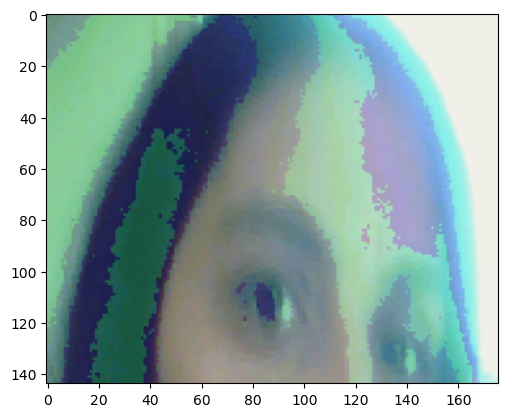

In [241]:
raw_bytes = np.array(data, dtype="i2")
image = np.zeros((len(raw_bytes),3), dtype=int)

# Loop through all of the pixels and form the image
for i in range(len(raw_bytes)):
    #Read 16-bit pixel
    pixel = struct.unpack('>h', raw_bytes[i])[0]

    #Convert RGB565 to RGB 24-bit
    r = ((pixel >> 11) & 0x1f) << 3;
    g = ((pixel >> 5) & 0x3f) << 2;
    b = ((pixel >> 0) & 0x1f) << 3;
    image[i] = [r,g,b]

image = np.reshape(image,(144, 176,3)) #QCIF resolution

# Show the image
plt.imshow(image)
plt.show()

# OUR PICTURES

In [ ]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

In [ ]:
base_image_path = os.path.join(base_path, "words")

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [ ]:
images_words = []
labels_words = []

for data in train_ds:
    images, labels = data["image"], data["label"]
    for i in range(len(images)):
        
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]
    
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        
        if label in class2index:
            images_words.append(img)
            labels_words.append(class2index[label])
    

In [ ]:
new_val_num = int(np.floor(0.20*len(images_words)))
new_val = images_words[:new_val_num]
new_val_label = labels_words[:new_val_num]


new_train = images_words[new_val_num:]
new_train_label = labels_words[new_val_num:]

In [ ]:
preds_arduino_train = intermediate_layer_model.predict(to_arduino_train)
preds_arduino_val = intermediate_layer_model.predict(to_arduino_val)
preds_arduino_test = intermediate_layer_model.predict(to_arduino_test)

In [ ]:
print(to_arduino_labels_train.tolist())

preds_arduino_train = str(preds_arduino_train.tolist())
preds_arduino_train = preds_arduino_train.replace(']','}')
preds_arduino_train = preds_arduino_train.replace('[','{')
preds_arduino_train = preds_arduino_train.replace('},','},\n')

f = open("file.txt", "w")
f.write(preds_arduino_train)

TO DO:
* End After X Epochs
* Predict function